In [1]:
# Import required libraries
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from glob import glob
# Import additional libraries for statistical analysis
from scipy import stats
import json

# Import utilities from scripts/utils
import sys
import importlib
sys.path.append('/media/RCPNAS/Data/Delirium/Delirium_Rania/scripts')
from utils import *


# Setup plotting style using utility function
setup_plotting_style(style='whitegrid', dpi=100, save_dpi=300)

print(" Libraries and utilities imported successfully")

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 Libraries and utilities imported successfully


In [2]:
# Cache management functions:
# - get_cache_info(): Get cache statistics (size, memory usage, etc.)
# - clear_connectome_cache(): Clear all cached connectomes
# - enable_connectome_cache(True/False): Enable or disable caching
# - preload_connectomes(): Preload common connectome types into cache

# Display current cache status
cache_info = get_cache_info()
print("=" * 60)
print("CONNECTOME CACHE STATUS")
print("=" * 60)
print(f"Cache enabled: {cache_info['enabled']}")
print(f"Cached connectomes: {cache_info['size']}")
print(f"Memory usage: {cache_info['memory_mb']:.2f} MB")
if cache_info['size'] > 0:
    print(f"\nCached files ({cache_info['size']}):")
    for i, key in enumerate(cache_info['keys'][:5], 1):  # Show first 5
        print(f"  {i}. {Path(key).name}")
    if cache_info['size'] > 5:
        print(f"  ... and {cache_info['size'] - 5} more")
print("=" * 60)

# Set PRELOAD_COMMON_CONNECTOMES = True to preload SC_sift2_sizecorr, SC_sift2, MEAN_FA, MEAN_MD
PRELOAD_COMMON_CONNECTOMES = True

if PRELOAD_COMMON_CONNECTOMES:
    preload_summary = preload_connectomes(
        preproc_dir=PREPROC_DIR,
        connectome_types=['SC_sift2_sizecorr', 'SC_sift2', 'MEAN_FA', 'MEAN_MD'],
        verbose=True
    )



CONNECTOME CACHE STATUS
Cache enabled: True
Cached connectomes: 0
Memory usage: 0.00 MB
PRELOADING CONNECTOMES INTO CACHE
Connectome types: SC_sift2_sizecorr, SC_sift2, MEAN_FA, MEAN_MD
Subjects: All available

✓ Loaded sub-AD: shape (430, 430)


✓ Loaded sub-AF: shape (430, 430)
✓ Loaded sub-AM: shape (430, 430)
✓ Loaded sub-AR: shape (430, 430)
✓ Loaded sub-BA: shape (430, 430)
✓ Loaded sub-CG: shape (430, 430)
✓ Loaded sub-DA: shape (430, 430)
✓ Loaded sub-DA2: shape (430, 430)
✓ Loaded sub-FD: shape (430, 430)
✓ Loaded sub-FEF: shape (430, 430)
✓ Loaded sub-FS: shape (430, 430)
✓ Loaded sub-FSE: shape (430, 430)
✓ Loaded sub-GB: shape (430, 430)
✓ Loaded sub-GL: shape (430, 430)
✓ Loaded sub-KJ: shape (430, 430)
✓ Loaded sub-LL: shape (430, 430)
✓ Loaded sub-MF: shape (430, 430)
✓ Loaded sub-PB: shape (430, 430)
✓ Loaded sub-PC: shape (430, 430)
✓ Loaded sub-PL: shape (430, 430)
✓ Loaded sub-PM: shape (430, 430)
✓ Loaded sub-PMA: shape (430, 430)
✓ Loaded sub-PO: shape (430, 430)
✓ Loaded sub-SA: shape (430, 430)
✓ Loaded sub-SG: shape (430, 430)
✓ Loaded sub-TL: shape (430, 430)
✓ Loaded sub-TOG: shape (430, 430)
✓ Loaded sub-VC: shape (430, 430)
✓ Loaded sub-ZM: shape (430, 430)

Successfully loaded 29 connectomes
✓ Prelo

In [3]:
# Config - using centralized paths from utils

DATA_DIR = PREPROC_DIR  # Alias for DATA_DIR used in notebook
GROUPS = {
    'ICU': ['AF','DA2','PM','BA','VC'],
    'ICU Delirium': ['CG','DA','FS','FSE','GL','KJ','LL','MF','PMA','PO','PB','SA'],
    'Healthy Controls': ['FEF','FD','GB','SG','AR','TL','TOG','PL','ZM','AM','PC','AD']
}
print(f"Root directory: {ROOT_DIR}")
print(f"Preprocessing directory: {PREPROC_DIR}")
print(f"Atlas directory: {ATLAS_DIR}")
print(f"Number of ROIs: {N_ROIS}")

Root directory: /media/RCPNAS/Data/Delirium/Delirium_Rania
Preprocessing directory: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current
Atlas directory: /media/RCPNAS/Data/Delirium/Delirium_Rania/atlas
Number of ROIs: 430


## QC Section: SNR Voxelwise Analysis

This section analyzes the voxelwise SNR QC results to determine if preprocessing provides meaningful improvement in data quality.


In [4]:
# Load all SNR QC data
snr_df = load_snr_qc_data(PREPROC_DIR)
print(f"\nLoaded SNR QC data for {len(snr_df)} subjects")
if len(snr_df) > 0:
    print(f"\nColumns: {list(snr_df.columns)}")
    print(f"\nFirst few rows:")
    print(snr_df.head())



Loaded SNR QC data for 29 subjects

Columns: ['subject', 'snr_pre', 'snr_post', 'snr_improvement', 'snr_improvement_pct', 'snr_pre_median', 'snr_post_median', 'snr_pre_std', 'snr_post_std', 'noise_std_global', 'correlation', 'rmse', 'n_voxels_improved', 'n_voxels_degraded', 'n_voxels_total']

First few rows:
  subject     snr_pre    snr_post  snr_improvement  snr_improvement_pct  \
0  sub-AD  119.684997  134.165029        14.480032            12.098452   
1  sub-AF   27.584598   28.885707         1.301110             4.716797   
2  sub-AM  110.135345  124.843453        14.708109            13.354576   
3  sub-AR  117.872217  127.416318         9.544101             8.096989   
4  sub-BA   33.315786   32.546221        -0.769565            -2.309912   

   snr_pre_median  snr_post_median  snr_pre_std  snr_post_std  \
0      126.988983       139.722666    30.899053     26.904245   
1       27.101116        28.217798     5.056785      6.983447   
2      109.442513       123.742009    43.68

In [5]:
# Descriptive statistics for SNR QC
if len(snr_df) > 0:
    print("=" * 80)
    print("SNR QC DESCRIPTIVE STATISTICS")
    print("=" * 80)
    
    print(f"\nN = {len(snr_df)} subjects with SNR QC data")
    
    print(f"\n{'Metric':<30} {'Pre-processing':<20} {'Post-processing':<20} {'Improvement':<20}")
    print("-" * 90)
    
    if 'snr_pre' in snr_df.columns and 'snr_post' in snr_df.columns:
        print(f"{'Mean SNR':<30} {snr_df['snr_pre'].mean():>18.2f} ± {snr_df['snr_pre'].std():>5.2f}  "
              f"{snr_df['snr_post'].mean():>18.2f} ± {snr_df['snr_post'].std():>5.2f}  "
              f"{snr_df['snr_improvement'].mean():>18.2f} ± {snr_df['snr_improvement'].std():>5.2f}")
        
        print(f"{'Median SNR':<30} {snr_df['snr_pre_median'].median():>18.2f}          "
              f"{snr_df['snr_post_median'].median():>18.2f}          "
              f"{snr_df['snr_improvement'].median():>18.2f}")
        
        print(f"{'Range (min-max)':<30} [{snr_df['snr_pre'].min():>6.2f}, {snr_df['snr_pre'].max():>6.2f}]  "
              f"[{snr_df['snr_post'].min():>6.2f}, {snr_df['snr_post'].max():>6.2f}]  "
              f"[{snr_df['snr_improvement'].min():>6.2f}, {snr_df['snr_improvement'].max():>6.2f}]")
    
    if 'snr_improvement_pct' in snr_df.columns:
        print(f"\n{'Percentage Improvement':<30} {snr_df['snr_improvement_pct'].mean():>18.2f}% ± {snr_df['snr_improvement_pct'].std():>5.2f}%")
        print(f"{'Range':<30} [{snr_df['snr_improvement_pct'].min():>6.2f}%, {snr_df['snr_improvement_pct'].max():>6.2f}%]")
    
    if 'correlation' in snr_df.columns:
        print(f"\n{'Correlation (pre vs post)':<30} {snr_df['correlation'].mean():>18.3f} ± {snr_df['correlation'].std():>5.3f}")
    
    print("=" * 80)
else:
    print("No SNR QC data available for analysis")


SNR QC DESCRIPTIVE STATISTICS

N = 29 subjects with SNR QC data

Metric                         Pre-processing       Post-processing      Improvement         
------------------------------------------------------------------------------------------
Mean SNR                                    69.55 ± 43.46               75.22 ± 50.10                5.67 ±  7.11
Median SNR                                  35.93                       36.28                        1.18
Range (min-max)                [ 27.58, 140.00]  [ 27.97, 156.24]  [ -2.25,  19.37]

Percentage Improvement                       5.00% ±  6.25%
Range                          [ -5.08%,  16.95%]

Correlation (pre vs post)                   0.920 ± 0.066


In [6]:
# Statistical tests for SNR improvement
if len(snr_df) > 0 and 'snr_pre' in snr_df.columns and 'snr_post' in snr_df.columns:
    print("=" * 80)
    print("STATISTICAL TESTS FOR SNR IMPROVEMENT")
    print("=" * 80)
    
    # Remove any missing values
    valid_data = snr_df[['snr_pre', 'snr_post']].dropna()
    n_valid = len(valid_data)
    
    if n_valid > 1:
        pre_snr = valid_data['snr_pre'].values
        post_snr = valid_data['snr_post'].values
        diff_snr = post_snr - pre_snr
        
        print(f"\nN = {n_valid} subjects with complete paired data")
        
        # 1. Paired t-test (parametric)
        print("\n1. PAIRED T-TEST (Parametric)")
        print("-" * 80)
        t_stat, pval_ttest = stats.ttest_rel(post_snr, pre_snr)
        print(f"   t-statistic: {t_stat:.4f}")
        print(f"   p-value:     {pval_ttest:.6f}")
        print(f"   Mean difference: {diff_snr.mean():.4f} ± {diff_snr.std():.4f}")
        
        # 95% confidence interval for mean difference
        sem = stats.sem(diff_snr)
        ci_95 = stats.t.interval(0.95, n_valid - 1, loc=diff_snr.mean(), scale=sem)
        print(f"   95% CI for mean difference: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]")
        
        if pval_ttest < 0.001:
            significance = "*** (p < 0.001)"
        elif pval_ttest < 0.01:
            significance = "** (p < 0.01)"
        elif pval_ttest < 0.05:
            significance = "* (p < 0.05)"
        else:
            significance = "ns (not significant)"
        print(f"   Result: {significance}")
        
        # 2. Wilcoxon signed-rank test (non-parametric)
        print("\n2. WILCOXON SIGNED-RANK TEST (Non-parametric)")
        print("-" * 80)
        w_stat, pval_wilcoxon = stats.wilcoxon(post_snr, pre_snr, alternative='greater')
        print(f"   W-statistic: {w_stat:.4f}")
        print(f"   p-value:     {pval_wilcoxon:.6f}")
        
        if pval_wilcoxon < 0.001:
            significance = "*** (p < 0.001)"
        elif pval_wilcoxon < 0.01:
            significance = "** (p < 0.01)"
        elif pval_wilcoxon < 0.05:
            significance = "* (p < 0.05)"
        else:
            significance = "ns (not significant)"
        print(f"   Result: {significance}")
        
        # 3. Effect size (Cohen's d for paired samples)
        print("\n3. EFFECT SIZE (Cohen's d for paired samples)")
        print("-" * 80)
        # Cohen's d = mean_diff / std_diff
        cohens_d = diff_snr.mean() / diff_snr.std()
        print(f"   Cohen's d: {cohens_d:.4f}")
        
        if abs(cohens_d) < 0.2:
            effect_size = "negligible"
        elif abs(cohens_d) < 0.5:
            effect_size = "small"
        elif abs(cohens_d) < 0.8:
            effect_size = "medium"
        else:
            effect_size = "large"
        print(f"   Interpretation: {effect_size} effect size")
        
        # 4. Practical significance
        print("\n4. PRACTICAL SIGNIFICANCE")
        print("-" * 80)
        mean_improvement_pct = (diff_snr.mean() / pre_snr.mean()) * 100
        print(f"   Mean improvement: {mean_improvement_pct:.2f}%")
        print(f"   Subjects with improvement: {np.sum(diff_snr > 0)}/{n_valid} ({100*np.sum(diff_snr > 0)/n_valid:.1f}%)")
        print(f"   Subjects with degradation: {np.sum(diff_snr < 0)}/{n_valid} ({100*np.sum(diff_snr < 0)/n_valid:.1f}%)")
        
        # Literature-based interpretation
        print("\n5. LITERATURE-BASED INTERPRETATION")
        print("-" * 80)
        if mean_improvement_pct >= 20:
            print("   ✓ EXCELLENT: Improvement ≥20% (typical for denoising: 20-50%)")
        elif mean_improvement_pct >= 10:
            print("   ✓ GOOD: Improvement ≥10% (moderate preprocessing benefit)")
        elif mean_improvement_pct >= 5:
            print("   → MODERATE: Improvement ≥5% (small but potentially meaningful)")
        else:
            print("   ⚠️  MINIMAL: Improvement <5% (may not be practically meaningful)")
        
        if pval_ttest < 0.05 or pval_wilcoxon < 0.05:
            print("   ✓ STATISTICALLY SIGNIFICANT: Preprocessing provides meaningful improvement")
        else:
            print("   ⚠️  NOT STATISTICALLY SIGNIFICANT: Improvement may be due to chance")
        
        print("=" * 80)
    else:
        print(f"Insufficient data for statistical tests (N = {n_valid})")
else:
    print("No SNR data available for statistical tests")


STATISTICAL TESTS FOR SNR IMPROVEMENT

N = 29 subjects with complete paired data

1. PAIRED T-TEST (Parametric)
--------------------------------------------------------------------------------
   t-statistic: 4.2919
   p-value:     0.000191
   Mean difference: 5.6689 ± 6.9891
   95% CI for mean difference: [2.9633, 8.3745]
   Result: *** (p < 0.001)

2. WILCOXON SIGNED-RANK TEST (Non-parametric)
--------------------------------------------------------------------------------
   W-statistic: 378.0000
   p-value:     0.000260
   Result: *** (p < 0.001)

3. EFFECT SIZE (Cohen's d for paired samples)
--------------------------------------------------------------------------------
   Cohen's d: 0.8111
   Interpretation: large effect size

4. PRACTICAL SIGNIFICANCE
--------------------------------------------------------------------------------
   Mean improvement: 8.15%
   Subjects with improvement: 23/29 (79.3%)
   Subjects with degradation: 6/29 (20.7%)

5. LITERATURE-BASED INTERPRETATION

In [7]:
# Summary table of SNR QC results
if len(snr_df) > 0:
    print("=" * 80)
    print("SNR QC SUMMARY TABLE")
    print("=" * 80)
    
    # Create summary table
    summary_cols = ['subject', 'snr_pre', 'snr_post', 'snr_improvement', 'snr_improvement_pct']
    if 'correlation' in snr_df.columns:
        summary_cols.append('correlation')
    
    summary_df = snr_df[summary_cols].copy()
    summary_df = summary_df.sort_values('snr_improvement_pct', ascending=False)
    
    # Format for display
    pd.set_option('display.max_rows', None)
    pd.set_option('display.float_format', lambda x: f'{x:.2f}' if pd.notna(x) else 'N/A')
    
    print("\nSubjects sorted by improvement percentage:")
    print(summary_df.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("KEY FINDINGS")
    print("=" * 80)
    
    if 'snr_improvement_pct' in snr_df.columns:
        n_improved = (snr_df['snr_improvement_pct'] > 0).sum()
        n_degraded = (snr_df['snr_improvement_pct'] < 0).sum()
        mean_improvement = snr_df['snr_improvement_pct'].mean()
        
        print(f"• {n_improved}/{len(snr_df)} subjects ({100*n_improved/len(snr_df):.1f}%) showed SNR improvement")
        print(f"• {n_degraded}/{len(snr_df)} subjects ({100*n_degraded/len(snr_df):.1f}%) showed SNR degradation")
        print(f"• Mean improvement: {mean_improvement:.2f}%")
        
        if mean_improvement > 0 and len(snr_df) > 1:
            valid_data = snr_df[['snr_pre', 'snr_post']].dropna()
            if len(valid_data) > 1:
                _, pval = stats.ttest_rel(valid_data['snr_post'], valid_data['snr_pre'])
                if pval < 0.05:
                    print(f"• Statistical significance: YES (p = {pval:.4f})")
                    print("  → Preprocessing provides meaningful SNR improvement")
                else:
                    print(f"• Statistical significance: NO (p = {pval:.4f})")
                    print("  → Improvement may not be statistically meaningful")
    
    print("=" * 80)


SNR QC SUMMARY TABLE

Subjects sorted by improvement percentage:
subject  snr_pre  snr_post  snr_improvement  snr_improvement_pct  correlation
 sub-PC   114.30    133.67            19.37                16.95         0.92
 sub-PL    94.97    110.51            15.54                16.36         0.82
 sub-AM   110.14    124.84            14.71                13.35         0.96
sub-TOG   131.52    148.20            16.69                12.69         0.92
 sub-ZM   115.94    130.27            14.33                12.36         0.96
 sub-AD   119.68    134.17            14.48                12.10         0.97
 sub-GB   140.00    156.24            16.24                11.60         0.97
 sub-SG   127.56    141.80            14.23                11.16         0.90
 sub-FD   131.05    142.93            11.88                 9.06         0.96
 sub-AR   117.87    127.42             9.54                 8.10         0.96
 sub-TL   104.06    111.35             7.29                 7.00         0.97

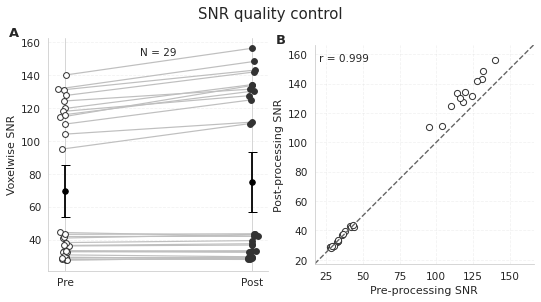

N=29 | paired t-test p=0.000191247 | r=0.9985
Wilcoxon p=0.000519444 (optional for caption/supplement)


In [8]:
# Paper-ready SNR QC figure (double-column, clean grayscale)
# - Shared figure title (optional) + caption carries details
# - Panel labels (A/B)
# - Minimal inline annotations (N on A, r on B)
# - Paired plot + pre/post scatter with identity line

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# -------------------------
# Input checks
# -------------------------
required_cols = {"snr_pre", "snr_post"}
if "valid_data" not in globals():
    raise ValueError("`valid_data` not found. Create it from your snr_df before running this script.")

if not required_cols.issubset(set(valid_data.columns)):
    raise ValueError(f"`valid_data` must contain columns {required_cols}, got {set(valid_data.columns)}")

pre = valid_data["snr_pre"].to_numpy(dtype=float)
post = valid_data["snr_post"].to_numpy(dtype=float)

mask = np.isfinite(pre) & np.isfinite(post)
pre, post = pre[mask], post[mask]
n = len(pre)
if n < 3:
    raise ValueError(f"Not enough valid paired samples after filtering (N={n}).")

# -------------------------
# Statistics (use for caption/log; keep plot minimal)
# -------------------------
tstat, p_t = stats.ttest_rel(post, pre)
diff = post - pre
try:
    w_stat, p_w = stats.wilcoxon(diff)
except Exception:
    p_w = None

r = np.corrcoef(pre, post)[0, 1]

mean_pre, mean_post = pre.mean(), post.mean()
sem_pre, sem_post = stats.sem(pre), stats.sem(post)
ci_pre, ci_post = 1.96 * sem_pre, 1.96 * sem_post  # 95% CI for mean

# -------------------------
# Plot styling (double-column legibility)
# -------------------------
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 11,
    "xtick.labelsize": 10.5,
    "ytick.labelsize": 10.5,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

fig, axes = plt.subplots(
    1, 2,
    figsize=(7.4, 3.8),
    constrained_layout=True
)

# Optional shared title (you can also remove it and rely on caption)
fig.suptitle("SNR quality control", fontsize=15, y=1.06)

# =========================
# Panel A: Paired pre/post
# =========================
ax = axes[0]

# Small horizontal jitter to reduce overlap
rng = np.random.default_rng(7)
j0 = rng.normal(0, 0.015, size=n)
j1 = rng.normal(0, 0.015, size=n)

for i in range(n):
    ax.plot([0 + j0[i], 1 + j1[i]], [pre[i], post[i]],
            color="0.75", linewidth=1.2, zorder=1)

ax.scatter(np.zeros(n) + j0, pre,
           s=34, facecolor="white", edgecolor="0.2", linewidth=1.0, zorder=2)
ax.scatter(np.ones(n) + j1, post,
           s=34, facecolor="0.2", edgecolor="0.2", linewidth=1.0, zorder=3)

ax.errorbar([0, 1], [mean_pre, mean_post],
            yerr=[ci_pre, ci_post],
            fmt="o", color="0.0", markersize=5.5,
            capsize=4.5, linewidth=1.8, zorder=4)

ax.set_xticks([0, 1])
ax.set_xticklabels(["Pre", "Post"])
ax.set_ylabel("Voxelwise SNR")

# Minimal annotation: only N (move p-value to caption)
ax.text(0.5, 0.96, f"N = {n}",
        ha="center", va="top", transform=ax.transAxes, fontsize=10.5)

ax.grid(True, axis="y", linestyle="--", linewidth=0.8, alpha=0.25)

ax.text(-0.18, 1.05, "A", transform=ax.transAxes,
        fontsize=13, fontweight="bold", va="top")

# =========================
# Panel B: Pre vs Post
# =========================
ax = axes[1]

ax.scatter(pre, post,
           s=38, facecolor="white", edgecolor="0.2", linewidth=1.0)

minv = float(min(pre.min(), post.min()))
maxv = float(max(pre.max(), post.max()))
pad = 0.08 * (maxv - minv) if maxv > minv else 1.0

ax.plot([minv - pad, maxv + pad], [minv - pad, maxv + pad],
        linestyle="--", color="0.4", linewidth=1.4)

ax.set_xlim(minv - pad, maxv + pad)
ax.set_ylim(minv - pad, maxv + pad)
ax.set_aspect("equal", adjustable="box")

ax.set_xlabel("Pre-processing SNR")
ax.set_ylabel("Post-processing SNR")

# Minimal annotation: correlation only
ax.text(0.02, 0.96, f"r = {r:.3f}",
        ha="left", va="top", transform=ax.transAxes, fontsize=10.5)

ax.grid(True, linestyle="--", linewidth=0.8, alpha=0.25)

ax.text(-0.18, 1.05, "B", transform=ax.transAxes,
        fontsize=13, fontweight="bold", va="top")

plt.show()

print(f"N={n} | paired t-test p={p_t:.6g} | r={r:.4f}")
if p_w is not None:
    print(f"Wilcoxon p={p_w:.6g} (optional for caption/supplement)")


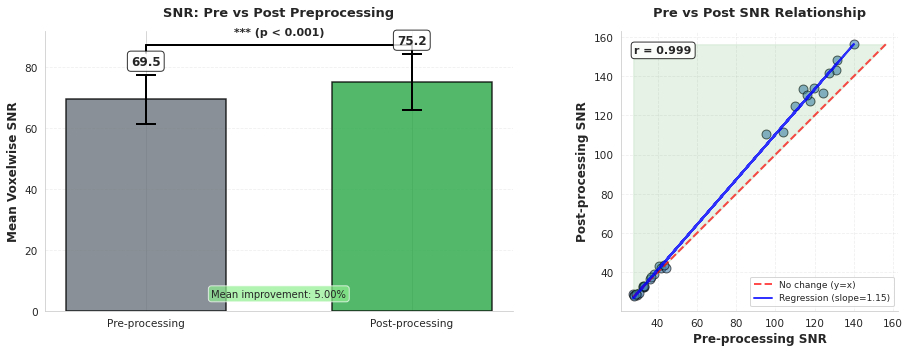


✓ Visualization complete (N = 29 subjects)
  Pre-processing SNR: 69.55 ± 8.07 (SEM)
  Post-processing SNR: 75.22 ± 9.30 (SEM)
  Mean improvement: 5.00%
  Statistical significance: p = 0.000191


In [9]:
# Visualization of SNR before and after preprocessing
if len(snr_df) > 0 and 'snr_pre' in snr_df.columns and 'snr_post' in snr_df.columns:
    # Prepare data for plotting
    valid_data = snr_df[['subject', 'snr_pre', 'snr_post', 'snr_improvement_pct']].dropna()
    
    if len(valid_data) > 0:
        # Create figure with 2 subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Calculate statistics
        pre_mean = valid_data['snr_pre'].mean()
        post_mean = valid_data['snr_post'].mean()
        pre_sem = valid_data['snr_pre'].sem()
        post_sem = valid_data['snr_post'].sem()
        
        # Perform statistical test
        _, pval = stats.ttest_rel(valid_data['snr_post'], valid_data['snr_pre'])
        mean_improvement = valid_data['snr_improvement_pct'].mean()
        
        # ============================================================
        # Plot 1: Bar plot with error bars (Mean ± SEM)
        # ============================================================
        ax1 = axes[0]
        
        # Create bar plot
        conditions = ['Pre-processing', 'Post-processing']
        means = [pre_mean, post_mean]
        sems = [pre_sem, post_sem]
        colors = ['#6C757D', '#28A745']  # Gray → Green
        
        bars = ax1.bar(conditions, means, yerr=sems, capsize=10, 
                      color=colors, alpha=0.8, edgecolor='black', linewidth=1.5,
                      width=0.6, error_kw={'elinewidth': 2, 'capthick': 2})
        
        # Add value labels on bars (positioned above error bars)
        for i, (mean, sem) in enumerate(zip(means, sems)):
            # Position label well above the error bar
            label_y = mean + sem + max(means) * 0.03
            ax1.text(i, label_y, f'{mean:.1f}',
                    ha='center', va='bottom', fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='black', linewidth=1))
        
        # Add significance bracket
        y_max = max(means) + max(sems) + max(means) * 0.1
        y_pos = y_max * 0.95
        
        if pval < 0.001:
            sig_text = '*** (p < 0.001)'
        elif pval < 0.01:
            sig_text = '** (p < 0.01)'
        elif pval < 0.05:
            sig_text = '* (p < 0.05)'
        else:
            sig_text = 'ns (not significant)'
        
        ax1.plot([0, 1], [y_pos, y_pos], 'k-', linewidth=2)
        ax1.plot([0, 0], [y_pos, y_pos*0.97], 'k-', linewidth=2)
        ax1.plot([1, 1], [y_pos, y_pos*0.97], 'k-', linewidth=2)
        ax1.text(0.5, y_pos*1.03, sig_text, ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
        
        # Add improvement annotation
        improvement_text = f'Mean improvement: {mean_improvement:.2f}%'
        ax1.text(0.5, ax1.get_ylim()[0] + (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.05,
                improvement_text, ha='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
        
        ax1.set_ylabel('Mean Voxelwise SNR', fontsize=12, fontweight='bold')
        ax1.set_title('SNR: Pre vs Post Preprocessing', fontsize=13, fontweight='bold', pad=15)
        ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
        ax1.set_ylim(bottom=0)
        
        # ============================================================
        # Plot 2: Scatter plot (Pre vs Post) with diagonal reference
        # ============================================================
        ax2 = axes[1]
        
        # Create scatter plot
        ax2.scatter(valid_data['snr_pre'], valid_data['snr_post'], 
                   s=80, alpha=0.6, color='steelblue', edgecolors='black', linewidth=1)
        
        # Add diagonal line (y = x) - points above this line show improvement
        min_val = min(valid_data['snr_pre'].min(), valid_data['snr_post'].min())
        max_val = max(valid_data['snr_pre'].max(), valid_data['snr_post'].max())
        ax2.plot([min_val, max_val], [min_val, max_val], 
                'r--', linewidth=2, alpha=0.7, label='No change (y=x)')
        
        # Add regression line
        z = np.polyfit(valid_data['snr_pre'], valid_data['snr_post'], 1)
        p = np.poly1d(z)
        ax2.plot(valid_data['snr_pre'], p(valid_data['snr_pre']), 
                "b-", linewidth=2, alpha=0.8, label=f'Regression (slope={z[0]:.2f})')
        
        # Calculate correlation
        correlation = valid_data['snr_pre'].corr(valid_data['snr_post'])
        
        ax2.set_xlabel('Pre-processing SNR', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Post-processing SNR', fontsize=12, fontweight='bold')
        ax2.set_title('Pre vs Post SNR Relationship', fontsize=13, fontweight='bold', pad=15)
        ax2.legend(loc='lower right', fontsize=9)
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.set_aspect('equal', adjustable='box')
        
        # Add correlation text
        ax2.text(0.05, 0.95, f'r = {correlation:.3f}', 
                transform=ax2.transAxes, fontsize=11, fontweight='bold',
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black'))
        
        # Shade region above diagonal (improvement zone)
        ax2.fill_between([min_val, max_val], [min_val, max_val], [max_val, max_val],
                        alpha=0.1, color='green', label='Improvement zone')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ Visualization complete (N = {len(valid_data)} subjects)")
        print(f"  Pre-processing SNR: {pre_mean:.2f} ± {pre_sem:.2f} (SEM)")
        print(f"  Post-processing SNR: {post_mean:.2f} ± {post_sem:.2f} (SEM)")
        print(f"  Mean improvement: {mean_improvement:.2f}%")
        print(f"  Statistical significance: p = {pval:.6f}")
    else:
        print("No valid data for visualization")
else:
    print("SNR data not available for visualization")


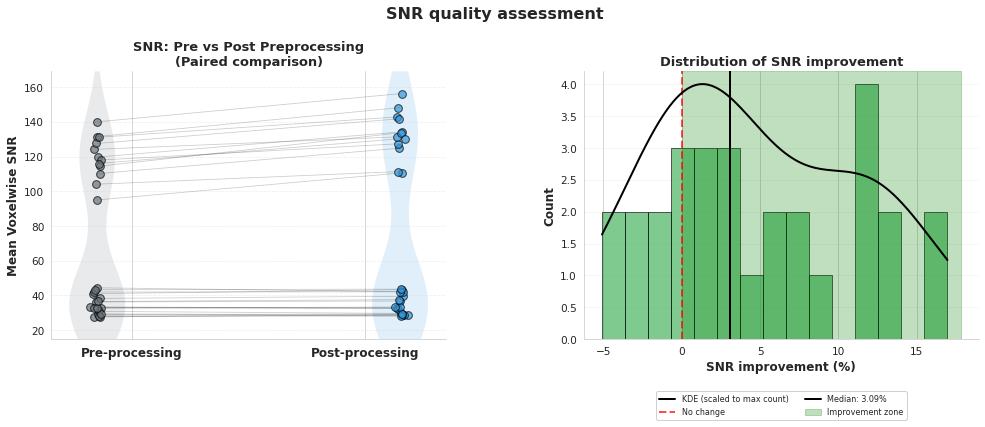


SNR PRE-POST COMPARISON SUMMARY (Non-parametric)
N = 29 subjects

Pre-processing SNR median (IQR): 41.89 (32.79–115.94)
Post-processing SNR median (IQR): 42.09 (32.55–130.27)
Median Δ: +0.20 (+0.5%)

Wilcoxon W = 378.00, p = 0.0002597
Rank-biserial r = 0.131

Spearman ρ(pre, post) = 0.986, p = 2e-22


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde

# ---------------------------------------------------------------------
# Comprehensive SNR Pre vs Post Visualization (Non-parametric)
# ---------------------------------------------------------------------
if len(snr_df) > 0 and {'snr_pre', 'snr_post'}.issubset(snr_df.columns):

    # Prepare data
    cols = ['subject', 'snr_pre', 'snr_post', 'snr_improvement_pct']
    valid_data = snr_df[cols].dropna()

    if len(valid_data) == 0:
        print("No valid data for visualization")
    else:
        # ---------- basic statistics ----------
        pre  = valid_data['snr_pre'].values
        post = valid_data['snr_post'].values
        imp  = valid_data['snr_improvement_pct'].values

        pre_median  = np.median(pre)
        post_median = np.median(post)
        pre_q25, pre_q75   = np.percentile(pre,  [25, 75])
        post_q25, post_q75 = np.percentile(post, [25, 75])

        # Wilcoxon signed-rank test (post > pre)
        try:
            wilcoxon_stat, wilcoxon_p = stats.wilcoxon(
                post, pre, alternative='greater'
            )
        except Exception:
            wilcoxon_stat, wilcoxon_p = None, None

        # Rank-biserial effect size
        if wilcoxon_stat is not None:
            n = len(valid_data)
            r_biserial = 1.0 - (2.0 * wilcoxon_stat) / (n * (n + 1))
        else:
            r_biserial = None
        try:
            spearman_r, spearman_p = stats.spearmanr(pre, post)
        except Exception:
            spearman_r, spearman_p = None, None

        median_diff     = post_median - pre_median
        median_diff_pct = (median_diff / pre_median) * 100 if pre_median > 0 else 0.0

        # Colors
        color_pre     = '#6C757D'   # grey
        color_post    = '#3498DB'   # blue
        color_improve = '#28A745'   # green

        # ---------- figure layout ----------
        fig, (ax1, ax2) = plt.subplots(
            1, 2, figsize=(14, 6),
            gridspec_kw={'width_ratios': [1, 1]}
        )
        # extra bottom margin so the 2nd-plot legend can sit below its axis
        plt.subplots_adjust(left=0.06, right=0.98, bottom=0.20,
                            top=0.82, wspace=0.35)

        # ================================================================
        # PLOT 1: Paired pre/post with distribution
        # ================================================================
        x_pre_pos  = -0.15
        x_post_pos = 1.15

        y_pre  = pre
        y_post = post

        y_min = min(y_pre.min(), y_post.min())
        y_max = max(y_pre.max(), y_post.max())
        y_range = y_max - y_min if y_max > y_min else max(y_max, 1.0)
        pad = 0.1 * y_range
        ax1.set_ylim(max(0, y_min - pad), y_max + pad)

        # Violin-like density shapes (behind everything)
        try:
            y_grid = np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], 200)

            kde_pre  = gaussian_kde(y_pre)
            kde_post = gaussian_kde(y_post)

            width = 0.12
            d_pre  = kde_pre(y_grid);  d_pre  = d_pre  / d_pre.max()  * width
            d_post = kde_post(y_grid); d_post = d_post / d_post.max() * width

            ax1.fill_betweenx(
                y_grid, x_pre_pos  - d_pre,  x_pre_pos  + d_pre,
                color=color_pre, alpha=0.15, zorder=0, edgecolor='none'
            )
            ax1.fill_betweenx(
                y_grid, x_post_pos - d_post, x_post_pos + d_post,
                color=color_post, alpha=0.15, zorder=0, edgecolor='none'
            )
        except Exception:
            # KDE can fail for very small N; just skip violins in that case
            pass

        # Paired lines
        for yp, yo in zip(y_pre, y_post):
            ax1.plot([x_pre_pos, x_post_pos], [yp, yo],
                     color='k', alpha=0.2, linewidth=0.8, zorder=1)

        # Jittered scatter (fixed seed for reproducibility)
        rng = np.random.default_rng(42)
        jitter_pre  = rng.normal(0, 0.015, len(valid_data))
        jitter_post = rng.normal(0, 0.015, len(valid_data))

        ax1.scatter(
            np.full_like(y_pre,  x_pre_pos)  + jitter_pre,  y_pre,
            s=60, alpha=0.7, color=color_pre, edgecolors='black',
            linewidth=1, label='Pre-processing', zorder=3
        )
        ax1.scatter(
            np.full_like(y_post, x_post_pos) + jitter_post, y_post,
            s=60, alpha=0.7, color=color_post, edgecolors='black',
            linewidth=1, label='Post-processing', zorder=3
        )

        

        

        # Axes formatting
        ax1.set_xticks([0, 1])
        ax1.set_xticklabels(['Pre-processing', 'Post-processing'],
                            fontsize=12, fontweight='bold')
        ax1.set_ylabel('Mean Voxelwise SNR', fontsize=12, fontweight='bold')
        ax1.set_title('SNR: Pre vs Post Preprocessing\n(Paired comparison)',
                      fontsize=13, fontweight='bold')
        ax1.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)

        # ================================================================
        # PLOT 2: Distribution of SNR improvement
        # ================================================================

        n_hist, bins, _ = ax2.hist(
            imp,
            bins=15,
            alpha=0.6,
            color=color_improve,
            edgecolor='black',
            linewidth=1,
            density=False
        )

        # KDE normalized to max histogram count (for clear overlay)
        try:
            kde_imp = gaussian_kde(imp)

            # Use bin range to match histogram support
            x_grid = np.linspace(bins[0], bins[-1], 200)
            kde_vals = kde_imp(x_grid)

            if np.any(kde_vals > 0):
                # Scale KDE so its peak matches the tallest bar
                kde_scaled = kde_vals / kde_vals.max() * n_hist.max()
                ax2.plot(
                    x_grid,
                    kde_scaled,
                    'k-',
                    linewidth=2,
                    label='KDE (scaled to max count)',
                    zorder=5
                )
        except Exception:
            # If KDE fails (e.g. too few samples), just skip the curve
            pass

        # Median & no-change vertical lines
        median_imp = np.median(imp)
        ax2.axvline(
            0,
            color='red',
            linestyle='--',
            linewidth=2,
            alpha=0.7,
            label='No change'
        )
        ax2.axvline(
            median_imp,
            color='black',
            linestyle='-',
            linewidth=2,
            label=f'Median: {median_imp:.2f}%'
        )

        # Stronger shading for positive (improvement) region
        if imp.max() > 0:
            ax2.axvspan(
                0,
                imp.max() * 1.05,
                color='green',
                alpha=0.25,
                label='Improvement zone'
            )

        ax2.set_xlabel(
            'SNR improvement (%)',
            fontsize=12,
            fontweight='bold'
        )
        ax2.set_ylabel(
            'Count',
            fontsize=12,
            fontweight='bold'
        )
        ax2.set_title(
            'Distribution of SNR improvement',
            fontsize=13,
            fontweight='bold'
        )
        ax2.grid(axis='y', linestyle='--', alpha=0.3)

        # Legend BELOW the 2nd axis (no overlap with bars or other subplots)
        ax2.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, -0.18),
            ncol=2,
            fontsize=8,
            framealpha=0.9
        )



        # ---------- main title ----------
        fig.suptitle(
            'SNR quality assessment',
            fontsize=16, fontweight='bold', y=0.97
        )

        plt.show()

        # ---------- console summary (unchanged) ----------
        print("\n" + "=" * 80)
        print("SNR PRE-POST COMPARISON SUMMARY (Non-parametric)")
        print("=" * 80)
        print(f"N = {len(valid_data)} subjects")
        print(f"\nPre-processing SNR median (IQR): {pre_median:.2f} "
              f"({pre_q25:.2f}–{pre_q75:.2f})")
        print(f"Post-processing SNR median (IQR): {post_median:.2f} "
              f"({post_q25:.2f}–{post_q75:.2f})")
        print(f"Median Δ: {median_diff:+.2f} ({median_diff_pct:+.1f}%)")
        if wilcoxon_stat is not None:
            print(f"\nWilcoxon W = {wilcoxon_stat:.2f}, p = {wilcoxon_p:.4g}")
            if r_biserial is not None:
                print(f"Rank-biserial r = {r_biserial:.3f}")
        print(f"\nSpearman ρ(pre, post) = {spearman_r:.3f}, "
              f"p = {spearman_p:.4g}")
        print("=" * 80)

else:
    print("SNR data not available for visualization")


In [12]:
# ============================================================================
# SNR Group Comparison: HC vs ICU-controls vs ICU-delirium
# ============================================================================

# Step 1: Map subjects to groups based on GROUPS definition
def get_group_for_subject(subject_id, groups_dict):
    """
    Map subject ID to group.
    
    Parameters:
    -----------
    subject_id : str
        Subject ID (e.g., 'sub-AF' or 'AF')
    groups_dict : dict
        Dictionary mapping group names to lists of subject codes
        
    Returns:
    --------
    group_name : str or None
        Group name if found, None otherwise
    """
    # Extract subject code (remove 'sub-' prefix if present)
    sub_code = subject_id.replace('sub-', '').upper()
    
    # Search through groups
    for group_name, subject_codes in groups_dict.items():
        if sub_code in [code.upper() for code in subject_codes]:
            return group_name
    
    return None

# Add group column to snr_df if not present
if len(snr_df) > 0:
    if 'group' not in snr_df.columns:
        snr_df['group'] = snr_df['subject'].apply(
            lambda x: get_group_for_subject(x, GROUPS)
        )
        
        # Check how many subjects were mapped
        mapped = snr_df['group'].notna().sum()
        unmapped = snr_df['group'].isna().sum()
        
        print("=" * 80)
        print("GROUP MAPPING")
        print("=" * 80)
        print(f"Mapped: {mapped}/{len(snr_df)} subjects")
        if unmapped > 0:
            unmapped_subjects = snr_df[snr_df['group'].isna()]['subject'].tolist()
            print(f"Unmapped subjects: {unmapped_subjects}")
        
        # Show group distribution
        if mapped > 0:
            print(f"\nGroup distribution:")
            print(snr_df['group'].value_counts().to_string())
        print("=" * 80)
    
    # Step 2: Perform group comparison analysis
    if 'snr_post' in snr_df.columns and 'group' in snr_df.columns:
        # Filter to only subjects with valid snr_post values and mapped groups
        valid_snr = snr_df[['subject', 'group', 'snr_post']].dropna()
        
        if len(valid_snr) == 0:
            print("\nNo valid SNR post-processing data for group comparison")
        else:
            # Rename groups for consistency (optional - adjust as needed)
            group_rename = {
                'Healthy Controls': 'HC',
                'ICU': 'ICU-controls',
                'ICU Delirium': 'ICU-delirium'
            }
            valid_snr = valid_snr.copy()
            valid_snr['group'] = valid_snr['group'].map(group_rename)
            valid_snr = valid_snr.dropna(subset=['group'])  # Remove any unmapped
            
            # Extract data by group
            groups = ['HC', 'ICU-controls', 'ICU-delirium']
            group_data = {}
            group_names_available = []
            
            for group in groups:
                group_values = valid_snr[valid_snr['group'] == group]['snr_post'].values
                if len(group_values) > 0:
                    group_data[group] = group_values
                    group_names_available.append(group)
            
            if len(group_names_available) < 2:
                print(f"\nNot enough groups with data (found: {group_names_available})")
            else:
                print("\n" + "=" * 80)
                print("SNR POST-PROCESSING: GROUP COMPARISON")
                print("=" * 80)
                print(f"Groups analyzed: {', '.join(group_names_available)}")
                print(f"Total subjects: {len(valid_snr)}")
                
                # Display group statistics
                print("\nGroup statistics:")
                print("-" * 80)
                for group in group_names_available:
                    data = group_data[group]
                    print(f"{group:20s}: N={len(data):3d}, "
                          f"Median={np.median(data):6.2f}, "
                          f"IQR=[{np.percentile(data, 25):6.2f}, {np.percentile(data, 75):6.2f}], "
                          f"Mean±SD={np.mean(data):6.2f}±{np.std(data):6.2f}")
                
                # Kruskal-Wallis test (overall 3-group comparison)
                print("\n" + "-" * 80)
                print("1. KRUSKAL-WALLIS TEST (Overall group difference)")
                print("-" * 80)
                
                all_group_data = [group_data[g] for g in group_names_available]
                h_stat, p_kruskal = stats.kruskal(*all_group_data)
                
                print(f"H-statistic: {h_stat:.4f}")
                print(f"p-value: {p_kruskal:.6f}")
                print(f"Significant: {'YES' if p_kruskal < 0.05 else 'NO'} (α=0.05)")
                
                # Post-hoc pairwise comparisons (only if overall test is significant)
                if p_kruskal < 0.05 and len(group_names_available) >= 2:
                    print("\n" + "-" * 80)
                    print("2. POST-HOC PAIRWISE COMPARISONS (Mann-Whitney U with FDR correction)")
                    print("-" * 80)
                    
                    pairwise_pvals = []
                    pairwise_comparisons = []
                    u_stats = []
                    
                    # All pairwise comparisons
                    for i in range(len(group_names_available)):
                        for j in range(i+1, len(group_names_available)):
                            g1 = group_names_available[i]
                            g2 = group_names_available[j]
                            
                            try:
                                u_stat, pval = stats.mannwhitneyu(
                                    group_data[g1], 
                                    group_data[g2], 
                                    alternative='two-sided'
                                )
                                pairwise_pvals.append(pval)
                                pairwise_comparisons.append((g1, g2))
                                u_stats.append(u_stat)
                            except ValueError as e:
                                print(f"Warning: Could not compare {g1} vs {g2}: {e}")
                    
                    if len(pairwise_pvals) > 0:
                        # FDR correction (Benjamini-Hochberg)
                        from statsmodels.stats.multitest import multipletests
                        _, pvals_corrected, _, _ = multipletests(
                            pairwise_pvals, 
                            method='fdr_bh', 
                            alpha=0.05
                        )
                        
                        print(f"\nPairwise comparisons:")
                        print(f"{'Comparison':<30s} {'U-stat':<12s} {'p (uncorr)':<15s} {'p (FDR)':<15s} {'Significant':<12s}")
                        print("-" * 80)
                        
                        for (g1, g2), u_stat, p_uncorr, p_corr in zip(
                            pairwise_comparisons, u_stats, pairwise_pvals, pvals_corrected
                        ):
                            sig = 'YES' if p_corr < 0.05 else 'NO'
                            print(f"{g1} vs {g2:<20s} {u_stat:>10.2f} {p_uncorr:>14.6f} {p_corr:>14.6f} {sig:>12s}")
                        
                        # Summary
                        n_sig = (pvals_corrected < 0.05).sum()
                        print(f"\n{n_sig}/{len(pairwise_comparisons)} pairwise comparisons significant after FDR correction")
                    else:
                        print("No valid pairwise comparisons could be performed")
                else:
                    if p_kruskal >= 0.05:
                        print("\nOverall test not significant (p ≥ 0.05).")
                        print("Post-hoc comparisons not performed (would not be meaningful).")
                    else:
                        print("\nNot enough groups for post-hoc comparisons")
                
                print("=" * 80)
    else:
        print("\nMissing required columns: 'snr_post' or 'group'")
else:
    print("\nNo SNR data available")

GROUP MAPPING
Mapped: 29/29 subjects

Group distribution:
Healthy Controls    12
ICU Delirium        12
ICU                  5

SNR POST-PROCESSING: GROUP COMPARISON
Groups analyzed: HC, ICU-controls, ICU-delirium
Total subjects: 29

Group statistics:
--------------------------------------------------------------------------------
HC                  : N= 12, Median=132.53, IQR=[126.77, 142.08], Mean±SD=132.73± 13.01
ICU-controls        : N=  5, Median= 36.73, IQR=[ 32.55,  37.50], Mean±SD= 35.55±  4.50
ICU-delirium        : N= 12, Median= 32.77, IQR=[ 29.04,  40.07], Mean±SD= 34.23±  5.86

--------------------------------------------------------------------------------
1. KRUSKAL-WALLIS TEST (Overall group difference)
--------------------------------------------------------------------------------
H-statistic: 20.4977
p-value: 0.000035
Significant: YES (α=0.05)

--------------------------------------------------------------------------------
2. POST-HOC PAIRWISE COMPARISONS (Mann-Whit

# Size Correction

In [13]:
# Load all subject connectomes (uncorrected and size-corrected)

import glob
import os
import pandas as pd

# Find all subjects with both connectomes
subjects = []
uncorrected_files = {}
corrected_files = {}
volume_files = {}

for subj_dir in glob.glob(os.path.join(str(DATA_DIR), 'sub-*')):
    subj_id = os.path.basename(subj_dir)
    subj_short = subj_id.replace('sub-', '')
    
    uncorr_path = os.path.join(subj_dir, 'connectome_local', f'{subj_id}_SC_sift2.csv')
    corr_path = os.path.join(subj_dir, 'connectome_local', f'{subj_id}_SC_sift2_sizecorr.csv')
    vol_path = os.path.join(subj_dir, 'connectome_local', f'{subj_id}_node_volumes.csv')
    
    if os.path.exists(uncorr_path) and os.path.exists(corr_path):
        subjects.append(subj_short)
        uncorrected_files[subj_short] = uncorr_path
        corrected_files[subj_short] = corr_path
        if os.path.exists(vol_path):
            volume_files[subj_short] = vol_path

print(f"Found {len(subjects)} subjects with both uncorrected and size-corrected connectomes")
print(f"Subjects: {sorted(subjects)}")

# Load connectomes for all subjects using utility function
connectomes_uncorr = {}
connectomes_corr = {}
volumes = {}

for subj in subjects:
    # Load connectomes using utility function
    connectomes_uncorr[subj] = load_connectome(uncorrected_files[subj])
    connectomes_corr[subj] = load_connectome(corrected_files[subj])
    
    # Load volumes if available
    if subj in volume_files:
        vol_df = pd.read_csv(volume_files[subj])
        volumes[subj] = vol_df['voxels'].values
    
    # Verify dimensions
    assert connectomes_uncorr[subj].shape == connectomes_corr[subj].shape, \
        f"Shape mismatch for {subj}"
    assert connectomes_uncorr[subj].shape[0] == N_ROIS, \
        f"Expected {N_ROIS} ROIs, got {connectomes_uncorr[subj].shape[0]} for {subj}"

print(f"\nLoaded connectomes for {len(connectomes_uncorr)} subjects")
print(f"Connectome shape: {connectomes_uncorr[subjects[0]].shape}")
if volumes:
    print(f"Loaded volumes for {len(volumes)} subjects")


Found 29 subjects with both uncorrected and size-corrected connectomes
Subjects: ['AD', 'AF', 'AM', 'AR', 'BA', 'CG', 'DA', 'DA2', 'FD', 'FEF', 'FS', 'FSE', 'GB', 'GL', 'KJ', 'LL', 'MF', 'PB', 'PC', 'PL', 'PM', 'PMA', 'PO', 'SA', 'SG', 'TL', 'TOG', 'VC', 'ZM']

Loaded connectomes for 29 subjects
Connectome shape: (430, 430)
Loaded volumes for 29 subjects


In [14]:
# Standardized group definitions (consistent naming throughout notebook)
GROUPS = {
    'ICU': ['AF','DA2','PM','BA','VC'],
    'ICU Delirium': ['CG','DA','FS','FSE','GL','KJ','LL','MF','PMA','PO','PB','SA'],
    'Healthy Controls': ['FEF','FD','GB','SG','AR','TL','TOG','PL','ZM','AM','PC','AD']
}


# Helper function to normalize using log transformation
def normalize_log(data, percentile_range=(10, 90)):
    """Normalize data using log transformation and percentile range."""
    # Apply log(1+x) transformation
    data_log = np.log1p(data)
    
    # Get nonzero values after log transform
    log_nonzero = data_log[data_log > 0]
    if len(log_nonzero) == 0:
        return np.zeros_like(data_log), 0, 0
    
    # Normalize to percentile range
    p_low, p_high = np.percentile(log_nonzero, percentile_range)
    clipped = np.clip(data_log, p_low, p_high)
    
    if p_high > p_low:
        norm = (clipped - p_low) / (p_high - p_low)
    else:
        norm = np.zeros_like(data_log)
    
    norm[data_log < p_low] = 0
    norm[data_log > p_high] = 1
    
    return norm, p_low, p_high


In [15]:

# Load group connectomes
print("Loading group connectomes...")
sift2_groups = {}
sizecorr_groups = {}

for group_name, subjects in GROUPS.items():
    # Sift2
    sift2_matrices = []
    sift2_loaded = []
    for subj in subjects:
        if subj in connectomes_uncorr:
            matrix = prepare_matrix(connectomes_uncorr[subj])
            sift2_matrices.append(matrix)
            sift2_loaded.append(subj)
    
    if len(sift2_matrices) > 0:
        sift2_groups[group_name] = {
            'matrices': sift2_matrices,
            'subjects': sift2_loaded,
            'average': np.mean(np.array(sift2_matrices), axis=0),
            'n': len(sift2_matrices)
        }
        sift2_groups[group_name]['average'] = np.nan_to_num(
            sift2_groups[group_name]['average'], nan=0.0, posinf=0.0, neginf=0.0
        )
    
    # SizeCorr
    sizecorr_matrices = []
    sizecorr_loaded = []
    for subj in subjects:
        if subj in connectomes_corr:
            matrix = prepare_matrix(connectomes_corr[subj])
            sizecorr_matrices.append(matrix)
            sizecorr_loaded.append(subj)
    
    if len(sizecorr_matrices) > 0:
        sizecorr_groups[group_name] = {
            'matrices': sizecorr_matrices,
            'subjects': sizecorr_loaded,
            'average': np.mean(np.array(sizecorr_matrices), axis=0),
            'n': len(sizecorr_matrices)
        }
        sizecorr_groups[group_name]['average'] = np.nan_to_num(
            sizecorr_groups[group_name]['average'], nan=0.0, posinf=0.0, neginf=0.0
        )

# Print summary
print(f"\n{'='*70}")
print("Group Summary:")
print(f"{'='*70}")
for group_name in GROUPS.keys():
    if group_name in sift2_groups:
        print(f"{group_name}: N={sift2_groups[group_name]['n']} subjects")
        print(f"  Subjects: {', '.join(sift2_groups[group_name]['subjects'])}")
    else:
        print(f"{group_name}: No data available")
print()

Loading group connectomes...

Group Summary:
ICU: N=5 subjects
  Subjects: AF, DA2, PM, BA, VC
ICU Delirium: N=12 subjects
  Subjects: CG, DA, FS, FSE, GL, KJ, LL, MF, PMA, PO, PB, SA
Healthy Controls: N=12 subjects
  Subjects: FEF, FD, GB, SG, AR, TL, TOG, PL, ZM, AM, PC, AD




Figure saved: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/three_group_connectome_comparison.png


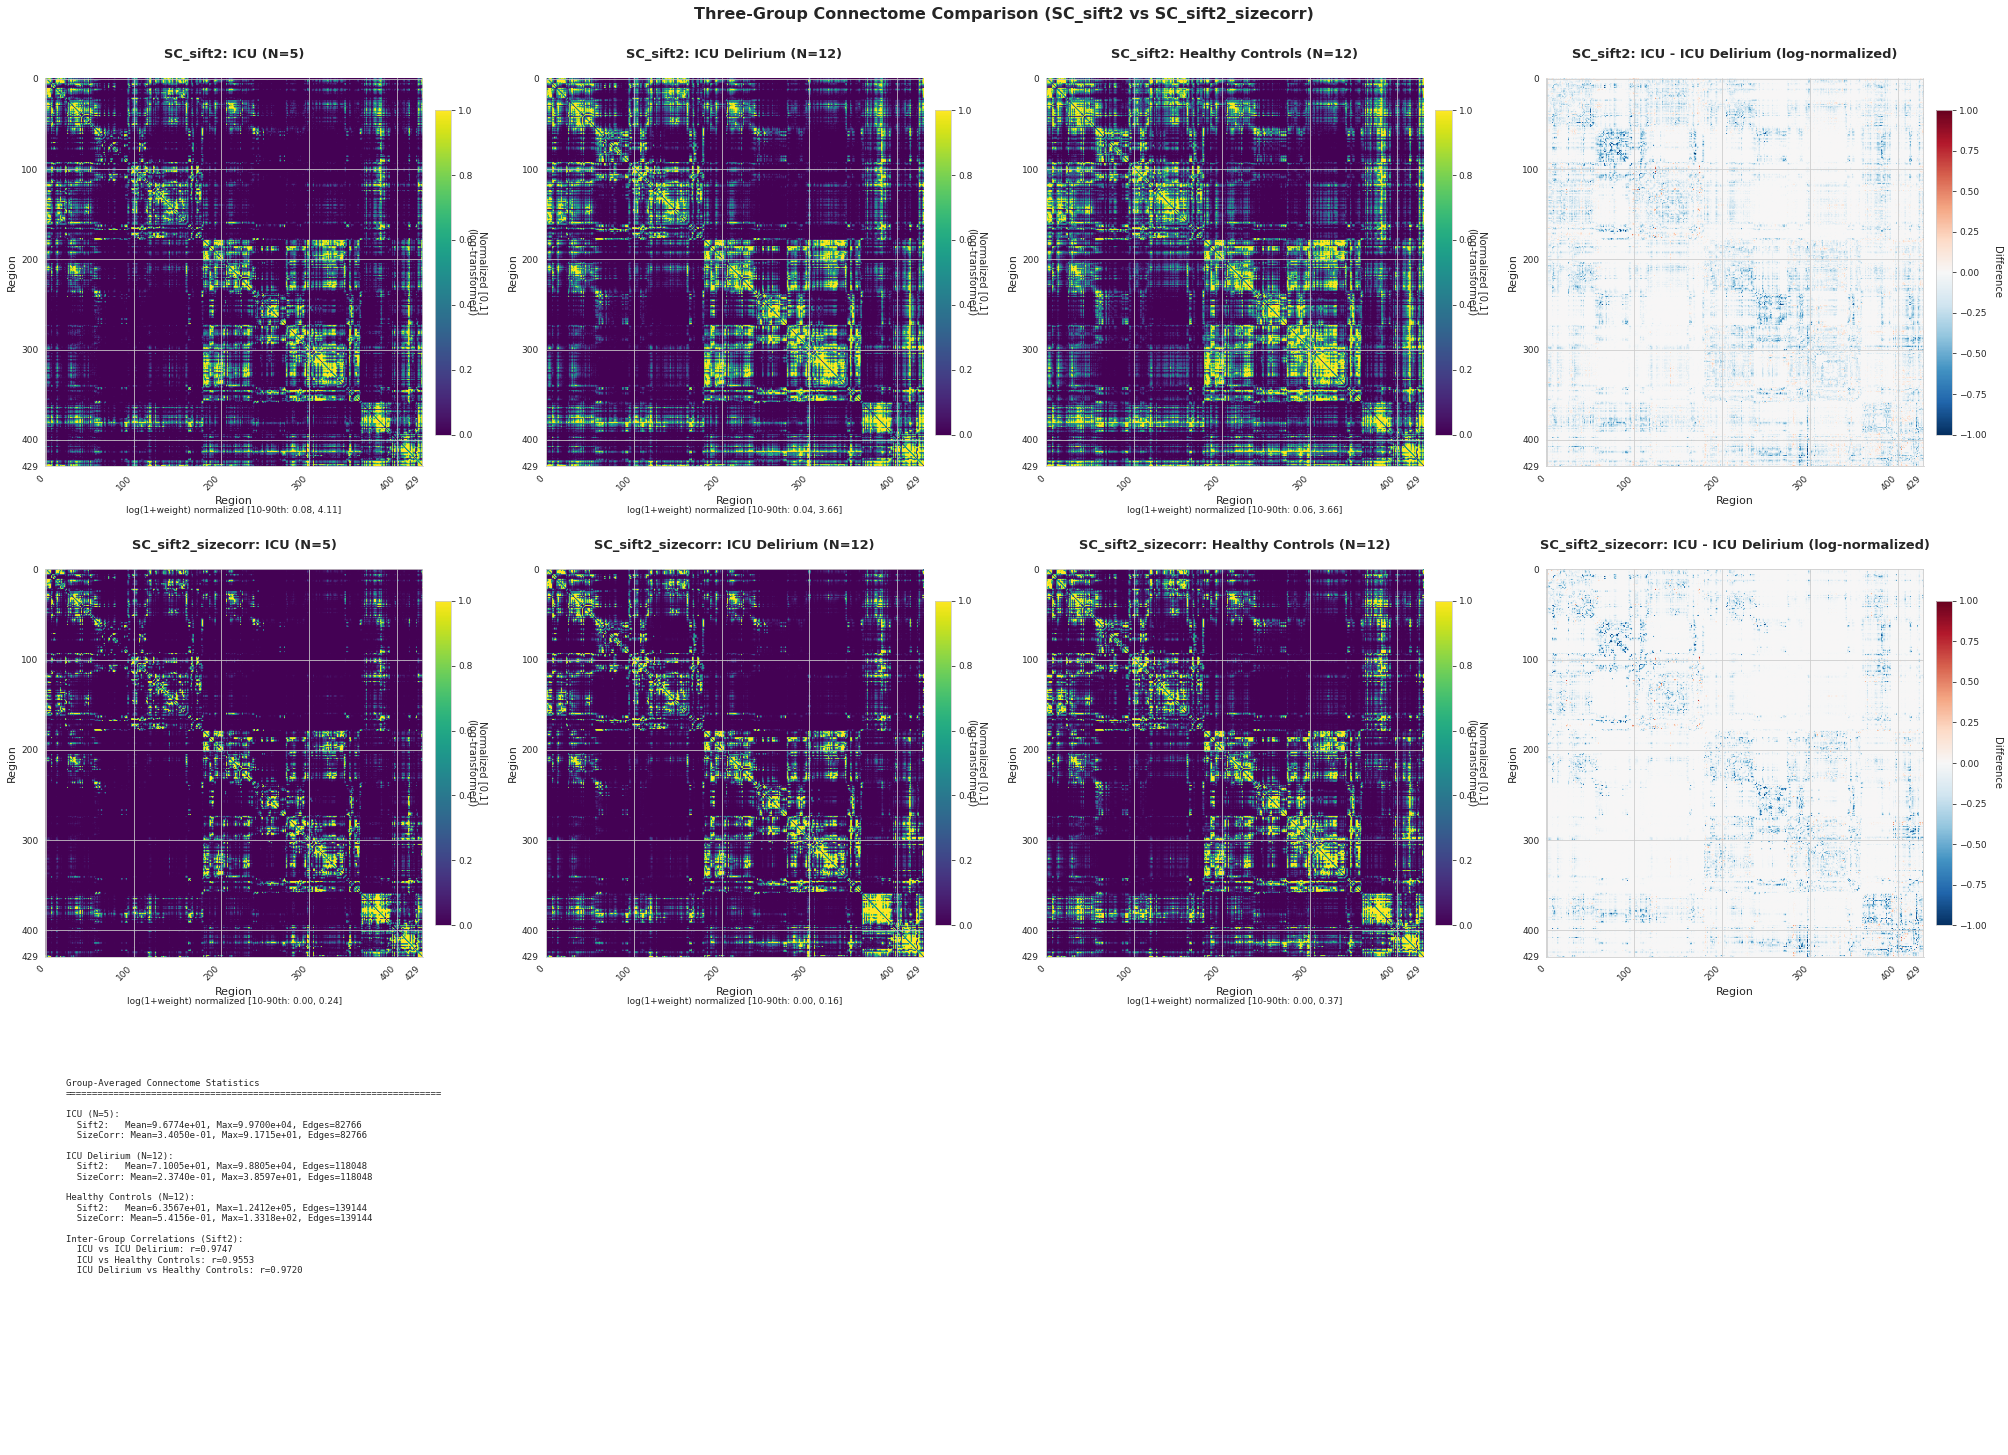


Analysis complete!


In [16]:

# Visualization
fig, axes = plt.subplots(3, 4, figsize=(28, 21))

# Common parameters
cbar_fraction = 0.04
cbar_pad = 0.03
cbar_labelpad = 15
cbar_labelsize = 10
cbar_ticksize = 9

# Helper function for axis ticks 
def set_axis_ticks(ax, n_regions, tick_interval=100, fontsize=9, x_rotation=45):
    tick_locations = np.arange(0, n_regions, tick_interval)
    if tick_locations[-1] != n_regions - 1:
        tick_locations = np.append(tick_locations, n_regions - 1)
    if len(tick_locations) > 7:
        key_indices = [0, len(tick_locations)//4, len(tick_locations)//2, 
                      3*len(tick_locations)//4, -1]
        tick_locations = tick_locations[key_indices]
    ax.set_xticks(tick_locations)
    ax.set_yticks(tick_locations)
    ax.set_xticklabels(tick_locations, fontsize=fontsize, rotation=x_rotation, ha='right')
    ax.set_yticklabels(tick_locations, fontsize=fontsize, rotation=0)

group_names = list(GROUPS.keys())

# Row 1: Sift2 group averages (log-normalized)
for i, group_name in enumerate(group_names):
    if group_name in sift2_groups:
        avg = sift2_groups[group_name]['average']
        norm, p_low, p_high = normalize_log(avg, (10, 90))
        
        im = axes[0, i].imshow(norm, cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[0, i].set_title(f'SC_sift2: {group_name} (N={sift2_groups[group_name]["n"]})', 
                           fontsize=13, fontweight='bold', pad=20)
        axes[0, i].text(0.5, -0.12, f'log(1+weight) normalized [10-90th: {p_low:.2f}, {p_high:.2f}]', 
                       transform=axes[0, i].transAxes, ha='center', fontsize=9)
        axes[0, i].set_xlabel('Region', fontsize=11)
        axes[0, i].set_ylabel('Region', fontsize=11)
        set_axis_ticks(axes[0, i], n_regions=norm.shape[0], tick_interval=100, 
                      fontsize=9, x_rotation=45)
        cbar = plt.colorbar(im, ax=axes[0, i], fraction=cbar_fraction, pad=cbar_pad)
        cbar.set_label('Normalized [0,1]\n(log-transformed)', labelpad=cbar_labelpad, 
                      fontsize=cbar_labelsize, rotation=270)
        cbar.ax.tick_params(labelsize=cbar_ticksize)
    else:
        axes[0, i].axis('off')

# Difference plot (Group1 - Group2) for Sift2 (log-normalized)
if len(group_names) >= 2 and all(g in sift2_groups for g in group_names[:2]):
    diff = (normalize_log(sift2_groups[group_names[0]]['average'])[0] - 
            normalize_log(sift2_groups[group_names[1]]['average'])[0])
    vmax = np.max(np.abs(diff)) if np.max(np.abs(diff)) > 0 else 1.0
    im = axes[0, 3].imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
    axes[0, 3].set_title(f'SC_sift2: {group_names[0]} - {group_names[1]} (log-normalized)', 
                       fontsize=13, fontweight='bold', pad=20)
    axes[0, 3].set_xlabel('Region', fontsize=11)
    axes[0, 3].set_ylabel('Region', fontsize=11)
    set_axis_ticks(axes[0, 3], n_regions=diff.shape[0], tick_interval=100, 
                  fontsize=9, x_rotation=45)
    cbar = plt.colorbar(im, ax=axes[0, 3], fraction=cbar_fraction, pad=cbar_pad)
    cbar.set_label('Difference', labelpad=cbar_labelpad, 
                  fontsize=cbar_labelsize, rotation=270)
    cbar.ax.tick_params(labelsize=cbar_ticksize)
else:
    axes[0, 3].axis('off')

# Row 2: SizeCorr group averages (log-normalized)
for i, group_name in enumerate(group_names):
    if group_name in sizecorr_groups:
        avg = sizecorr_groups[group_name]['average']
        norm, p_low, p_high = normalize_log(avg, (10, 90))
        
        im = axes[1, i].imshow(norm, cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[1, i].set_title(f'SC_sift2_sizecorr: {group_name} (N={sizecorr_groups[group_name]["n"]})', 
                           fontsize=13, fontweight='bold', pad=20)
        axes[1, i].text(0.5, -0.12, f'log(1+weight) normalized [10-90th: {p_low:.2f}, {p_high:.2f}]', 
                       transform=axes[1, i].transAxes, ha='center', fontsize=9)
        axes[1, i].set_xlabel('Region', fontsize=11)
        axes[1, i].set_ylabel('Region', fontsize=11)
        set_axis_ticks(axes[1, i], n_regions=norm.shape[0], tick_interval=100, 
                      fontsize=9, x_rotation=45)
        cbar = plt.colorbar(im, ax=axes[1, i], fraction=cbar_fraction, pad=cbar_pad)
        cbar.set_label('Normalized [0,1]\n(log-transformed)', labelpad=cbar_labelpad, 
                      fontsize=cbar_labelsize, rotation=270)
        cbar.ax.tick_params(labelsize=cbar_ticksize)
    else:
        axes[1, i].axis('off')

# Difference plot (Group1 - Group2) for SizeCorr (log-normalized)
if len(group_names) >= 2 and all(g in sizecorr_groups for g in group_names[:2]):
    diff = (normalize_log(sizecorr_groups[group_names[0]]['average'])[0] - 
            normalize_log(sizecorr_groups[group_names[1]]['average'])[0])
    vmax = np.max(np.abs(diff)) if np.max(np.abs(diff)) > 0 else 1.0
    im = axes[1, 3].imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
    axes[1, 3].set_title(f'SC_sift2_sizecorr: {group_names[0]} - {group_names[1]} (log-normalized)', 
                       fontsize=13, fontweight='bold', pad=20)
    axes[1, 3].set_xlabel('Region', fontsize=11)
    axes[1, 3].set_ylabel('Region', fontsize=11)
    set_axis_ticks(axes[1, 3], n_regions=diff.shape[0], tick_interval=100, 
                  fontsize=9, x_rotation=45)
    cbar = plt.colorbar(im, ax=axes[1, 3], fraction=cbar_fraction, pad=cbar_pad)
    cbar.set_label('Difference', labelpad=cbar_labelpad, 
                  fontsize=cbar_labelsize, rotation=270)
    cbar.ax.tick_params(labelsize=cbar_ticksize)
else:
    axes[1, 3].axis('off')

# Row 3: Statistics
axes[2, 0].axis('off')
axes[2, 1].axis('off')
axes[2, 2].axis('off')
axes[2, 3].axis('off')

# Compute statistics
stats_text = "Group-Averaged Connectome Statistics\n" + "="*70 + "\n\n"

for group_name in group_names:
    if group_name in sift2_groups and group_name in sizecorr_groups:
        sift2_avg = sift2_groups[group_name]['average']
        sizecorr_avg = sizecorr_groups[group_name]['average']
        
        sift2_nonzero = sift2_avg[sift2_avg > 0]
        sizecorr_nonzero = sizecorr_avg[sizecorr_avg > 0]
        
        stats_text += f"{group_name} (N={sift2_groups[group_name]['n']}):\n"
        stats_text += f"  Sift2:   Mean={np.mean(sift2_nonzero):.4e}, "
        stats_text += f"Max={np.max(sift2_avg):.4e}, "
        stats_text += f"Edges={len(sift2_nonzero)}\n"
        stats_text += f"  SizeCorr: Mean={np.mean(sizecorr_nonzero):.4e}, "
        stats_text += f"Max={np.max(sizecorr_avg):.4e}, "
        stats_text += f"Edges={len(sizecorr_nonzero)}\n\n"

# Inter-group correlations
if all(g in sift2_groups for g in group_names):
    triu_indices = np.triu_indices_from(sift2_groups[group_names[0]]['average'], k=1)
    
    stats_text += "Inter-Group Correlations (Sift2):\n"
    for i in range(len(group_names)):
        for j in range(i+1, len(group_names)):
            g1_flat = sift2_groups[group_names[i]]['average'][triu_indices]
            g2_flat = sift2_groups[group_names[j]]['average'][triu_indices]
            valid = (g1_flat > 0) & (g2_flat > 0)
            if np.sum(valid) > 0:
                corr = np.corrcoef(g1_flat[valid], g2_flat[valid])[0, 1]
                stats_text += f"  {group_names[i]} vs {group_names[j]}: r={corr:.4f}\n"

axes[2, 0].text(0.05, 0.95, stats_text, fontsize=9, family='monospace',
               verticalalignment='top', horizontalalignment='left',
               transform=axes[2, 0].transAxes)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97], h_pad=3.0, w_pad=2.0)
plt.suptitle('Three-Group Connectome Comparison (SC_sift2 vs SC_sift2_sizecorr)', 
            fontsize=16, fontweight='bold', y=0.99)

if 'DATA_DIR' in locals():
    plt.savefig(os.path.join(DATA_DIR, 'three_group_connectome_comparison.png'), 
               dpi=300, bbox_inches='tight')
    print(f"\nFigure saved: {os.path.join(DATA_DIR, 'three_group_connectome_comparison.png')}")

plt.show()

print("\nAnalysis complete!")




Figure saved: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/three_group_connectome_comparison_cmap.png


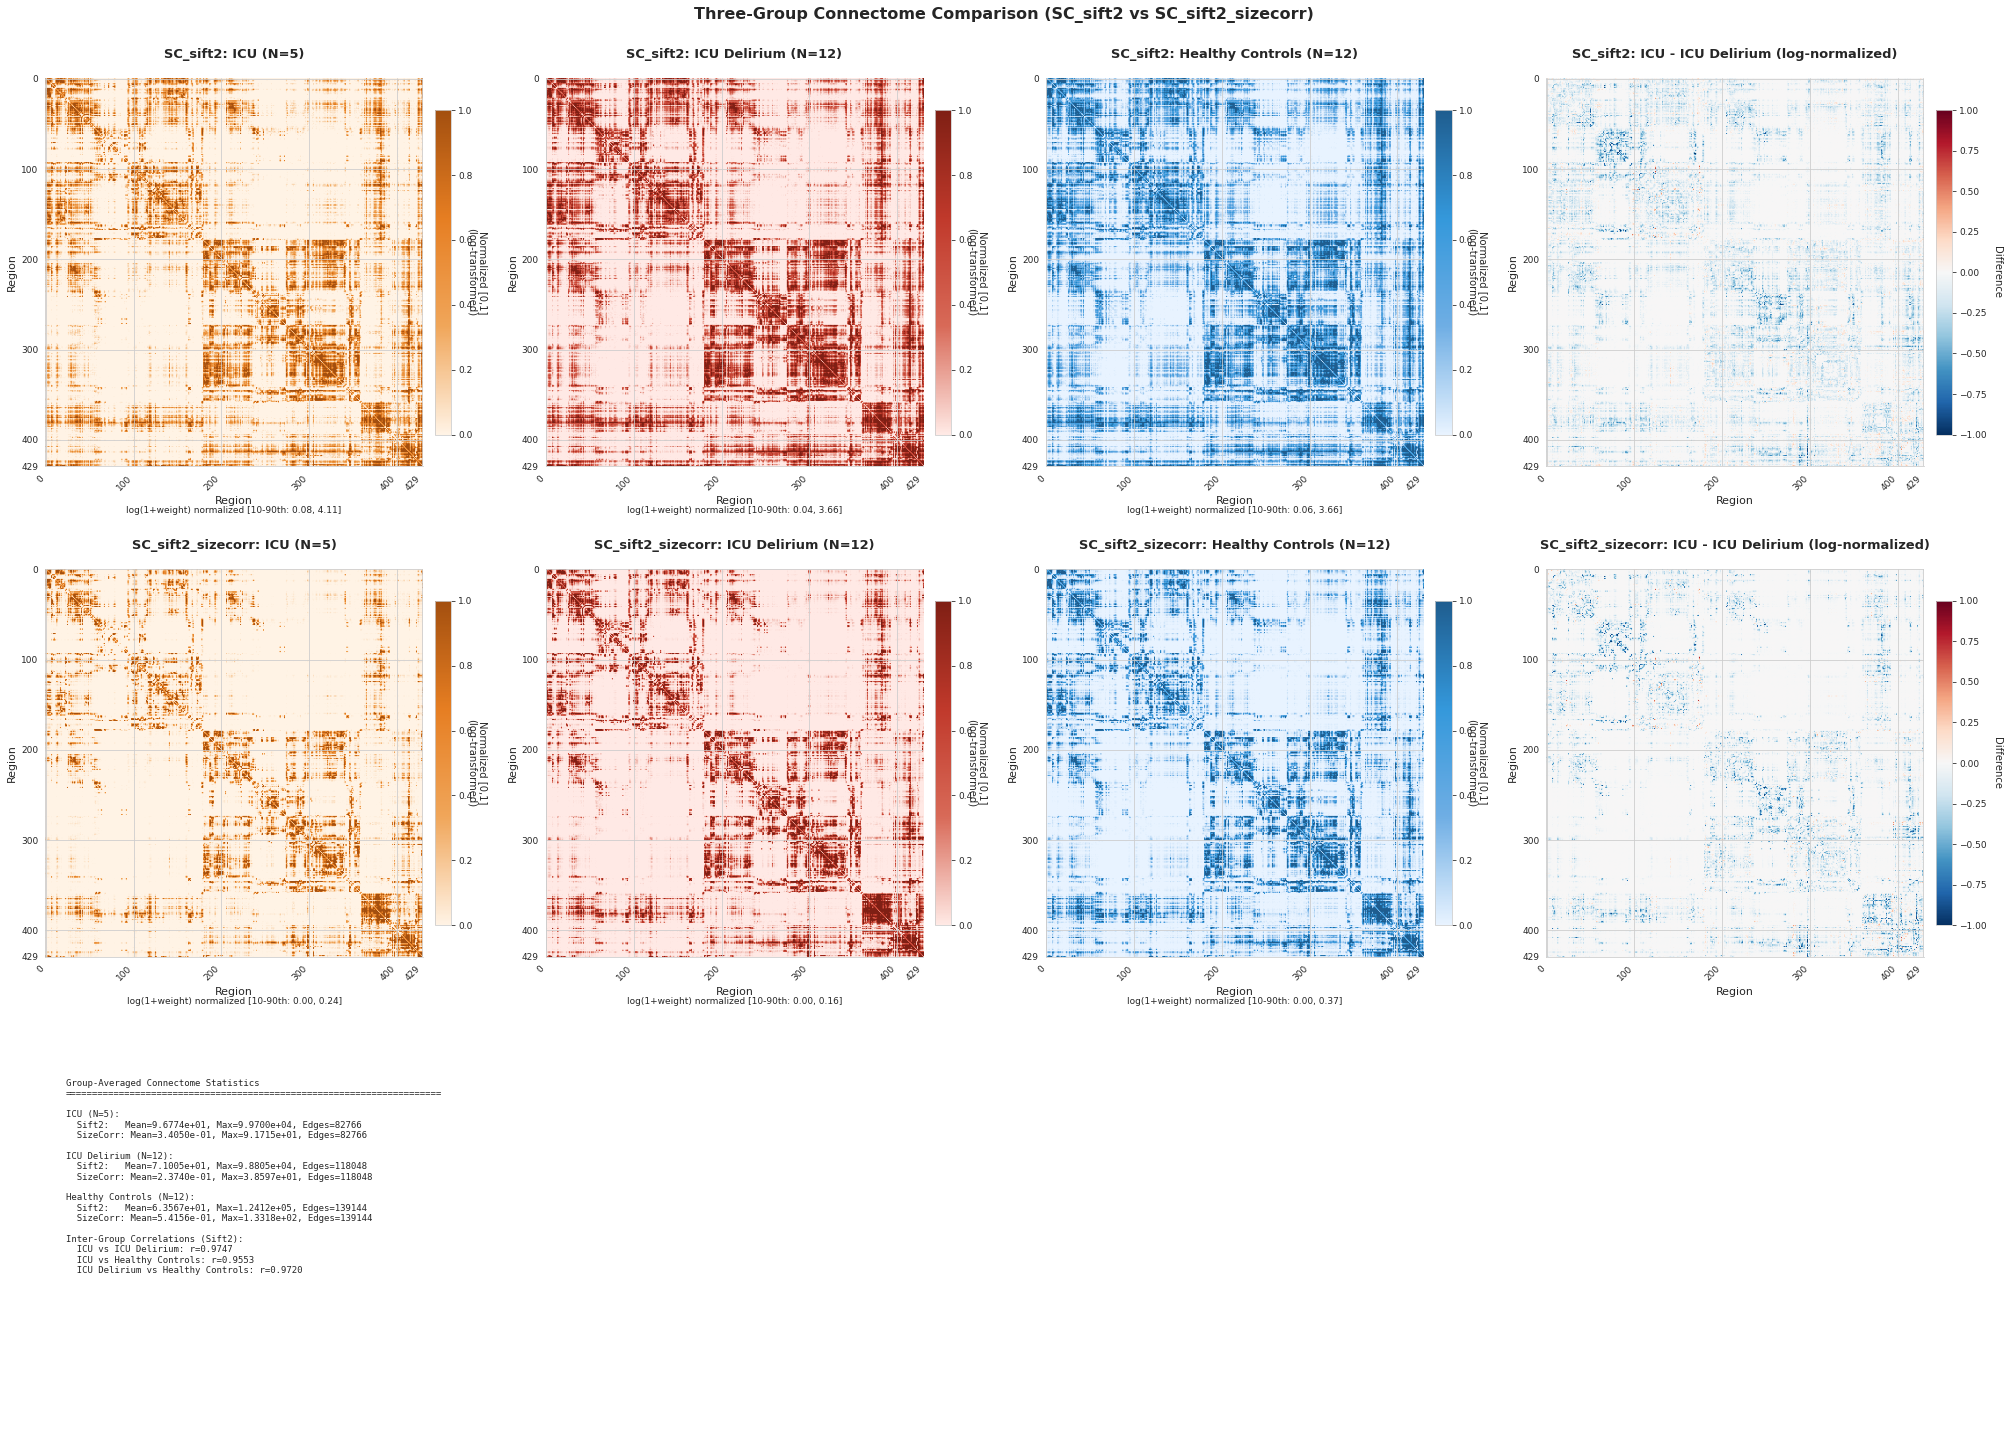


Analysis complete!


In [17]:
from utils.connectome_utils import get_group_cmap# Visualization
fig, axes = plt.subplots(3, 4, figsize=(28, 21))

# Common parameters
cbar_fraction = 0.04
cbar_pad = 0.03
cbar_labelpad = 15
cbar_labelsize = 10
cbar_ticksize = 9

# Helper function for axis ticks 
def set_axis_ticks(ax, n_regions, tick_interval=100, fontsize=9, x_rotation=45):
    tick_locations = np.arange(0, n_regions, tick_interval)
    if tick_locations[-1] != n_regions - 1:
        tick_locations = np.append(tick_locations, n_regions - 1)
    if len(tick_locations) > 7:
        key_indices = [0, len(tick_locations)//4, len(tick_locations)//2, 
                      3*len(tick_locations)//4, -1]
        tick_locations = tick_locations[key_indices]
    ax.set_xticks(tick_locations)
    ax.set_yticks(tick_locations)
    ax.set_xticklabels(tick_locations, fontsize=fontsize, rotation=x_rotation, ha='right')
    ax.set_yticklabels(tick_locations, fontsize=fontsize, rotation=0)

group_names = list(GROUPS.keys())

# Row 1: Sift2 group averages (log-normalized)
for i, group_name in enumerate(group_names):
    if group_name in sift2_groups:
        avg = sift2_groups[group_name]['average']
        norm, p_low, p_high = normalize_log(avg, (10, 90))
        
        im = axes[0, i].imshow(norm, cmap=get_group_cmap(group_name), aspect='auto', vmin=0, vmax=1)
        axes[0, i].set_title(f'SC_sift2: {group_name} (N={sift2_groups[group_name]["n"]})', 
                           fontsize=13, fontweight='bold', pad=20)
        axes[0, i].text(0.5, -0.12, f'log(1+weight) normalized [10-90th: {p_low:.2f}, {p_high:.2f}]', 
                       transform=axes[0, i].transAxes, ha='center', fontsize=9)
        axes[0, i].set_xlabel('Region', fontsize=11)
        axes[0, i].set_ylabel('Region', fontsize=11)
        set_axis_ticks(axes[0, i], n_regions=norm.shape[0], tick_interval=100, 
                      fontsize=9, x_rotation=45)
        cbar = plt.colorbar(im, ax=axes[0, i], fraction=cbar_fraction, pad=cbar_pad)
        cbar.set_label('Normalized [0,1]\n(log-transformed)', labelpad=cbar_labelpad, 
                      fontsize=cbar_labelsize, rotation=270)
        cbar.ax.tick_params(labelsize=cbar_ticksize)
    else:
        axes[0, i].axis('off')

# Difference plot (Group1 - Group2) for Sift2 (log-normalized)
if len(group_names) >= 2 and all(g in sift2_groups for g in group_names[:2]):
    diff = (normalize_log(sift2_groups[group_names[0]]['average'])[0] - 
            normalize_log(sift2_groups[group_names[1]]['average'])[0])
    vmax = np.max(np.abs(diff)) if np.max(np.abs(diff)) > 0 else 1.0
    im = axes[0, 3].imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
    axes[0, 3].set_title(f'SC_sift2: {group_names[0]} - {group_names[1]} (log-normalized)', 
                       fontsize=13, fontweight='bold', pad=20)
    axes[0, 3].set_xlabel('Region', fontsize=11)
    axes[0, 3].set_ylabel('Region', fontsize=11)
    set_axis_ticks(axes[0, 3], n_regions=diff.shape[0], tick_interval=100, 
                  fontsize=9, x_rotation=45)
    cbar = plt.colorbar(im, ax=axes[0, 3], fraction=cbar_fraction, pad=cbar_pad)
    cbar.set_label('Difference', labelpad=cbar_labelpad, 
                  fontsize=cbar_labelsize, rotation=270)
    cbar.ax.tick_params(labelsize=cbar_ticksize)
else:
    axes[0, 3].axis('off')

# Row 2: SizeCorr group averages (log-normalized)
for i, group_name in enumerate(group_names):
    if group_name in sizecorr_groups:
        avg = sizecorr_groups[group_name]['average']
        norm, p_low, p_high = normalize_log(avg, (10, 90))
        
        im = axes[1, i].imshow(norm, cmap=get_group_cmap(group_name), aspect='auto', vmin=0, vmax=1)
        axes[1, i].set_title(f'SC_sift2_sizecorr: {group_name} (N={sizecorr_groups[group_name]["n"]})', 
                           fontsize=13, fontweight='bold', pad=20)
        axes[1, i].text(0.5, -0.12, f'log(1+weight) normalized [10-90th: {p_low:.2f}, {p_high:.2f}]', 
                       transform=axes[1, i].transAxes, ha='center', fontsize=9)
        axes[1, i].set_xlabel('Region', fontsize=11)
        axes[1, i].set_ylabel('Region', fontsize=11)
        set_axis_ticks(axes[1, i], n_regions=norm.shape[0], tick_interval=100, 
                      fontsize=9, x_rotation=45)
        cbar = plt.colorbar(im, ax=axes[1, i], fraction=cbar_fraction, pad=cbar_pad)
        cbar.set_label('Normalized [0,1]\n(log-transformed)', labelpad=cbar_labelpad, 
                      fontsize=cbar_labelsize, rotation=270)
        cbar.ax.tick_params(labelsize=cbar_ticksize)
    else:
        axes[1, i].axis('off')

# Difference plot (Group1 - Group2) for SizeCorr (log-normalized)
if len(group_names) >= 2 and all(g in sizecorr_groups for g in group_names[:2]):
    diff = (normalize_log(sizecorr_groups[group_names[0]]['average'])[0] - 
            normalize_log(sizecorr_groups[group_names[1]]['average'])[0])
    vmax = np.max(np.abs(diff)) if np.max(np.abs(diff)) > 0 else 1.0
    im = axes[1, 3].imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
    axes[1, 3].set_title(f'SC_sift2_sizecorr: {group_names[0]} - {group_names[1]} (log-normalized)', 
                       fontsize=13, fontweight='bold', pad=20)
    axes[1, 3].set_xlabel('Region', fontsize=11)
    axes[1, 3].set_ylabel('Region', fontsize=11)
    set_axis_ticks(axes[1, 3], n_regions=diff.shape[0], tick_interval=100, 
                  fontsize=9, x_rotation=45)
    cbar = plt.colorbar(im, ax=axes[1, 3], fraction=cbar_fraction, pad=cbar_pad)
    cbar.set_label('Difference', labelpad=cbar_labelpad, 
                  fontsize=cbar_labelsize, rotation=270)
    cbar.ax.tick_params(labelsize=cbar_ticksize)
else:
    axes[1, 3].axis('off')

# Row 3: Statistics
axes[2, 0].axis('off')
axes[2, 1].axis('off')
axes[2, 2].axis('off')
axes[2, 3].axis('off')

# Compute statistics
stats_text = "Group-Averaged Connectome Statistics\n" + "="*70 + "\n\n"

for group_name in group_names:
    if group_name in sift2_groups and group_name in sizecorr_groups:
        sift2_avg = sift2_groups[group_name]['average']
        sizecorr_avg = sizecorr_groups[group_name]['average']
        
        sift2_nonzero = sift2_avg[sift2_avg > 0]
        sizecorr_nonzero = sizecorr_avg[sizecorr_avg > 0]
        
        stats_text += f"{group_name} (N={sift2_groups[group_name]['n']}):\n"
        stats_text += f"  Sift2:   Mean={np.mean(sift2_nonzero):.4e}, "
        stats_text += f"Max={np.max(sift2_avg):.4e}, "
        stats_text += f"Edges={len(sift2_nonzero)}\n"
        stats_text += f"  SizeCorr: Mean={np.mean(sizecorr_nonzero):.4e}, "
        stats_text += f"Max={np.max(sizecorr_avg):.4e}, "
        stats_text += f"Edges={len(sizecorr_nonzero)}\n\n"

# Inter-group correlations
if all(g in sift2_groups for g in group_names):
    triu_indices = np.triu_indices_from(sift2_groups[group_names[0]]['average'], k=1)
    
    stats_text += "Inter-Group Correlations (Sift2):\n"
    for i in range(len(group_names)):
        for j in range(i+1, len(group_names)):
            g1_flat = sift2_groups[group_names[i]]['average'][triu_indices]
            g2_flat = sift2_groups[group_names[j]]['average'][triu_indices]
            valid = (g1_flat > 0) & (g2_flat > 0)
            if np.sum(valid) > 0:
                corr = np.corrcoef(g1_flat[valid], g2_flat[valid])[0, 1]
                stats_text += f"  {group_names[i]} vs {group_names[j]}: r={corr:.4f}\n"

axes[2, 0].text(0.05, 0.95, stats_text, fontsize=9, family='monospace',
               verticalalignment='top', horizontalalignment='left',
               transform=axes[2, 0].transAxes)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97], h_pad=3.0, w_pad=2.0)
plt.suptitle('Three-Group Connectome Comparison (SC_sift2 vs SC_sift2_sizecorr)', 
            fontsize=16, fontweight='bold', y=0.99)

if 'DATA_DIR' in locals():
    plt.savefig(os.path.join(DATA_DIR, 'three_group_connectome_comparison_cmap.png'), 
               dpi=300, bbox_inches='tight')
    print(f"\nFigure saved: {os.path.join(DATA_DIR, 'three_group_connectome_comparison_cmap.png')}")

plt.show()

print("\nAnalysis complete!")




Figure saved: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/average_connectome_sizecorr_all_groups.png


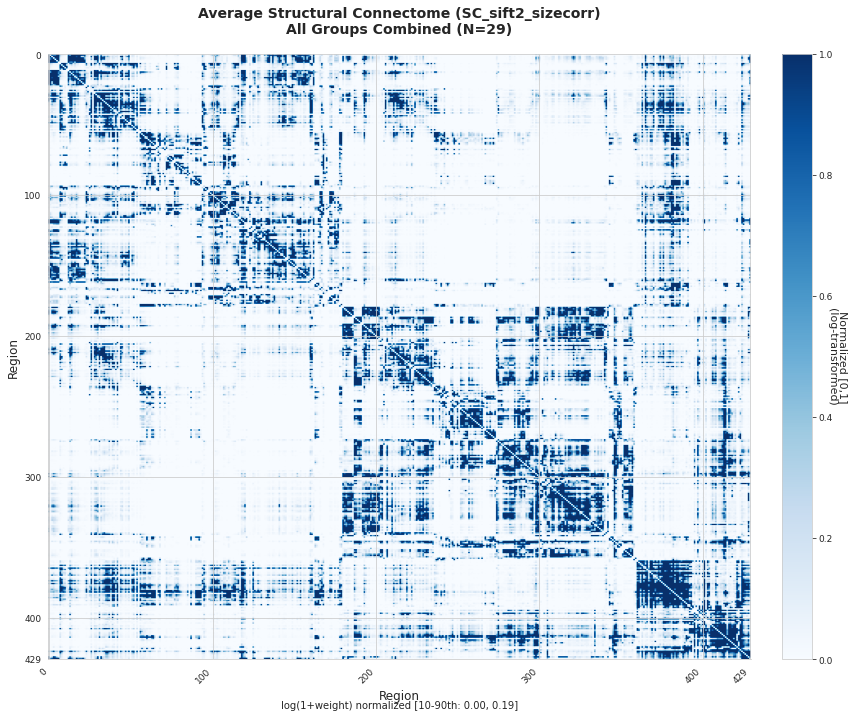


Analysis complete!


In [ ]:
# Compute overall average across all groups for size-corrected connectome
all_sizecorr_connectomes = []
for group_name in GROUPS.keys():
    if group_name in sizecorr_groups:
        all_sizecorr_connectomes.append(sizecorr_groups[group_name]['average'])

# Compute grand average across all groups
if len(all_sizecorr_connectomes) > 0:
    overall_avg = np.mean(all_sizecorr_connectomes, axis=0)
    total_n = sum(sizecorr_groups[g]['n'] for g in GROUPS.keys() if g in sizecorr_groups)
else:
    # Fallback: compute from all subjects directly
    from utils import compute_overall_average_connectome
    overall_avg, _ = compute_overall_average_connectome(
        preproc_dir=PREPROC_DIR,
        connectome_type="SC_sift2_sizecorr"
    )
    total_n = len([s for group in GROUPS.values() for s in group])

# Visualization - Single subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Normalize using log transformation
norm, p_low, p_high = normalize_log(overall_avg, (10, 90))

# Plot
im = ax.imshow(norm, cmap='Blues', aspect='auto', vmin=0, vmax=1)
ax.set_title(f'Average Structural Connectome (SC_sift2_sizecorr)\nAll Groups Combined (N={total_n})', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('ROI', fontsize=16)
ax.set_ylabel('ROI', fontsize=16)

# Set axis ticks
def set_axis_ticks(ax, n_regions, tick_interval=100, fontsize=13, x_rotation=45):
    tick_locations = np.arange(0, n_regions, tick_interval)
    if tick_locations[-1] != n_regions - 1:
        tick_locations = np.append(tick_locations, n_regions - 1)
    if len(tick_locations) > 7:
        key_indices = [0, len(tick_locations)//4, len(tick_locations)//2, 
                      3*len(tick_locations)//4, -1]
        tick_locations = tick_locations[key_indices]
    ax.set_xticks(tick_locations)
    ax.set_yticks(tick_locations)
    ax.set_xticklabels(tick_locations, fontsize=fontsize, rotation=x_rotation, ha='right')
    ax.set_yticklabels(tick_locations, fontsize=fontsize, rotation=0)

set_axis_ticks(ax, n_regions=norm.shape[0], tick_interval=100, fontsize=13, x_rotation=45)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Connectivity Strength', labelpad=15, 
              fontsize=15, rotation=270)
cbar.ax.tick_params(labelsize=13)

# Adjust layout
plt.tight_layout()

# Save if DATA_DIR is available
if 'DATA_DIR' in locals():
    save_path = os.path.join(DATA_DIR, 'average_connectome_sizecorr_all_groups.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nFigure saved: {save_path}")

plt.show()

print("\nAnalysis complete!")

In [19]:
# Statistical verification of size correction effect using non-parametric tests
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

print("="*80)
print("STATISTICAL VERIFICATION OF SIZE CORRECTION EFFECT")
print("="*80)
print("\nUsing non-parametric Wilcoxon signed-rank test (paired data)")
print("Comparing Sift2 (uncorrected) vs SizeCorr (corrected) connectomes\n")

# Extract edge weights for all subjects
subjects_with_both = [s for s in subjects if s in connectomes_uncorr and s in connectomes_corr]
print(f"N = {len(subjects_with_both)} subjects with both connectomes\n")

if len(subjects_with_both) > 0:
    # Get upper triangle indices (avoid diagonal and duplicates)
    n_regions = connectomes_uncorr[subjects_with_both[0]].shape[0]
    triu_indices = np.triu_indices(n_regions, k=1)
    n_edges = len(triu_indices[0])
    
    print(f"Connectome dimensions: {n_regions} × {n_regions} regions")
    print(f"Number of unique edges (upper triangle): {n_edges:,}\n")
    
    # Extract edge weights for all subjects
    sift2_edges = np.zeros((len(subjects_with_both), n_edges))
    sizecorr_edges = np.zeros((len(subjects_with_both), n_edges))
    
    for i, subj in enumerate(subjects_with_both):
        sift2_matrix = prepare_matrix(connectomes_uncorr[subj])
        sizecorr_matrix = prepare_matrix(connectomes_corr[subj])
        
        sift2_edges[i, :] = sift2_matrix[triu_indices]
        sizecorr_edges[i, :] = sizecorr_matrix[triu_indices]
    
    # ========================================================================
    # 1. Overall connectivity strength (mean edge weights)
    # ========================================================================
    print("1. OVERALL CONNECTIVITY STRENGTH")
    print("-" * 80)
    
    sift2_mean_edges = np.mean(sift2_edges, axis=1)  # Mean edge weight per subject
    sizecorr_mean_edges = np.mean(sizecorr_edges, axis=1)
    
    print(f"Sift2 (uncorrected):")
    print(f"  Mean: {np.mean(sift2_mean_edges):.4e} ± {np.std(sift2_mean_edges):.4e}")
    print(f"  Median: {np.median(sift2_mean_edges):.4e}")
    print(f"  Range: [{np.min(sift2_mean_edges):.4e}, {np.max(sift2_mean_edges):.4e}]")
    
    print(f"\nSizeCorr (corrected):")
    print(f"  Mean: {np.mean(sizecorr_mean_edges):.4e} ± {np.std(sizecorr_mean_edges):.4e}")
    print(f"  Median: {np.median(sizecorr_mean_edges):.4e}")
    print(f"  Range: [{np.min(sizecorr_mean_edges):.4e}, {np.max(sizecorr_mean_edges):.4e}]")
    
    # Wilcoxon signed-rank test
    differences = sizecorr_mean_edges - sift2_mean_edges
    if np.all(differences == 0):
        stat = np.nan
        pval = 1.0
        print(f"\nWilcoxon signed-rank test (two-sided):")
        print(f"  No differences detected (all values identical)")
        print(f"  ✗ Not testable (no variation)")
    else:
        try:
            stat, pval = wilcoxon(sift2_mean_edges, sizecorr_mean_edges, alternative='two-sided', zero_method='zsplit')
        except ValueError:
            # Fallback to 'wilcox' method
            try:
                stat, pval = wilcoxon(sift2_mean_edges, sizecorr_mean_edges, alternative='two-sided', zero_method='wilcox')
            except ValueError:
                # If still fails, all differences are zero
                stat = np.nan
                pval = 1.0
        
        print(f"\nWilcoxon signed-rank test (two-sided):")
        print(f"  W-statistic: {stat:.2f}")
        print(f"  p-value: {pval:.6f}")
        print(f"  {'Significant difference' if pval < 0.05 else '✗ No significant difference'} (α=0.05)")
    
    # Effect size (median difference)
    if not np.all(differences == 0):
        median_diff = np.median(differences)
        median_pct_change = 100 * median_diff / np.median(sift2_mean_edges) if np.median(sift2_mean_edges) > 0 else 0
        print(f"\nEffect size:")
        print(f"  Median difference: {median_diff:.4e}")
        print(f"  Median % change: {median_pct_change:.2f}%")
    else:
        median_diff = 0.0
        median_pct_change = 0.0
        print(f"\nEffect size:")
        print(f"  No differences detected")
    
    # ========================================================================
    # 2. Edge-level comparisons (with multiple comparison correction)
    # ========================================================================
    print("\n\n2. EDGE-LEVEL COMPARISONS")
    print("-" * 80)
    print("Testing each edge individually (with FDR correction for multiple comparisons)")
    
    # Test each edge
    edge_pvalues = []
    edge_statistics = []
    edge_median_diffs = []
    
    for edge_idx in range(n_edges):
        sift2_edge_vals = sift2_edges[:, edge_idx]
        sizecorr_edge_vals = sizecorr_edges[:, edge_idx]
        
        # Only test if there are non-zero values
        if np.sum(sift2_edge_vals > 0) > 0 or np.sum(sizecorr_edge_vals > 0) > 0:
            # Check if all differences are zero
            differences = sizecorr_edge_vals - sift2_edge_vals
            if np.all(differences == 0):
                edge_statistics.append(np.nan)
                edge_pvalues.append(1.0)
                edge_median_diffs.append(0.0)
            else:
                try:
                    stat, pval = wilcoxon(sift2_edge_vals, sizecorr_edge_vals, 
                                         alternative='two-sided', zero_method='zsplit')
                    edge_statistics.append(stat)
                    edge_pvalues.append(pval)
                    edge_median_diffs.append(np.median(differences))
                except ValueError:
                    # Try alternative zero_method if zsplit fails
                    try:
                        stat, pval = wilcoxon(sift2_edge_vals, sizecorr_edge_vals, 
                                             alternative='two-sided', zero_method='wilcox')
                        edge_statistics.append(stat)
                        edge_pvalues.append(pval)
                        edge_median_diffs.append(np.median(differences))
                    except ValueError:
                        # All zeros or identical values - skip test
                        edge_statistics.append(np.nan)
                        edge_pvalues.append(1.0)
                        edge_median_diffs.append(0.0)
        else:
            edge_statistics.append(np.nan)
            edge_pvalues.append(1.0)
            edge_median_diffs.append(0.0)
    
    edge_pvalues = np.array(edge_pvalues)
    edge_median_diffs = np.array(edge_median_diffs)
    
    # FDR correction
    valid_pvals = edge_pvalues[~np.isnan(edge_pvalues)]
    if len(valid_pvals) > 0:
        _, edge_pvalues_corrected, _, _ = multipletests(valid_pvals, method='fdr_bh', alpha=0.05)
        
        # Map back to full array
        edge_pvalues_fdr = np.full_like(edge_pvalues, np.nan)
        valid_mask = ~np.isnan(edge_pvalues)
        edge_pvalues_fdr[valid_mask] = edge_pvalues_corrected
        
        n_significant = np.sum(edge_pvalues_fdr < 0.05)
        pct_significant = 100 * n_significant / len(valid_pvals)
        
        print(f"\nResults:")
        print(f"  Total edges tested: {len(valid_pvals):,}")
        print(f"  Significant edges (FDR-corrected, α=0.05): {n_significant:,} ({pct_significant:.2f}%)")
        print(f"  Mean p-value (uncorrected): {np.nanmean(edge_pvalues):.6f}")
        print(f"  Mean p-value (FDR-corrected): {np.nanmean(edge_pvalues_fdr):.6f}")
        
        # Distribution of effect sizes for significant edges
        significant_mask = edge_pvalues_fdr < 0.05
        if np.sum(significant_mask) > 0:
            sig_diffs = edge_median_diffs[significant_mask]
            print(f"\nEffect sizes for significant edges:")
            print(f"  Median difference: {np.median(sig_diffs):.4e}")
            print(f"  Mean difference: {np.mean(sig_diffs):.4e}")
            print(f"  Range: [{np.min(sig_diffs):.4e}, {np.max(sig_diffs):.4e}]")
            print(f"  Edges with increased strength: {np.sum(sig_diffs > 0):,} ({100*np.sum(sig_diffs > 0)/len(sig_diffs):.1f}%)")
            print(f"  Edges with decreased strength: {np.sum(sig_diffs < 0):,} ({100*np.sum(sig_diffs < 0)/len(sig_diffs):.1f}%)")
    
    # ========================================================================
    # 3. Network-level metrics
    # ========================================================================
    print("\n\n3. NETWORK-LEVEL METRICS")
    print("-" * 80)
    
    # Calculate network-level metrics for each subject
    sift2_network_metrics = {
        'mean_strength': [],
        'total_strength': [],
        'density': [],
        'n_edges': []
    }
    sizecorr_network_metrics = {
        'mean_strength': [],
        'total_strength': [],
        'density': [],
        'n_edges': []
    }
    
    for i, subj in enumerate(subjects_with_both):
        sift2_vals = sift2_edges[i, :]
        sizecorr_vals = sizecorr_edges[i, :]
        
        # Mean strength (average of non-zero edges)
        sift2_nonzero = sift2_vals[sift2_vals > 0]
        sizecorr_nonzero = sizecorr_vals[sizecorr_vals > 0]
        
        sift2_network_metrics['mean_strength'].append(np.mean(sift2_nonzero) if len(sift2_nonzero) > 0 else 0)
        sizecorr_network_metrics['mean_strength'].append(np.mean(sizecorr_nonzero) if len(sizecorr_nonzero) > 0 else 0)
        
        # Total strength
        sift2_network_metrics['total_strength'].append(np.sum(sift2_vals))
        sizecorr_network_metrics['total_strength'].append(np.sum(sizecorr_vals))
        
        # Density (proportion of non-zero edges)
        sift2_network_metrics['density'].append(len(sift2_nonzero) / n_edges)
        sizecorr_network_metrics['density'].append(len(sizecorr_nonzero) / n_edges)
        
        # Number of edges
        sift2_network_metrics['n_edges'].append(len(sift2_nonzero))
        sizecorr_network_metrics['n_edges'].append(len(sizecorr_nonzero))
    
    # Convert to arrays
    for key in sift2_network_metrics:
        sift2_network_metrics[key] = np.array(sift2_network_metrics[key])
        sizecorr_network_metrics[key] = np.array(sizecorr_network_metrics[key])
    
    # Test each metric
    print("\nNetwork metric comparisons:")
    for metric_name in ['mean_strength', 'total_strength', 'density', 'n_edges']:
        sift2_vals = sift2_network_metrics[metric_name]
        sizecorr_vals = sizecorr_network_metrics[metric_name]
        
        # Check if all differences are zero
        differences = sizecorr_vals - sift2_vals
        if np.all(differences == 0):
            stat = np.nan
            pval = 1.0
            print(f"\n  {metric_name.replace('_', ' ').title()}:")
            print(f"    Sift2: {np.median(sift2_vals):.4e} | SizeCorr: {np.median(sizecorr_vals):.4e}")
            print(f"    No differences detected (all values identical)")
            print(f"    Not testable (no variation)")
        else:
            try:
                 stat, pval = wilcoxon(sift2_vals, sizecorr_vals, alternative='two-sided', zero_method='zsplit')
            except ValueError:
                 # Fallback if zero_method fails
                 try:
                     stat, pval = wilcoxon(sift2_vals, sizecorr_vals, alternative='two-sided', zero_method='wilcox')
                 except ValueError:
                     # If still fails, all differences are zero
                     stat = np.nan
                     pval = 1.0
            
            median_diff = np.median(differences)
            median_pct = 100 * median_diff / np.median(sift2_vals) if np.median(sift2_vals) > 0 else 0
            
            print(f"\n  {metric_name.replace('_', ' ').title()}:")
            print(f"    Sift2: {np.median(sift2_vals):.4e} | SizeCorr: {np.median(sizecorr_vals):.4e}")
            print(f"    W={stat:.2f}, p={pval:.6f} | Median diff: {median_diff:.4e} ({median_pct:+.2f}%)")
            print(f"    {' Significant' if pval < 0.05 else '✗ Not significant'}")
    
    
    # ========================================================================
    # 5. Summary
    # ========================================================================
    print("\n\n5. SUMMARY")
    print("="*80)
    print(f" Size correction shows {'significant' if pval < 0.05 else 'no significant'} effect on overall connectivity")
    print(f" {n_significant:,} edges ({pct_significant:.2f}%) show significant differences after FDR correction")
    print(f" Median connectivity change: {median_pct_change:+.2f}%")
    

else:
    print("No subjects with both connectomes available for comparison.")



STATISTICAL VERIFICATION OF SIZE CORRECTION EFFECT

Using non-parametric Wilcoxon signed-rank test (paired data)
Comparing Sift2 (uncorrected) vs SizeCorr (corrected) connectomes

N = 12 subjects with both connectomes

Connectome dimensions: 430 × 430 regions
Number of unique edges (upper triangle): 92,235

1. OVERALL CONNECTIVITY STRENGTH
--------------------------------------------------------------------------------
Sift2 (uncorrected):
  Mean: 4.7948e+01 ± 2.7144e+00
  Median: 4.8198e+01
  Range: [4.2929e+01, 5.2272e+01]

SizeCorr (corrected):
  Mean: 4.0849e-01 ± 3.6782e-02
  Median: 4.0059e-01
  Range: [3.4813e-01, 4.9902e-01]

Wilcoxon signed-rank test (two-sided):
  W-statistic: 0.00
  p-value: 0.000488
  Significant difference (α=0.05)

Effect size:
  Median difference: -4.7757e+01
  Median % change: -99.08%


2. EDGE-LEVEL COMPARISONS
--------------------------------------------------------------------------------
Testing each edge individually (with FDR correction for multip


Results:
  Total edges tested: 92,235
  Significant edges (FDR-corrected, α=0.05): 32,137 (34.84%)
  Mean p-value (uncorrected): 0.359491
  Mean p-value (FDR-corrected): 0.417861

Effect sizes for significant edges:
  Median difference: -3.4817e+00
  Mean difference: -1.1785e+02
  Range: [-1.1334e+05, -1.8013e-01]
  Edges with increased strength: 0 (0.0%)
  Edges with decreased strength: 32,137 (100.0%)


3. NETWORK-LEVEL METRICS
--------------------------------------------------------------------------------

Network metric comparisons:

  Mean Strength:
    Sift2: 1.2299e+02 | SizeCorr: 9.8752e-01
    W=0.00, p=0.000488 | Median diff: -1.2199e+02 (-99.19%)
     Significant

  Total Strength:
    Sift2: 4.4456e+06 | SizeCorr: 3.6948e+04
    W=0.00, p=0.000488 | Median diff: -4.4048e+06 (-99.08%)
     Significant

  Density:
    Sift2: 4.0085e-01 | SizeCorr: 4.0085e-01
    No differences detected (all values identical)
    Not testable (no variation)

  N Edges:
    Sift2: 3.6972e+04 

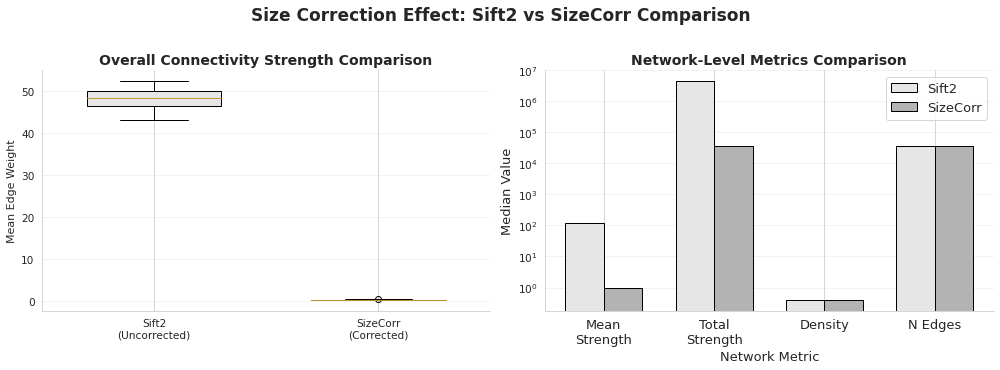


✓ Visualization complete


In [20]:
# ========================================================================
# VISUALIZATIONS FOR SIZE CORRECTION COMPARISON
# ========================================================================

if len(subjects_with_both) > 0:
    # Create figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Size Correction Effect: Sift2 vs SizeCorr Comparison', 
                 fontsize=17, fontweight='bold', y=1.02)
    
    # 1. Overall Connectivity Strength Comparison (Box Plot)
    ax1 = axes[0]
    data_to_plot = [sift2_mean_edges, sizecorr_mean_edges]
    bp = ax1.boxplot(data_to_plot, labels=['Sift2\n(Uncorrected)', 'SizeCorr\n(Corrected)'], 
                     patch_artist=True, widths=0.6)
    bp['boxes'][0].set_facecolor('0.9')
    bp['boxes'][1].set_facecolor('0.7')
    ax1.set_ylabel('Mean Edge Weight', fontsize=11)
    ax1.set_title('Overall Connectivity Strength Comparison', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add significance indicator
    if not np.isnan(stat) and pval < 0.05:
        y_max = max(np.max(sift2_mean_edges), np.max(sizecorr_mean_edges))
        ax1.plot([1, 2], [y_max * 1.05, y_max * 1.05], 'k-', lw=1.5)
        ax1.text(1.5, y_max * 1.08, f'p = {pval:.4f}', ha='center', fontsize=13, fontweight='bold')
    
    # 2. Network Metrics Comparison
    ax2 = axes[1]
    metrics_to_plot = ['mean_strength', 'total_strength', 'density', 'n_edges']
    metric_labels = ['Mean\nStrength', 'Total\nStrength', 'Density', 'N Edges']
    
    x_pos = np.arange(len(metrics_to_plot))
    width = 0.35
    
    sift2_medians = [np.median(sift2_network_metrics[m]) for m in metrics_to_plot]
    sizecorr_medians = [np.median(sizecorr_network_metrics[m]) for m in metrics_to_plot]
    
    bars1 = ax2.bar(x_pos - width/2, sift2_medians, width, label='Sift2', color='0.9', edgecolor='black')
    bars2 = ax2.bar(x_pos + width/2, sizecorr_medians, width, label='SizeCorr', color='0.7', edgecolor='black')
    
    ax2.set_xlabel('Network Metric', fontsize=13)
    ax2.set_ylabel('Median Value', fontsize=13)
    ax2.set_title('Network-Level Metrics Comparison', fontsize=14, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(metric_labels, fontsize=13)
    ax2.legend(fontsize=13)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_yscale('log')  # Log scale for better visualization
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Visualization complete")

CORTICAL VS SUBCORTICAL ROI ANALYSIS

Analyzing whether size correction affects cortical and subcortical connections differently
Cortical ROIs: 1-360 | Subcortical ROIs: 361-430

Group-averaged connectomes computed (N=12 subjects)
Connectome shape: (430, 430)

Edge classification:
  Cortical-Cortical: 64,620 edges
  Cortical-Subcortical: 25,200 edges
  Subcortical-Subcortical: 2,415 edges

STATISTICAL COMPARISONS

1. Size Correction Effect Within Each Edge Type:
--------------------------------------------------------------------------------

Cortical Cortical (N=48,953 edges):
  Sift2:     Mean=6.8655e+01, Median=8.8342e-01
  SizeCorr:  Mean=6.3298e-01, Median=9.8873e-03
  Difference: Mean=-6.8022e+01, Median=-8.7280e-01
  % Change:   Mean=-99.08%, Median=-98.80%
  Wilcoxon test: W=0.00, p=0.000000
  ✓ Significant difference (α=0.05)

Cortical Subcortical (N=18,568 edges):
  Sift2:     Mean=3.3321e+01, Median=8.5034e-01
  SizeCorr:  Mean=1.8748e-01, Median=1.5196e-02
  Difference: Mea


Figure saved: cortical_subcortical_size_correction_analysis.png


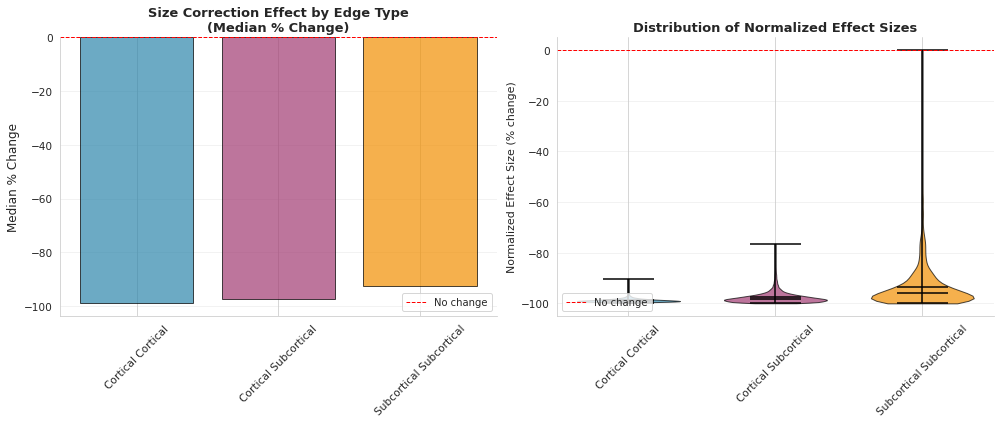



4. SUMMARY
Size correction effects by edge type:
  Cortical Cortical: -98.80% median change
  Cortical Subcortical: -97.41% median change
  Subcortical Subcortical: -92.53% median change

Analysis complete!


In [21]:
# Analysis: Cortical vs Subcortical ROI differences in size correction effect
print("="*80)
print("CORTICAL VS SUBCORTICAL ROI ANALYSIS")
print("="*80)
print("\nAnalyzing whether size correction affects cortical and subcortical connections differently")
print("Cortical ROIs: 1-360 | Subcortical ROIs: 361-430\n")

# Define ROI groups
CORTICAL_ROIS = set(range(1, 361))  # 1-360
SUBCORTICAL_ROIS = set(range(361, 431))  # 361-430

# Get group-averaged connectomes
if len(subjects_with_both) > 0:
    # Compute group-averaged connectomes for Sift2 and SizeCorr
    sift2_group_avg = np.mean(np.array([prepare_matrix(connectomes_uncorr[s]) 
                                        for s in subjects_with_both]), axis=0)
    sizecorr_group_avg = np.mean(np.array([prepare_matrix(connectomes_corr[s]) 
                                           for s in subjects_with_both]), axis=0)
    
    # Clean averages
    sift2_group_avg = np.nan_to_num(sift2_group_avg, nan=0.0, posinf=0.0, neginf=0.0)
    sizecorr_group_avg = np.nan_to_num(sizecorr_group_avg, nan=0.0, posinf=0.0, neginf=0.0)
    
    print(f"Group-averaged connectomes computed (N={len(subjects_with_both)} subjects)")
    print(f"Connectome shape: {sift2_group_avg.shape}\n")
    
    # Classify edges by ROI type
    n_regions = sift2_group_avg.shape[0]
    triu_indices = np.triu_indices(n_regions, k=1)
    
    edge_types = {
        'cortical_cortical': [],
        'cortical_subcortical': [],
        'subcortical_subcortical': []
    }
    
    # Classify each edge
    for edge_idx in range(len(triu_indices[0])):
        i, j = triu_indices[0][edge_idx], triu_indices[1][edge_idx]
        roi_i = i + 1  # Convert to 1-indexed
        roi_j = j + 1
        
        # Determine edge type
        if roi_i in CORTICAL_ROIS and roi_j in CORTICAL_ROIS:
            edge_type = 'cortical_cortical'
        elif (roi_i in CORTICAL_ROIS and roi_j in SUBCORTICAL_ROIS) or \
             (roi_i in SUBCORTICAL_ROIS and roi_j in CORTICAL_ROIS):
            edge_type = 'cortical_subcortical'
        elif roi_i in SUBCORTICAL_ROIS and roi_j in SUBCORTICAL_ROIS:
            edge_type = 'subcortical_subcortical'
        else:
            continue  # Skip if ROI not in expected range
        
        edge_types[edge_type].append(edge_idx)
    
    print("Edge classification:")
    print(f"  Cortical-Cortical: {len(edge_types['cortical_cortical']):,} edges")
    print(f"  Cortical-Subcortical: {len(edge_types['cortical_subcortical']):,} edges")
    print(f"  Subcortical-Subcortical: {len(edge_types['subcortical_subcortical']):,} edges")
    print()
    
    # Extract edge weights for each type
    edge_analysis = {}
    
    for edge_type, edge_indices in edge_types.items():
        sift2_vals = sift2_group_avg[triu_indices][edge_indices]
        sizecorr_vals = sizecorr_group_avg[triu_indices][edge_indices]
        
        # Filter to non-zero edges (at least in one version)
        nonzero_mask = (sift2_vals > 0) | (sizecorr_vals > 0)
        sift2_nonzero = sift2_vals[nonzero_mask]
        sizecorr_nonzero = sizecorr_vals[nonzero_mask]
        
        if len(sift2_nonzero) > 0:
            # Compute statistics
            differences = sizecorr_nonzero - sift2_nonzero
            
            edge_analysis[edge_type] = {
                'sift2': sift2_nonzero,
                'sizecorr': sizecorr_nonzero,
                'differences': differences,
                'n_edges': len(sift2_nonzero),
                'mean_sift2': np.mean(sift2_nonzero),
                'mean_sizecorr': np.mean(sizecorr_nonzero),
                'median_sift2': np.median(sift2_nonzero),
                'median_sizecorr': np.median(sizecorr_nonzero),
                'mean_diff': np.mean(differences),
                'median_diff': np.median(differences),
                'mean_pct_change': 100 * np.mean(differences) / np.mean(sift2_nonzero) if np.mean(sift2_nonzero) > 0 else 0,
                'median_pct_change': 100 * np.median(differences) / np.median(sift2_nonzero) if np.median(sift2_nonzero) > 0 else 0
            }
    
    # ========================================================================
    # Statistical comparisons
    # ========================================================================
    print("="*80)
    print("STATISTICAL COMPARISONS")
    print("="*80)
    
    # 1. Within each edge type: Sift2 vs SizeCorr
    print("\n1. Size Correction Effect Within Each Edge Type:")
    print("-" * 80)
    
    for edge_type in ['cortical_cortical', 'cortical_subcortical', 'subcortical_subcortical']:
        if edge_type in edge_analysis:
            data = edge_analysis[edge_type]
            sift2_vals = data['sift2']
            sizecorr_vals = data['sizecorr']
            differences = data['differences']
            
            print(f"\n{edge_type.replace('_', ' ').title()} (N={data['n_edges']:,} edges):")
            print(f"  Sift2:     Mean={data['mean_sift2']:.4e}, Median={data['median_sift2']:.4e}")
            print(f"  SizeCorr:  Mean={data['mean_sizecorr']:.4e}, Median={data['median_sizecorr']:.4e}")
            print(f"  Difference: Mean={data['mean_diff']:.4e}, Median={data['median_diff']:.4e}")
            print(f"  % Change:   Mean={data['mean_pct_change']:+.2f}%, Median={data['median_pct_change']:+.2f}%")
            
            # Wilcoxon signed-rank test (paired comparison)
            if not np.all(differences == 0):
                try:
                    stat, pval = wilcoxon(sift2_vals, sizecorr_vals, alternative='two-sided', zero_method='zsplit')
                    print(f"  Wilcoxon test: W={stat:.2f}, p={pval:.6f}")
                    print(f"  {'✓ Significant difference' if pval < 0.05 else '✗ No significant difference'} (α=0.05)")
                except ValueError:
                    try:
                        stat, pval = wilcoxon(sift2_vals, sizecorr_vals, alternative='two-sided', zero_method='wilcox')
                        print(f"  Wilcoxon test: W={stat:.2f}, p={pval:.6f}")
                        print(f"  {'✓ Significant difference' if pval < 0.05 else '✗ No significant difference'} (α=0.05)")
                    except ValueError:
                        print(f"  ✗ Cannot test (all differences zero)")
            else:
                print(f"  ✗ Cannot test (all differences zero)")
    
    # 2. Between edge types: Compare effect sizes
    print("\n\n2. Comparison of Effect Sizes Between Edge Types:")
    print("-" * 80)
    
    # Extract median percentage changes for comparison
    effect_sizes = {}
    for edge_type in ['cortical_cortical', 'cortical_subcortical', 'subcortical_subcortical']:
        if edge_type in edge_analysis:
            effect_sizes[edge_type] = edge_analysis[edge_type]['median_pct_change']
    
    if len(effect_sizes) >= 2:
        print("\nMedian % change comparison:")
        for edge_type, effect in effect_sizes.items():
            print(f"  {edge_type.replace('_', ' ').title()}: {effect:+.2f}%")
        
        # Compare cortical-cortical vs cortical-subcortical
        if 'cortical_cortical' in effect_sizes and 'cortical_subcortical' in effect_sizes:
            cc_effect = edge_analysis['cortical_cortical']['differences']
            cs_effect = edge_analysis['cortical_subcortical']['differences']
            
            # Normalize by baseline (Sift2) for fair comparison
            cc_normalized = cc_effect / (edge_analysis['cortical_cortical']['sift2'] + 1e-10)
            cs_normalized = cs_effect / (edge_analysis['cortical_subcortical']['sift2'] + 1e-10)
            
                         # Mann-Whitney U test (unpaired, non-parametric)
            try:
                 u_stat, pval = stats.mannwhitneyu(cc_normalized, cs_normalized, alternative='two-sided')
                 print(f"\n  Cortical-Cortical vs Cortical-Subcortical (normalized effect sizes):")
                 print(f"    Mann-Whitney U: U={u_stat:.2f}, p={pval:.6f}")
                 print(f"    {'✓ Significantly different' if pval < 0.05 else '✗ Not significantly different'} (α=0.05)")
            except ValueError:
                 print(f"\n  Cannot compare: insufficient variation")
         
         # Compare cortical-cortical vs subcortical-subcortical
        if 'cortical_cortical' in effect_sizes and 'subcortical_subcortical' in effect_sizes:
             cc_effect = edge_analysis['cortical_cortical']['differences']
             ss_effect = edge_analysis['subcortical_subcortical']['differences']
             
             cc_normalized = cc_effect / (edge_analysis['cortical_cortical']['sift2'] + 1e-10)
             ss_normalized = ss_effect / (edge_analysis['subcortical_subcortical']['sift2'] + 1e-10)
             
             try:
                 u_stat, pval = stats.mannwhitneyu(cc_normalized, ss_normalized, alternative='two-sided')
                 print(f"\n  Cortical-Cortical vs Subcortical-Subcortical (normalized effect sizes):")
                 print(f"    Mann-Whitney U: U={u_stat:.2f}, p={pval:.6f}")
                 print(f"    {'✓ Significantly different' if pval < 0.05 else '✗ Not significantly different'} (α=0.05)")
             except ValueError:
                 print(f"\n  Cannot compare: insufficient variation")
    
    # ========================================================================
    # Visualization
    # ========================================================================
    print("\n\n3. VISUALIZATION")
    print("-" * 80)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # Plot 1: Effect size comparison (median % change)
    edge_type_labels = [k.replace('_', ' ').title() for k in effect_sizes.keys()]
    effect_values = list(effect_sizes.values())
    
    axes[0].bar(edge_type_labels, effect_values, color=colors[:len(effect_values)], alpha=0.7, edgecolor='black')
    axes[0].axhline(0, color='r', linestyle='--', linewidth=1, label='No change')
    axes[0].set_ylabel('Median % Change', fontsize=12)
    axes[0].set_title('Size Correction Effect by Edge Type\n(Median % Change)', 
                     fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Violin plot of normalized effect sizes
    violin_data = []
    violin_labels = []
    for edge_type in ['cortical_cortical', 'cortical_subcortical', 'subcortical_subcortical']:
        if edge_type in edge_analysis:
            data = edge_analysis[edge_type]
            normalized_effects = data['differences'] / (data['sift2'] + 1e-10) * 100
            violin_data.append(normalized_effects)
            violin_labels.append(edge_type.replace('_', ' ').title())
    
    if len(violin_data) > 0:
        parts = axes[1].violinplot(violin_data, positions=range(len(violin_data)), 
                                   showmeans=True, showmedians=True, widths=0.7)
        
        # Customize violin plot colors
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i])
            pc.set_alpha(0.7)
            pc.set_edgecolor('black')
        
        # Customize other elements
        for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans', 'cmedians'):
            if partname in parts:
                parts[partname].set_edgecolor('black')
                parts[partname].set_linewidth(1.5)
        
        axes[1].set_xticks(range(len(violin_labels)))
        axes[1].set_xticklabels(violin_labels, rotation=45)
        axes[1].axhline(0, color='r', linestyle='--', linewidth=1, label='No change')
        axes[1].set_ylabel('Normalized Effect Size (% change)', fontsize=11)
        axes[1].set_title('Distribution of Normalized Effect Sizes', fontsize=13, fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if 'DATA_DIR' in locals():
        plt.savefig(os.path.join(DATA_DIR, 'cortical_subcortical_size_correction_analysis.png'), 
                   dpi=300, bbox_inches='tight')
        print(f"\nFigure saved: cortical_subcortical_size_correction_analysis.png")
    
    plt.show()
    
    # ========================================================================
    # Summary
    # ========================================================================
    print("\n\n4. SUMMARY")
    print("="*80)
    print("Size correction effects by edge type:")
    for edge_type, effect in effect_sizes.items():
        print(f"  {edge_type.replace('_', ' ').title()}: {effect:+.2f}% median change")
    print("\nAnalysis complete!")

else:
    print("No subjects available for analysis.")



# global network topology
of the structural connectome for signs of fragmentation or inefficiency in delirium patients.
Graph-theoretic measures like characteristic path length (the average shortest path between nodes) and global efficiency can quantify how well the brain network integrates information. For example, evidence from postoperative delirium studies shows that patients who developed delirium had a significantly increased characteristic path length in their preoperative structural networks (i.e. longer paths, indicating lower efficiency of the “physical network” connectivity)Consistently, a recent meta-analysis found that risk factors for delirium (such as advanced age) are associated with lower overall structural connectivity strength and a less efficient structural network organization

ANALYSIS 1: OVERALL CONNECTIVITY STRENGTH (WHOLE-BRAIN)

Investigating: Does the delirium group show reduced total white matter
connectivity compared to ICU and healthy controls?

Loaded Yeo7 mapping for 360 parcels
Cortical parcels (1-360): 360
Subcortical parcels (361-430): 0


ANALYZING: SC_sift2_sizecorr
CONNECTIVITY STRENGTH ANALYSIS: SC_sift2_sizecorr (whole_brain)

Loading connectomes of type: SC_sift2_sizecorr
✓ Loaded sub-AD: shape (430, 430)
✓ Loaded sub-AF: shape (430, 430)
✓ Loaded sub-AM: shape (430, 430)
✓ Loaded sub-AR: shape (430, 430)
✓ Loaded sub-BA: shape (430, 430)
✓ Loaded sub-CG: shape (430, 430)
✓ Loaded sub-DA: shape (430, 430)
✓ Loaded sub-DA2: shape (430, 430)
✓ Loaded sub-FD: shape (430, 430)
✓ Loaded sub-FEF: shape (430, 430)
✓ Loaded sub-FS: shape (430, 430)
✓ Loaded sub-FSE: shape (430, 430)
✓ Loaded sub-GB: shape (430, 430)
✓ Loaded sub-GL: shape (430, 430)
✓ Loaded sub-KJ: shape (430, 430)
✓ Loaded sub-LL: shape (430, 430)
✓ Loaded sub-MF: shape (430, 43

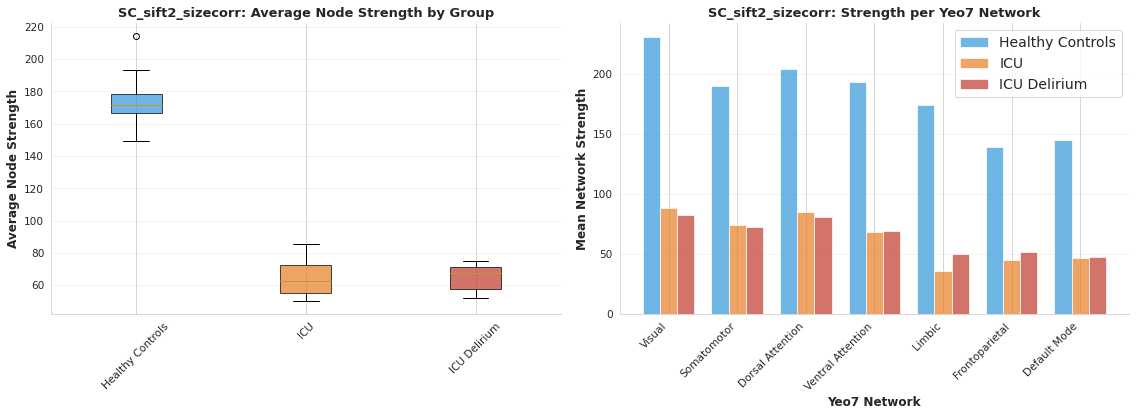

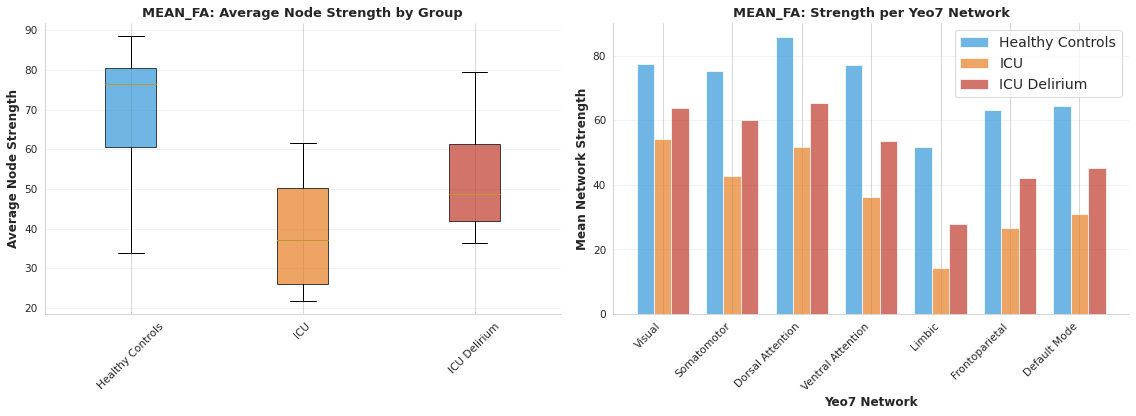

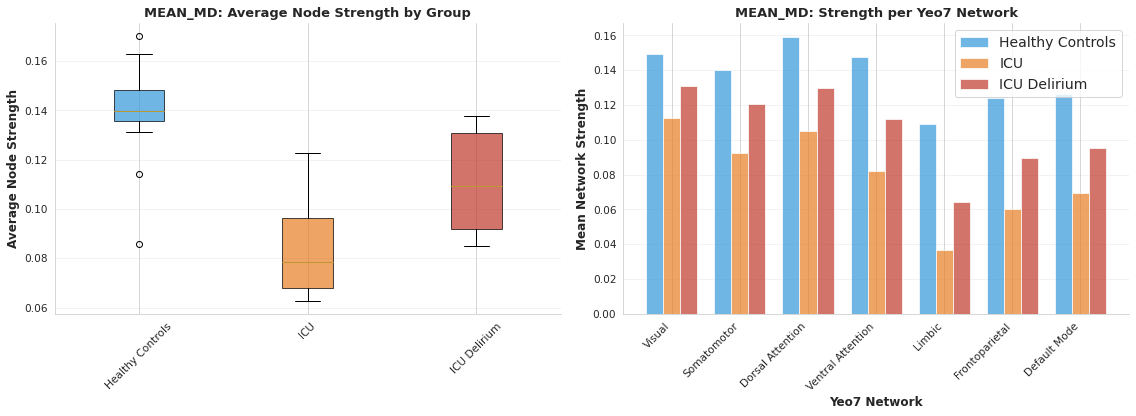

In [35]:
# ============================================================================
# GLOBAL NETWORK TOPOLOGY ANALYSIS
# ============================================================================
# Analysis 1: Overall Connectivity Strength (Whole-Brain)
# ============================================================================
# Investigated Topic: Does the delirium group show reduced total white matter 
# connectivity compared to ICU and healthy controls?
# ============================================================================

print("="*80)
print("ANALYSIS 1: OVERALL CONNECTIVITY STRENGTH (WHOLE-BRAIN)")
print("="*80)
print("\nInvestigating: Does the delirium group show reduced total white matter")
print("connectivity compared to ICU and healthy controls?\n")

# Load parcellation mappings using utility function
from utils import load_parcellation_mappings
parcel_to_yeo7, parcel_to_category = load_parcellation_mappings()

print(f"Loaded Yeo7 mapping for {len(parcel_to_yeo7)} parcels")
print(f"Cortical parcels (1-360): {sum(1 for p in parcel_to_yeo7 if 1 <= p <= 360)}")
print(f"Subcortical parcels (361-430): {sum(1 for p in parcel_to_yeo7 if 361 <= p <= 430)}")
print()

# Define groups (standardized naming: ICU, ICU Delirium, Healthy Controls)
GROUPS = {
    'ICU': ['AF','DA2','PM','BA'],
    'ICU Delirium': ['CG','DA','FS','FSE','GL','KJ','LL','MF','PMA','PO','PB','SA'],
    'Healthy Controls': ['FEF','FD','GB','SG','AR','TL','TOG','PL','ZM','AM','PC','AD']
}

# Define connectome types to analyze
CONNECTOME_TYPES_TO_ANALYZE = ['SC_sift2_sizecorr', 'MEAN_FA', 'MEAN_MD']

# Run analysis for each connectome type
results_analysis1 = {}

for connectome_type in CONNECTOME_TYPES_TO_ANALYZE:
    print("\n" + "="*80)
    print(f"ANALYZING: {connectome_type}")
    print("="*80)
    
    try:
        result = run_full_connectivity_analysis(
            preproc_dir=PREPROC_DIR,
            connectome_type=connectome_type,
            groups=GROUPS,
            region_type='whole_brain',
            save_dir=PREPROC_DIR / 'results',
            verbose=True,
            parcel_to_yeo7=parcel_to_yeo7
        )
        results_analysis1[connectome_type] = result
        print(f"\n✓ Completed analysis for {connectome_type}")
    except Exception as e:
        print(f"\n✗ Error analyzing {connectome_type}: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "="*80)
print("ANALYSIS 1 COMPLETE")
print("="*80)
print(f"Analyzed {len(results_analysis1)} connectome types:")
for ct in results_analysis1.keys():
    print(f"  - {ct}")


ANALYSIS 2: SUBCORTICAL CONNECTIVITY STRENGTH

Investigating: Does the delirium group show reduced subcortical white matter
connectivity compared to ICU and healthy controls?

Loaded subcortical category mapping for 70 parcels (361-430)

Subcortical category distribution:
  Amygdala: 2
  Basal Ganglia: 18
  Brainstem: 4
  Cerebellum: 2
  Other: 2
  Thalamus: 42


ANALYZING: SC_sift2_sizecorr
CONNECTIVITY STRENGTH ANALYSIS: SC_sift2_sizecorr (subcortical)

Loading connectomes of type: SC_sift2_sizecorr
✓ Loaded sub-AD: shape (430, 430)
✓ Loaded sub-AF: shape (430, 430)
✓ Loaded sub-AM: shape (430, 430)
✓ Loaded sub-AR: shape (430, 430)
✓ Loaded sub-BA: shape (430, 430)
✓ Loaded sub-CG: shape (430, 430)
✓ Loaded sub-DA: shape (430, 430)
✓ Loaded sub-DA2: shape (430, 430)
✓ Loaded sub-FD: shape (430, 430)
✓ Loaded sub-FEF: shape (430, 430)
✓ Loaded sub-FS: shape (430, 430)
✓ Loaded sub-FSE: shape (430, 430)
✓ Loaded sub-GB: shape (430, 430)
✓ Loaded sub-GL: shape (430, 430)
✓ Loaded sub-K

✓ Loaded sub-SA: shape (430, 430)
✓ Loaded sub-SG: shape (430, 430)
✓ Loaded sub-TL: shape (430, 430)
✓ Loaded sub-TOG: shape (430, 430)
✓ Loaded sub-VC: shape (430, 430)
✓ Loaded sub-ZM: shape (430, 430)

Successfully loaded 29 connectomes
Loaded 29 connectomes

Computing connectivity strength metrics (subcortical)...
Computed metrics for 28 subjects
Groups: {'ICU Delirium': 12, 'Healthy Controls': 12, 'ICU': 4}

STATISTICAL ANALYSIS


TOTAL SUBCORT STRENGTH
--------------------------------------------------------------------------------
ICU:
  Mean: 3.5038e+03 ± 7.4718e+02
  Median: 3.4886e+03
  Range: [2.6058e+03, 4.4322e+03]
  N: 4
ICU Delirium:
  Mean: 3.2343e+03 ± 5.4144e+02
  Median: 3.1384e+03
  Range: [2.0396e+03, 4.0817e+03]
  N: 12
Healthy Controls:
  Mean: 5.6259e+03 ± 1.4102e+03
  Median: 5.5215e+03
  Range: [3.7278e+03, 7.8148e+03]
  N: 12

Assumption checks for parametric ANOVA:
  ICU: Shapiro-Wilk p=0.527005 (normal)
  ICU Delirium: Shapiro-Wilk p=0.450182 (normal)
  He

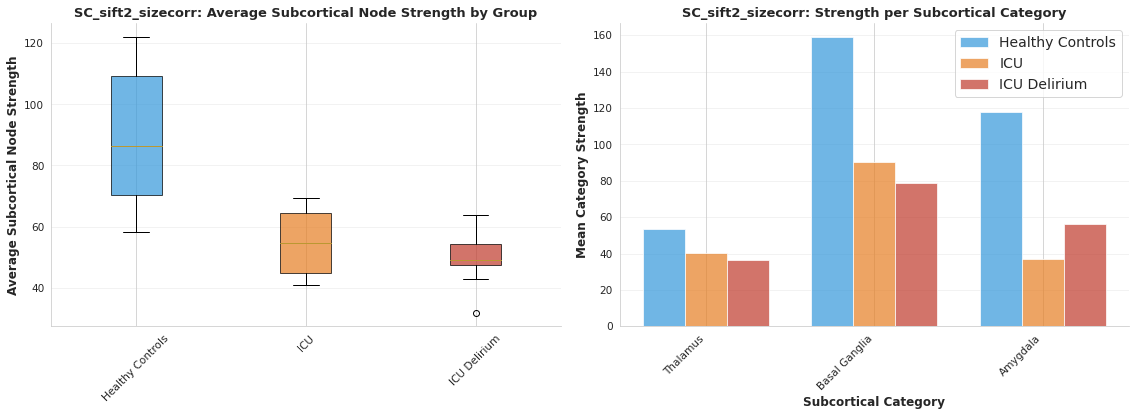

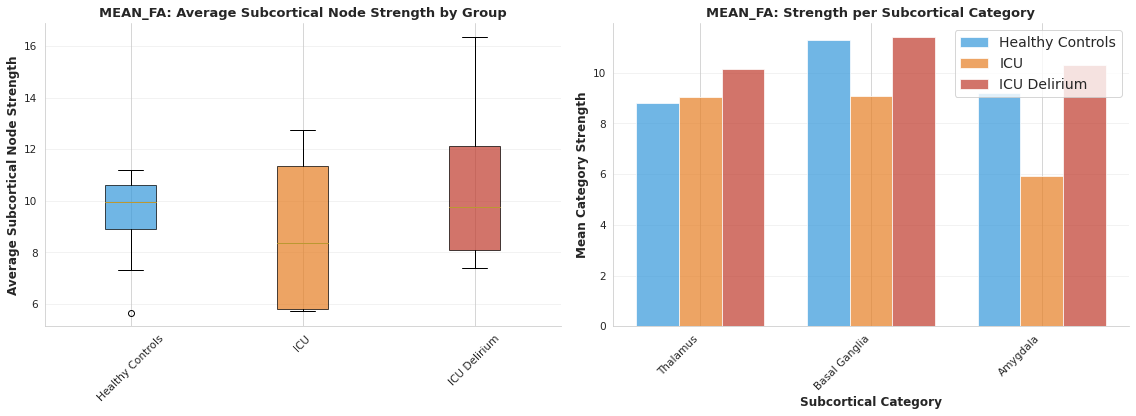

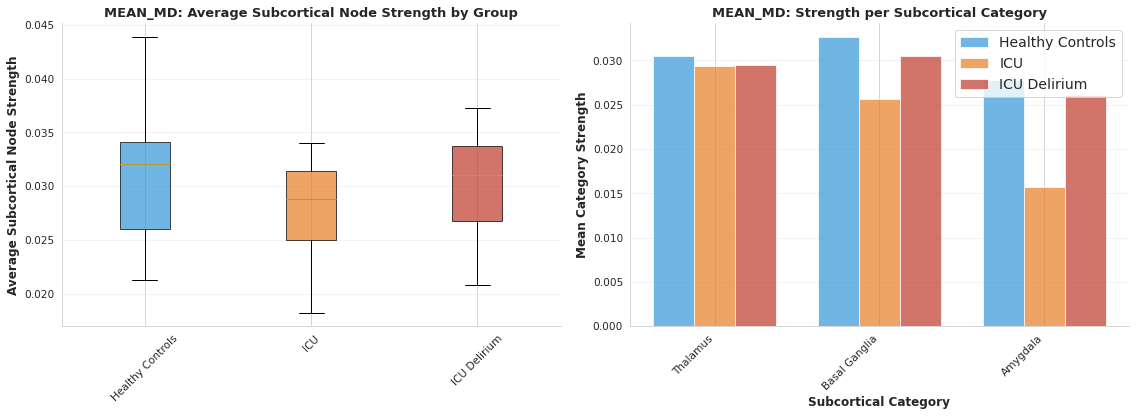

In [36]:
# ============================================================================

# ANALYSIS 2: SUBCORTICAL CONNECTIVITY STRENGTH

# ============================================================================

# Investigated Topic: Does the delirium group show reduced subcortical white matter 

# connectivity compared to ICU and healthy controls?

# ============================================================================


print("="*80)

print("ANALYSIS 2: SUBCORTICAL CONNECTIVITY STRENGTH")

print("="*80)

print("\nInvestigating: Does the delirium group show reduced subcortical white matter")

print("connectivity compared to ICU and healthy controls?\n")


# Load parcellation mappings using utility function

from utils import load_parcellation_mappings

parcel_to_yeo7, parcel_to_category = load_parcellation_mappings()


# Print category distribution

print(f"Loaded subcortical category mapping for {len([p for p in parcel_to_category if 361 <= p <= 430])} parcels (361-430)")

print("\nSubcortical category distribution:")

from collections import Counter

category_counts = Counter(parcel_to_category[p] for p in parcel_to_category if 361 <= p <= 430)

for cat, count in sorted(category_counts.items()):

    print(f"  {cat}: {count}")

print()


# Define groups (same as Analysis 1)

# Standardized group definitions (consistent naming: ICU, Delirium ICU, Healthy Controls)

GROUPS = {

    'ICU': ['AF','DA2','PM','BA'],

    'ICU Delirium': ['CG','DA','FS','FSE','GL','KJ','LL','MF','PMA','PO','PB','SA'],

    'Healthy Controls': ['FEF','FD','GB','SG','AR','TL','TOG','PL','ZM','AM','PC','AD']

}



# Define groups (standardized naming: ICU, ICU Delirium, Healthy Controls)

GROUPS = {

    'ICU': ['AF','DA2','PM','BA'],

    'ICU Delirium': ['CG','DA','FS','FSE','GL','KJ','LL','MF','PMA','PO','PB','SA'],

    'Healthy Controls': ['FEF','FD','GB','SG','AR','TL','TOG','PL','ZM','AM','PC','AD']

}


# Define connectome types to analyze

CONNECTOME_TYPES_TO_ANALYZE = ['SC_sift2_sizecorr', 'MEAN_FA', 'MEAN_MD']


# Run analysis for each connectome type

results_analysis2 = {}


for connectome_type in CONNECTOME_TYPES_TO_ANALYZE:

    print("\n" + "="*80)

    print(f"ANALYZING: {connectome_type}")

    print("="*80)

    

    try:

        result = run_full_connectivity_analysis(

            preproc_dir=PREPROC_DIR,

            connectome_type=connectome_type,

            groups=GROUPS,

            region_type='subcortical',

            save_dir=PREPROC_DIR / 'results',

            verbose=True,

            parcel_to_category=parcel_to_category

        )

        results_analysis2[connectome_type] = result

        print(f"\n✓ Completed analysis for {connectome_type}")

    except Exception as e:

        print(f"\n✗ Error analyzing {connectome_type}: {e}")

        import traceback

        traceback.print_exc()


print("\n" + "="*80)

print("ANALYSIS 2 COMPLETE")

print("="*80)

print(f"Analyzed {len(results_analysis2)} connectome types:")

for ct in results_analysis2.keys():

    print(f"  - {ct}")

In [37]:
pip install bctpy

Note: you may need to restart the kernel to use updated packages.


ANALYSIS 2: CHARACTERISTIC PATH LENGTH / GLOBAL EFFICIENCY

Investigating: Do delirium patients have longer path lengths and
reduced integration in their structural network compared to controls?



Using bctpy (Brain Connectivity Toolbox) for graph metrics

Loaded Yeo7 mapping for 430 parcels

Loaded 70 subcortical parcels (361-430)
Subcortical category distribution:
Amygdala          2
Basal Ganglia    10
Brainstem        14
Cerebellum        2
Thalamus         42
Name: category, dtype: int64


1. CORTICAL ANALYSIS (Whole-Brain)

--------------------------------------------------------------------------------
Analyzing: SC_sift2_sizecorr (Cortical)
--------------------------------------------------------------------------------
EFFICIENCY/PATH LENGTH ANALYSIS: SC_sift2_sizecorr (whole_brain)

Loading connectomes of type: SC_sift2_sizecorr
✓ Loaded sub-AD: shape (430, 430)
✓ Loaded sub-AF: shape (430, 430)
✓ Loaded sub-AM: shape (430, 430)
✓ Loaded sub-AR: shape (430, 430)
✓ Loaded sub-BA: shape (430, 430)
✓ Loaded sub-CG: shape (430, 430)
✓ Loaded sub-DA: shape (430, 430)
✓ Loaded sub-DA2: shape (430, 430)
✓ Loaded sub-FD: shape (430, 430)
✓ Loaded sub-FEF: shape (430, 430)
✓ Lo

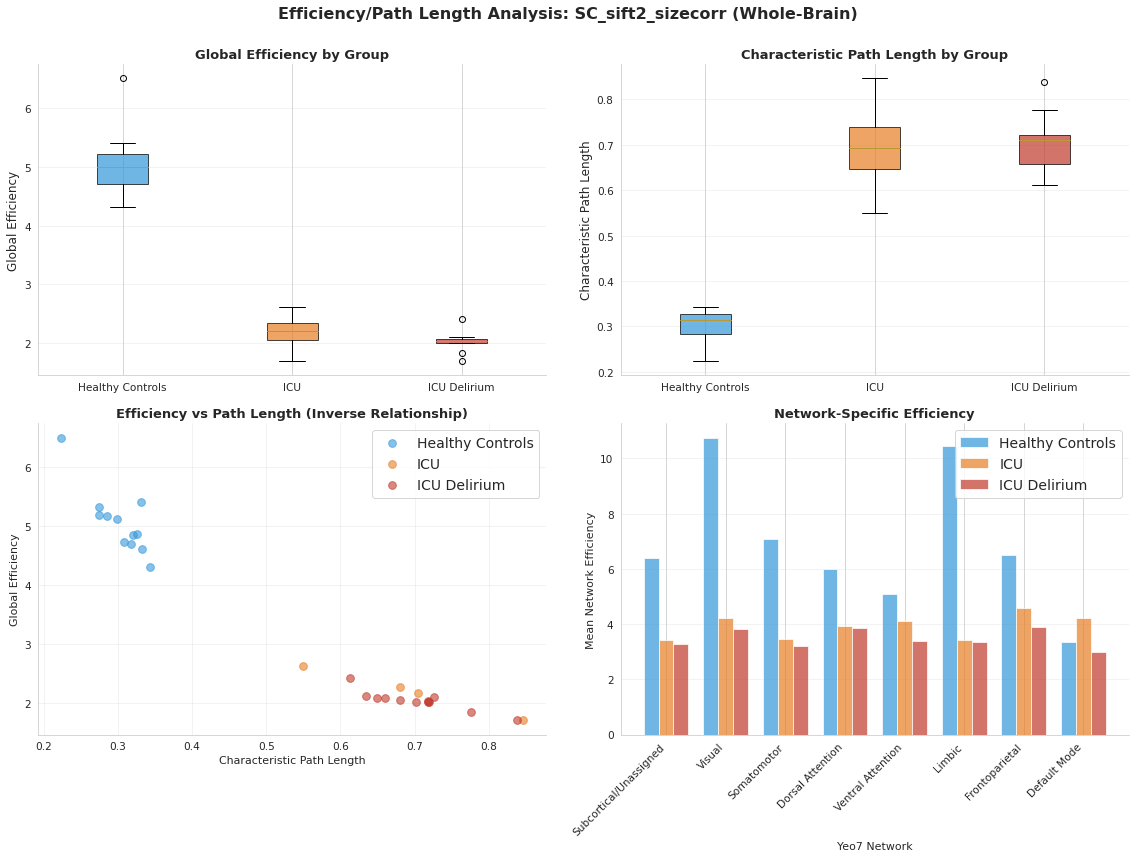

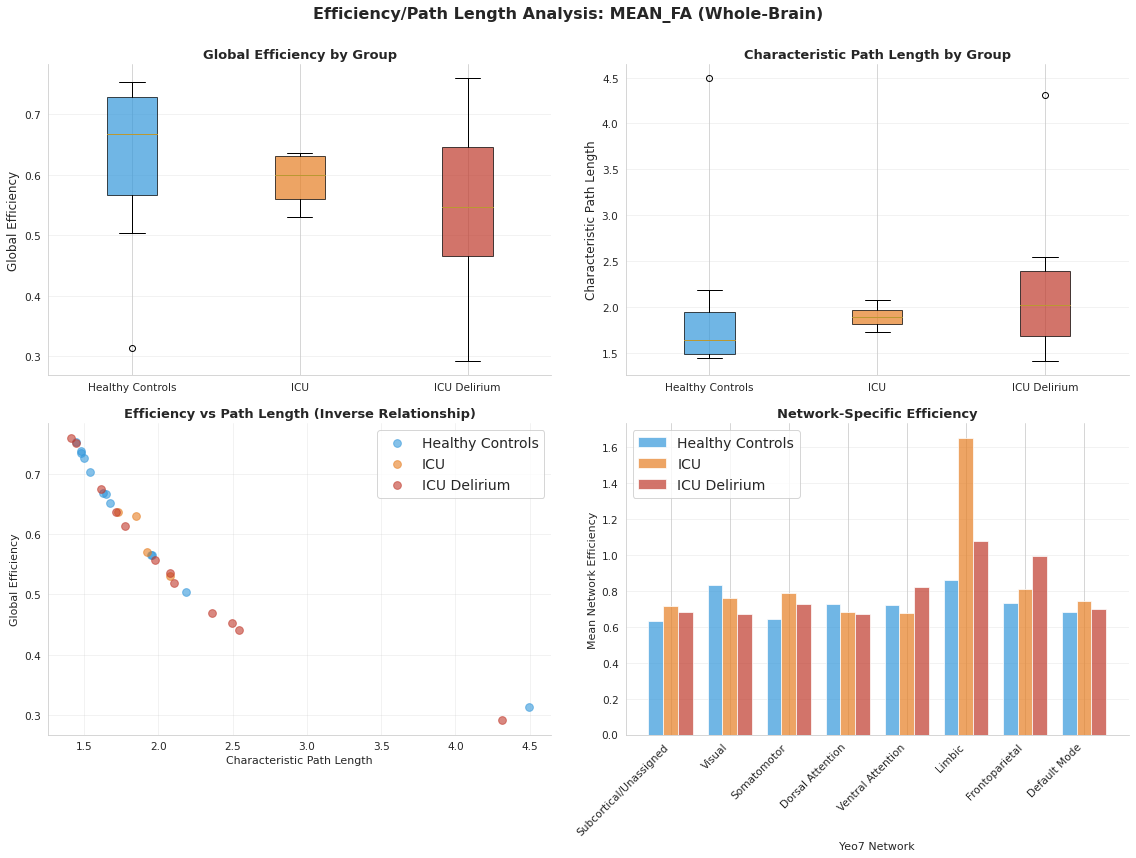

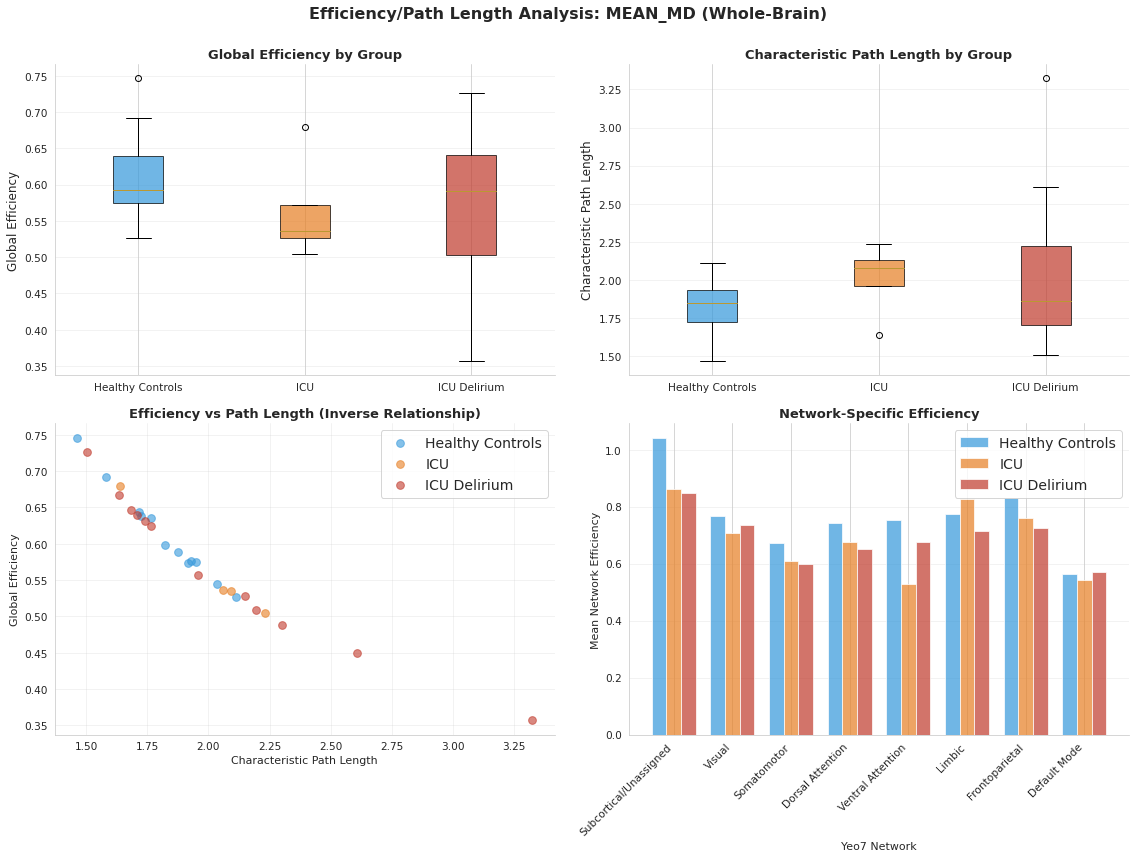

In [38]:
# ============================================================================
# ANALYSIS 2: CHARACTERISTIC PATH LENGTH / GLOBAL EFFICIENCY
# ============================================================================
# Investigated Topic: Do delirium patients have longer path lengths and 
# reduced integration in their structural network compared to controls?
# ============================================================================
# This analysis uses modular functions from utils to analyze multiple connectome types
# ============================================================================

print("="*80)
print("ANALYSIS 2: CHARACTERISTIC PATH LENGTH / GLOBAL EFFICIENCY")
print("="*80)
print("\nInvestigating: Do delirium patients have longer path lengths and")
print("reduced integration in their structural network compared to controls?\n")

# Try to import bctpy, fallback to networkx if not available
try:
    import bct
    USE_BCT = True
    print("Using bctpy (Brain Connectivity Toolbox) for graph metrics")
except ImportError:
    USE_BCT = False
    import networkx as nx
    print("bctpy not available, using NetworkX for graph metrics")
    print("Note: For more accurate brain network metrics, consider installing bctpy:")
    print("  pip install bctpy")

print()

# Define groups (standardized naming: ICU, ICU Delirium, Healthy Controls)
GROUPS = {
    'ICU': ['AF','DA2','PM','BA'],
    'ICU Delirium': ['CG','DA','FS','FSE','GL','KJ','LL','MF','PMA','PO','PB','SA'],
    'Healthy Controls': ['FEF','FD','GB','SG','AR','TL','TOG','PL','ZM','AM','PC','AD']
}

# Load Yeo7 network mapping for cortical analysis
yeo7_df = pd.read_csv(ATLAS_TO_YEO7_CSV)
parcel_to_yeo7 = {}
for _, row in yeo7_df.iterrows():
    parcel_id = int(row['parcel_id'])
    yeo7_network = int(row['yeo7_network']) if pd.notna(row['yeo7_network']) else 0
    parcel_to_yeo7[parcel_id] = yeo7_network

print(f"Loaded Yeo7 mapping for {len(parcel_to_yeo7)} parcels")
print()

# Load parcels labels Excel file for subcortical analysis
parcels_df = pd.read_excel(PARCELS_LABELS_XLSX)
subcort_df = parcels_df[(parcels_df['parcel_index'] >= 361) & (parcels_df['parcel_index'] <= 432)].copy()

# Create mapping function to categorize subcortical regions
def categorize_subcortical(area_desc):
    """
    Categorize subcortical regions into groups:
    - Thalamus: All thalamic nuclei
    - Basal Ganglia: Putamen, Caudate, NAc, Globus pallidus
    - Brainstem: SN, VTA, MB, Septum, Nucleus basalis, Brainstem
    - Amygdala: Amygdala
    - Cerebellum: Cerebellum
    """
    if pd.isna(area_desc):
        return "Unknown"
    
    area_desc = str(area_desc).lower()
    
    if "thalamus" in area_desc:
        return "Thalamus"
    elif any(x in area_desc for x in ["putamen", "caudate", "nucleus accumbens", "globus pallidus"]):
        return "Basal Ganglia"
    elif any(x in area_desc for x in ["substantia nigra", "ventral tegmental", "mammillary", 
                                       "septal", "nucleus basalis", "brainstem"]):
        return "Brainstem"
    elif "amygdala" in area_desc:
        return "Amygdala"
    elif "cerebellum" in area_desc or "cerebellar" in area_desc:
        return "Cerebellum"
    else:
        return "Other"

# Add category column
subcort_df['category'] = subcort_df['area_describtion'].apply(categorize_subcortical)

# Create mapping: parcel_index -> category
parcel_to_category = {}
for _, row in subcort_df.iterrows():
    parcel_id = int(row['parcel_index'])
    category = row['category']
    parcel_to_category[parcel_id] = category

print(f"Loaded {len(subcort_df)} subcortical parcels (361-430)")
print("Subcortical category distribution:")
print(subcort_df['category'].value_counts().sort_index())
print()

# Define connectome types to analyze
CONNECTOME_TYPES_TO_ANALYZE = ['SC_sift2_sizecorr', 'MEAN_FA', 'MEAN_MD']

# Analysis settings
TARGET_DENSITY = 0.15  # Keep top 15% of edges

# Storage for results
results_efficiency = {}

# ============================================================================
# 1. CORTICAL ANALYSIS (Whole-Brain)
# ============================================================================
print("\n" + "="*80)
print("1. CORTICAL ANALYSIS (Whole-Brain)")
print("="*80)

for connectome_type in CONNECTOME_TYPES_TO_ANALYZE:
    print("\n" + "-"*80)
    print(f"Analyzing: {connectome_type} (Cortical)")
    print("-"*80)
    
    try:
        result = run_full_efficiency_analysis(
            preproc_dir=PREPROC_DIR,
            connectome_type=connectome_type,
            groups=GROUPS,
            region_type='whole_brain',
            save_dir=PREPROC_DIR / 'results',
            target_density=TARGET_DENSITY,
            use_bct=USE_BCT,
            verbose=True,
            parcel_to_yeo7=parcel_to_yeo7
        )
        results_efficiency[f'{connectome_type}_cortical'] = result
        print(f"\n✓ Completed cortical analysis for {connectome_type}")
    except Exception as e:
        print(f"\n✗ Error analyzing cortical {connectome_type}: {e}")
        import traceback
        traceback.print_exc()



2. SUBCORTICAL ANALYSIS

--------------------------------------------------------------------------------
Analyzing: SC_sift2_sizecorr (Subcortical)
--------------------------------------------------------------------------------
EFFICIENCY/PATH LENGTH ANALYSIS: SC_sift2_sizecorr (subcortical)

Loading connectomes of type: SC_sift2_sizecorr
✓ Loaded sub-AD: shape (430, 430)
✓ Loaded sub-AF: shape (430, 430)
✓ Loaded sub-AM: shape (430, 430)
✓ Loaded sub-AR: shape (430, 430)
✓ Loaded sub-BA: shape (430, 430)
✓ Loaded sub-CG: shape (430, 430)
✓ Loaded sub-DA: shape (430, 430)
✓ Loaded sub-DA2: shape (430, 430)
✓ Loaded sub-FD: shape (430, 430)
✓ Loaded sub-FEF: shape (430, 430)
✓ Loaded sub-FS: shape (430, 430)
✓ Loaded sub-FSE: shape (430, 430)
✓ Loaded sub-GB: shape (430, 430)
✓ Loaded sub-GL: shape (430, 430)
✓ Loaded sub-KJ: shape (430, 430)
✓ Loaded sub-LL: shape (430, 430)
✓ Loaded sub-MF: shape (430, 430)
✓ Loaded sub-PB: shape (430, 430)
✓ Loaded sub-PC: shape (430, 430)
✓ Loade

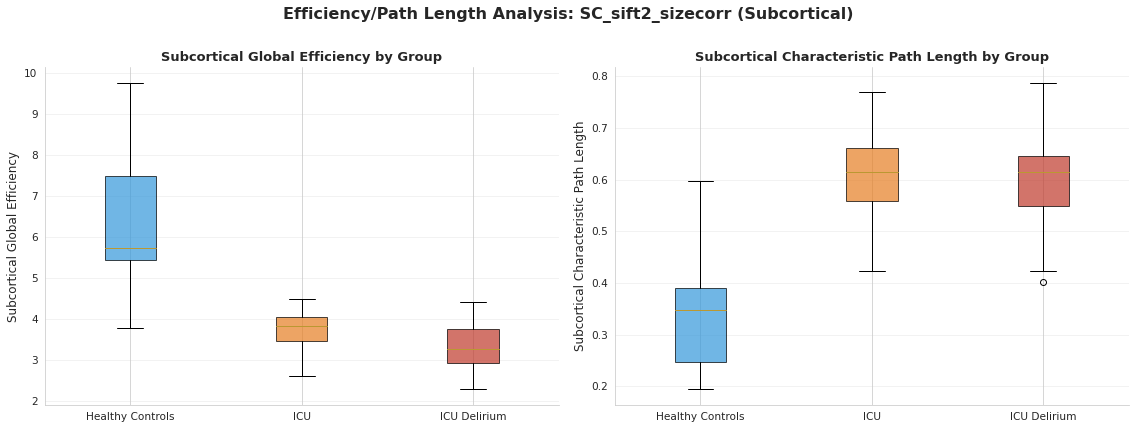

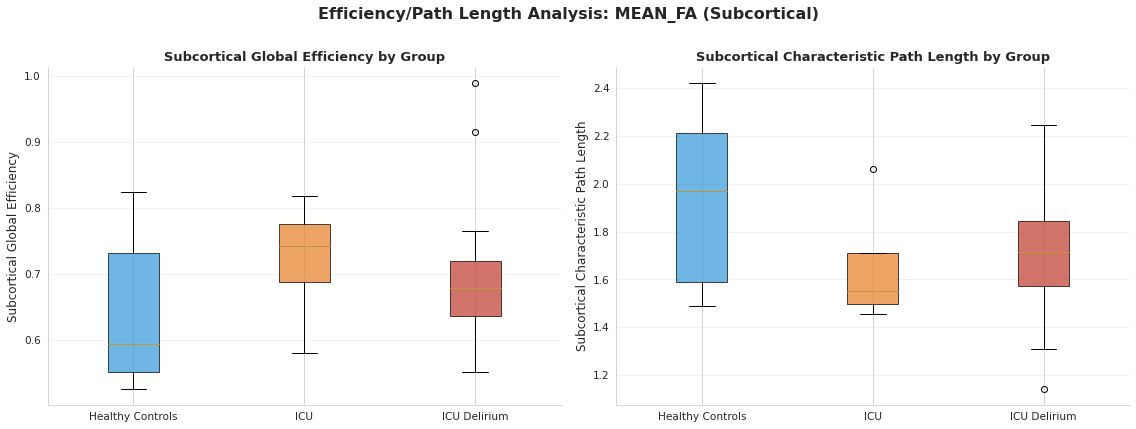

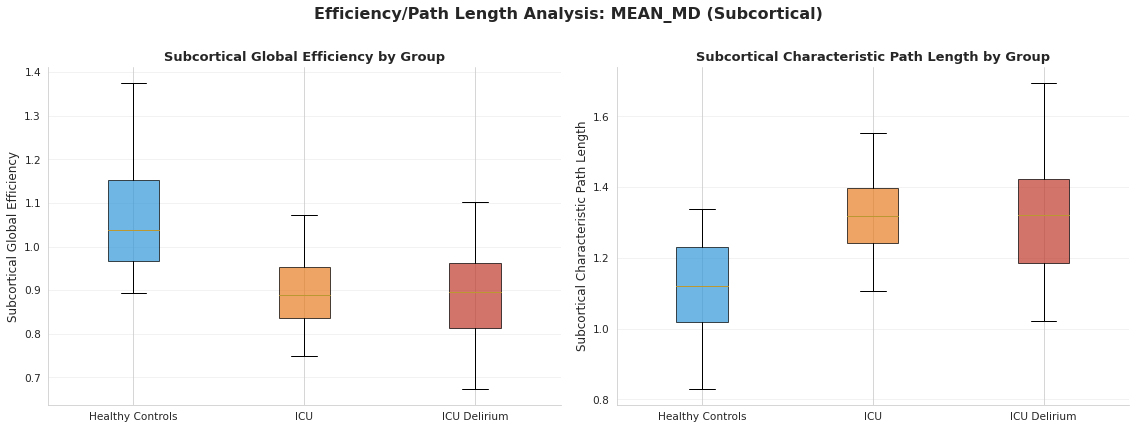

In [39]:

# ============================================================================
# 2. SUBCORTICAL ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("2. SUBCORTICAL ANALYSIS")
print("="*80)

for connectome_type in CONNECTOME_TYPES_TO_ANALYZE:
    print("\n" + "-"*80)
    print(f"Analyzing: {connectome_type} (Subcortical)")
    print("-"*80)
    
    try:
        result = run_full_efficiency_analysis(
            preproc_dir=PREPROC_DIR,
            connectome_type=connectome_type,
            groups=GROUPS,
            region_type='subcortical',
            save_dir=PREPROC_DIR / 'results',
            target_density=TARGET_DENSITY,
            use_bct=USE_BCT,
            verbose=True,
            parcel_to_category=parcel_to_category
        )
        results_efficiency[f'{connectome_type}_subcortical'] = result
        print(f"\n✓ Completed subcortical analysis for {connectome_type}")
    except Exception as e:
        print(f"\n✗ Error analyzing subcortical {connectome_type}: {e}")
        import traceback
        traceback.print_exc()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("ANALYSIS 2 COMPLETE")
print("="*80)
print(f"Analyzed {len(CONNECTOME_TYPES_TO_ANALYZE)} connectome types:")
for ct in CONNECTOME_TYPES_TO_ANALYZE:
    print(f"  - {ct}")
print(f"\nCompleted analyses:")
for key in results_efficiency.keys():
    print(f"  ✓ {key}")
print("\nAll results saved to:", PREPROC_DIR / 'results')


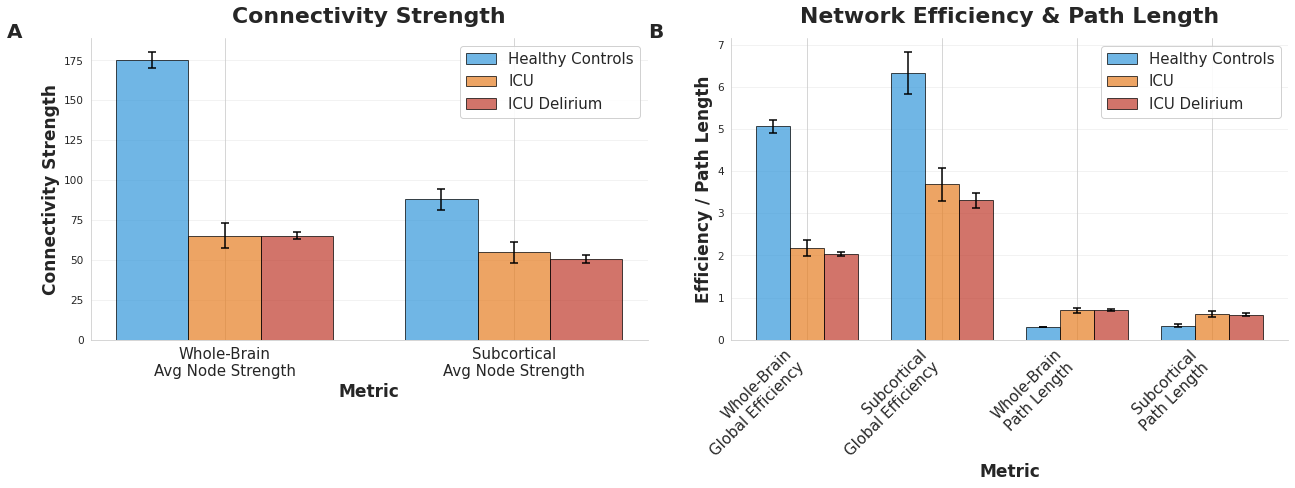


SUMMARY STATISTICS: SC_sift2_sizecorr

Connectivity Strength:
--------------------------------------------------------------------------------

Whole-Brain
Avg Node Strength:
  Healthy Controls: 175.2443 ± 4.7577 (n=12)
  ICU: 65.1881 ± 7.6745 (n=4)
  ICU Delirium: 65.1741 ± 2.2978 (n=12)

Subcortical
Avg Node Strength:
  Healthy Controls: 87.9044 ± 6.6438 (n=12)
  ICU: 54.7468 ± 6.7404 (n=4)
  ICU Delirium: 50.5352 ± 2.5508 (n=12)

Network Efficiency & Path Length:
--------------------------------------------------------------------------------

Whole-Brain
Global Efficiency:
  Healthy Controls: 5.0619 ± 0.1606 (n=12)
  ICU: 2.1878 ± 0.1908 (n=4)
  ICU Delirium: 2.0347 ± 0.0482 (n=12)

Subcortical
Global Efficiency:
  Healthy Controls: 6.3247 ± 0.4920 (n=12)
  ICU: 3.6914 ± 0.3927 (n=4)
  ICU Delirium: 3.3107 ± 0.1761 (n=12)

Whole-Brain
Path Length:
  Healthy Controls: 0.3030 ± 0.0098 (n=12)
  ICU: 0.6953 ± 0.0609 (n=4)
  ICU Delirium: 0.7031 ± 0.0181 (n=12)

Subcortical
Path Length

In [51]:
# ============================================================================
# COMPREHENSIVE 2-PANEL FIGURE: SC_sift2_sizecorr Global Network Topology
# ============================================================================

connectome_type = 'SC_sift2_sizecorr'

# Extract metrics DataFrames from results
wb_strength_df = results_analysis1[connectome_type]['metrics_df']
subcort_strength_df = results_analysis2[connectome_type]['metrics_df']
wb_efficiency_df = results_efficiency[f'{connectome_type}_cortical']['metrics_df']
subcort_efficiency_df = results_efficiency[f'{connectome_type}_subcortical']['metrics_df']

# Define group order and colors
group_order = ['Healthy Controls', 'ICU', 'ICU Delirium']
colors = get_group_colors(group_order)

# Create 2-panel figure
fig, axes = plt.subplots(1, 2, figsize=(18, 7))


# ============================================================================
# PANEL 1: Connectivity Strength (Whole-Brain + Subcortical)
# ============================================================================
ax1 = axes[0]

# Prepare data: combine whole-brain and subcortical strength metrics
metrics_to_plot = [
    ('Whole-Brain\nAvg Node Strength', wb_strength_df, 'avg_node_strength'),
    ('Subcortical\nAvg Node Strength', subcort_strength_df, 'avg_subcort_node_strength')
]

x_pos = np.arange(len(metrics_to_plot))
width = 0.25

# Calculate group means and SEMs for each metric
group_means = {group: [] for group in group_order}
group_sems = {group: [] for group in group_order}

for metric_label, df, col_name in metrics_to_plot:
    for group in group_order:
        group_data = df[df['group'] == group][col_name].dropna()
        if len(group_data) > 0:
            mean_val = group_data.mean()
            sem_val = stats.sem(group_data)
            group_means[group].append(mean_val)
            group_sems[group].append(sem_val)
        else:
            group_means[group].append(0)
            group_sems[group].append(0)

# Plot grouped bars with error bars
for i, group in enumerate(group_order):
    offset = (i - 1) * width
    means = group_means[group]
    sems = group_sems[group]
    bars = ax1.bar(x_pos + offset, means, width, 
                   label=group, color=colors[i], alpha=0.7, edgecolor='black', linewidth=1)
    # Add error bars (SEM)
    ax1.errorbar(x_pos + offset, means, yerr=sems, 
                fmt='none', color='black', capsize=4, capthick=1.5, linewidth=1.5)

ax1.set_xlabel('Metric', fontsize=17, fontweight='bold')
ax1.set_ylabel('Connectivity Strength', fontsize=17, fontweight='bold')
ax1.set_title('Connectivity Strength', fontsize=22, fontweight='bold', pad=15)
ax1.set_xticks(x_pos)
ax1.set_xticklabels([m[0] for m in metrics_to_plot], fontsize=15)
ax1.legend(fontsize=15, framealpha=0.9)
ax1.grid(True, alpha=0.3, axis='y')

# Add panel label
ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, 
        fontsize=20, fontweight='bold', va='top')

# ============================================================================
# PANEL 2: Network Efficiency & Path Length (Whole-Brain + Subcortical)
# ============================================================================
ax2 = axes[1]

# Prepare data: combine efficiency and path length metrics
efficiency_metrics = [
    ('Whole-Brain\nGlobal Efficiency', wb_efficiency_df, 'global_efficiency'),
    ('Subcortical\nGlobal Efficiency', subcort_efficiency_df, 'subcort_global_efficiency'),
    ('Whole-Brain\nPath Length', wb_efficiency_df, 'char_path_length'),
    ('Subcortical\nPath Length', subcort_efficiency_df, 'subcort_char_path_length')
]

x_pos2 = np.arange(len(efficiency_metrics))
width2 = 0.25

# Calculate group means and SEMs
eff_group_means = {group: [] for group in group_order}
eff_group_sems = {group: [] for group in group_order}

for metric_label, df, col_name in efficiency_metrics:
    for group in group_order:
        group_data = df[df['group'] == group][col_name].dropna()
        if len(group_data) > 0:
            mean_val = group_data.mean()
            sem_val = stats.sem(group_data)
            eff_group_means[group].append(mean_val)
            eff_group_sems[group].append(sem_val)
        else:
            eff_group_means[group].append(0)
            eff_group_sems[group].append(0)

# Plot grouped bars with error bars
for i, group in enumerate(group_order):
    offset = (i - 1) * width2
    means = eff_group_means[group]
    sems = eff_group_sems[group]
    bars = ax2.bar(x_pos2 + offset, means, width2, 
                   label=group, color=colors[i], alpha=0.7, edgecolor='black', linewidth=1)
    # Add error bars (SEM)
    ax2.errorbar(x_pos2 + offset, means, yerr=sems, 
                fmt='none', color='black', capsize=4, capthick=1.5, linewidth=1.5)

ax2.set_xlabel('Metric', fontsize=17, fontweight='bold')
ax2.set_ylabel('Efficiency / Path Length', fontsize=17, fontweight='bold')
ax2.set_title('Network Efficiency & Path Length', 
              fontsize=22, fontweight='bold', pad=15)
ax2.set_xticks(x_pos2)
ax2.set_xticklabels([m[0] for m in efficiency_metrics], fontsize=15, rotation=45, ha='right')
ax2.legend(fontsize=15, framealpha=0.9)
ax2.grid(True, alpha=0.3, axis='y')

# Add panel label
ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, 
        fontsize=20, fontweight='bold', va='top')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS: SC_sift2_sizecorr")
print("="*80)

print("\nConnectivity Strength:")
print("-" * 80)
for metric_label, df, col_name in metrics_to_plot:
    print(f"\n{metric_label}:")
    for group in group_order:
        group_data = df[df['group'] == group][col_name].dropna()
        if len(group_data) > 0:
            print(f"  {group}: {group_data.mean():.4f} ± {stats.sem(group_data):.4f} (n={len(group_data)})")

print("\nNetwork Efficiency & Path Length:")
print("-" * 80)
for metric_label, df, col_name in efficiency_metrics:
    print(f"\n{metric_label}:")
    for group in group_order:
        group_data = df[df['group'] == group][col_name].dropna()
        if len(group_data) > 0:
            print(f"  {group}: {group_data.mean():.4f} ± {stats.sem(group_data):.4f} (n={len(group_data)})")

print("\n" + "="*80)

# Structural Connectome Subject Similarity Analysis

This section computes and visualizes subject × subject similarity matrices for structural connectomes, organized by brain region categories (Yeo7 networks, subcortical, brainstem, cerebellum) instead of frequency bands.


In [4]:
# Define standardized groups (consistent naming: ICU, Delirium ICU, Healthy Controls)
GROUPS_SC_SIM = {
    'ICU': ['AF', 'DA2', 'PM', 'BA', 'VC'],
    'ICU Delirium': ['CG', 'DA', 'FS', 'FSE', 'GL', 'KJ', 'LL', 'MF', 'PM', 'PO', 'PB', 'SA'],
    'Healthy Controls': ['FEF', 'FD', 'GB', 'SG', 'AR', 'TL', 'TOG', 'PL', 'ZM', 'AM', 'PC', 'AD']
}

# Define region categories
# Note: Cerebellum (2 parcels) is excluded - insufficient data for meaningful correlation (only 1 edge)
REGION_CATEGORIES = [f'Yeo7_Network_{i}' for i in range(1, 8)] + ['Subcortical', 'Brainstem']

print("✓ Structural connectome similarity analysis functions imported (reloaded)")
print(f"  Groups: {list(GROUPS_SC_SIM.keys())}")
print(f"  Region categories: {len(REGION_CATEGORIES)}")
print(f"  First 3: {REGION_CATEGORIES[:3]}")
print(f"  Last 3: {REGION_CATEGORIES[-3:]}")


✓ Structural connectome similarity analysis functions imported (reloaded)
  Groups: ['ICU', 'ICU Delirium', 'Healthy Controls']
  Region categories: 9
  First 3: ['Yeo7_Network_1', 'Yeo7_Network_2', 'Yeo7_Network_3']
  Last 3: ['Yeo7_Network_7', 'Subcortical', 'Brainstem']


In [5]:
CONNECTOME_TYPE_SIM = "SC_sift2_sizecorr" 

similarity_df = compute_sc_similarity_between_subjects(
    preproc_dir=PREPROC_DIR,
    connectome_type=CONNECTOME_TYPE_SIM,
    groups=GROUPS_SC_SIM,
    overwrite=True,  # Set to True to recompute
    save_path=None  # Will save to PREPROC_DIR/results/sc_similarity_matrices.h5
)

print(f"\n✓ Similarity computation complete")
print(f"  Total similarity pairs: {len(similarity_df)}")
print(f"  Groups: {similarity_df['Group'].unique().tolist()}")
print(f"  Region categories: {similarity_df['Region Category'].unique().tolist()}")
print(f"\nFirst few rows:")
print(similarity_df.head())


Computing similarity matrices between subjects for structural connectomes...
Loading SC_sift2_sizecorr connectomes...
✓ Loaded sub-AD: shape (430, 430)
✓ Loaded sub-AF: shape (430, 430)
✓ Loaded sub-AM: shape (430, 430)
✓ Loaded sub-AR: shape (430, 430)
✓ Loaded sub-BA: shape (430, 430)
✓ Loaded sub-CG: shape (430, 430)
✓ Loaded sub-DA: shape (430, 430)
✓ Loaded sub-DA2: shape (430, 430)
✓ Loaded sub-FD: shape (430, 430)
✓ Loaded sub-FEF: shape (430, 430)
✓ Loaded sub-FS: shape (430, 430)
✓ Loaded sub-FSE: shape (430, 430)
✓ Loaded sub-GB: shape (430, 430)
✓ Loaded sub-GL: shape (430, 430)
✓ Loaded sub-KJ: shape (430, 430)
✓ Loaded sub-LL: shape (430, 430)
✓ Loaded sub-MF: shape (430, 430)
✓ Loaded sub-PB: shape (430, 430)
✓ Loaded sub-PC: shape (430, 430)
✓ Loaded sub-PL: shape (430, 430)
✓ Loaded sub-PM: shape (430, 430)
✓ Loaded sub-PMA: shape (430, 430)
✓ Loaded sub-PO: shape (430, 430)
✓ Loaded sub-SA: shape (430, 430)
✓ Loaded sub-SG: shape (430, 430)
✓ Loaded sub-TL: shape (430,

 Saved figure to /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/results/sc_subject_similarity_SC_sift2_sizecorr.png


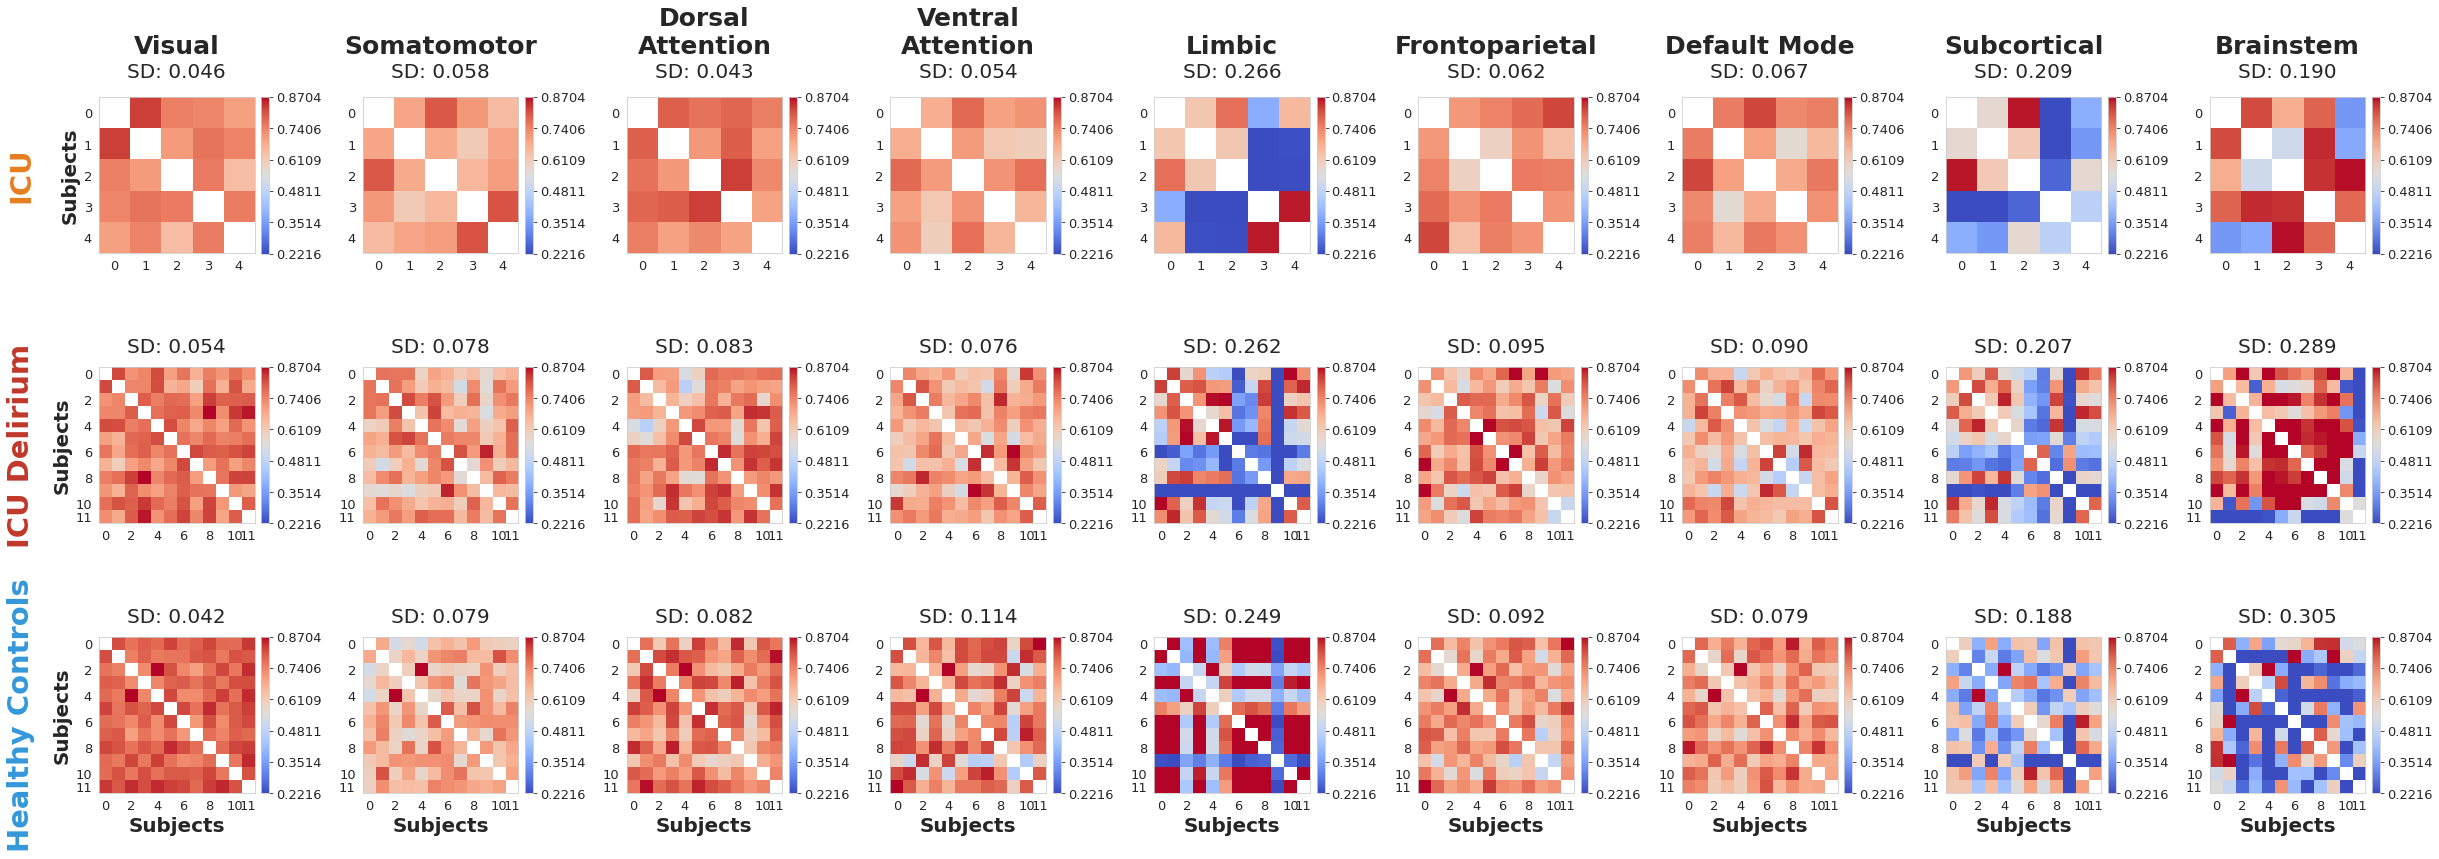

✓ Figure saved to /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/results/sc_subject_similarity_SC_sift2_sizecorr.png


In [21]:
# Plot subject × subject similarity matrices
# Layout: Groups as rows, region categories as columns
from utils.connectome_utils import plot_sc_fingerprint_btw_subjects_by_group
save_path_fig = PREPROC_DIR / 'results' / f'sc_subject_similarity_{CONNECTOME_TYPE_SIM}.png'

plot_sc_fingerprint_btw_subjects_by_group(
    similarity_df=similarity_df,
    groups=GROUPS_SC_SIM,
    region_categories=REGION_CATEGORIES,
    save_path=save_path_fig,
    connectome_type=CONNECTOME_TYPE_SIM,
    scale='same',  # 'bygroup', 'same', or 'auto'
    add_sd=True  # Add standard deviation to subplot titles
)
plt.show() 
print(f"✓ Figure saved to {save_path_fig}")


In [13]:
# ================================================================================
# CONNECTOME VISUALIZATION WITH CORTICAL/SUBCORTICAL ORDERING
# ================================================================================

parcel_to_yeo7, parcel_to_category = load_parcellation_mappings()

# 3. Yeo7 network names (in order 1-7)
yeo7_names = ['Visual', 'Somatomotor', 'DorsalAttn', 'VentralAttn', 'Limbic', 'FrontoParietal', 'Default']

# Load group-averaged connectomes for SC_sift2_sizecorr
CONNECTOME_TYPE_VIZ = 'SC_sift2_sizecorr'
print(f"\nLoading {CONNECTOME_TYPE_VIZ} connectomes...")

connectomes_dict = load_all_connectomes(PREPROC_DIR, CONNECTOME_TYPE_VIZ)
print(f"✓ Loaded {len(connectomes_dict)} connectomes")

# Compute group averages
group_averages = {}
for group_name, subjects in GROUPS.items():
    group_connectomes = {}
    for subj in subjects:
        subj_key = f'sub-{subj}' if not subj.startswith('sub-') else subj
        if subj_key in connectomes_dict:
            group_connectomes[subj_key] = connectomes_dict[subj_key]
    
    if len(group_connectomes) > 0:
        group_averages[group_name] = compute_group_average(group_connectomes)
        print(f"  {group_name}: N={len(group_connectomes)} subjects")

print(f"\n Computed group averages for {len(group_averages)} groups")



Loading SC_sift2_sizecorr connectomes...
✓ Loaded sub-AD: shape (430, 430)
✓ Loaded sub-AF: shape (430, 430)
✓ Loaded sub-AM: shape (430, 430)
✓ Loaded sub-AR: shape (430, 430)
✓ Loaded sub-BA: shape (430, 430)
✓ Loaded sub-CG: shape (430, 430)
✓ Loaded sub-DA: shape (430, 430)
✓ Loaded sub-DA2: shape (430, 430)
✓ Loaded sub-FD: shape (430, 430)
✓ Loaded sub-FEF: shape (430, 430)
✓ Loaded sub-FS: shape (430, 430)
✓ Loaded sub-FSE: shape (430, 430)
✓ Loaded sub-GB: shape (430, 430)
✓ Loaded sub-GL: shape (430, 430)
✓ Loaded sub-KJ: shape (430, 430)
✓ Loaded sub-LL: shape (430, 430)
✓ Loaded sub-MF: shape (430, 430)
✓ Loaded sub-PB: shape (430, 430)
✓ Loaded sub-PC: shape (430, 430)
✓ Loaded sub-PL: shape (430, 430)
✓ Loaded sub-PM: shape (430, 430)
✓ Loaded sub-PMA: shape (430, 430)
✓ Loaded sub-PO: shape (430, 430)
✓ Loaded sub-SA: shape (430, 430)
✓ Loaded sub-SG: shape (430, 430)
✓ Loaded sub-TL: shape (430, 430)
✓ Loaded sub-TOG: shape (430, 430)
✓ Loaded sub-VC: shape (430, 430)
✓

CREATING COMBINED CONNECTOME PLOTS (Cortical + Subcortical)

CREATING CORTICAL CONNECTOME PLOTS

Plotting cortical connectome for ICU...


  ✓ Saved: SC_sift2_sizecorr_ICU_cortical.png

Plotting cortical connectome for ICU Delirium...
  ✓ Saved: SC_sift2_sizecorr_ICU_Delirium_cortical.png

Plotting cortical connectome for Healthy Controls...
  ✓ Saved: SC_sift2_sizecorr_Healthy_Controls_cortical.png

CREATING SUBCORTICAL CONNECTOME PLOTS

Plotting subcortical connectome for ICU...
  ✓ Saved: SC_sift2_sizecorr_ICU_subcortical.png

Plotting subcortical connectome for ICU Delirium...
  ✓ Saved: SC_sift2_sizecorr_ICU_Delirium_subcortical.png

Plotting subcortical connectome for Healthy Controls...
  ✓ Saved: SC_sift2_sizecorr_Healthy_Controls_subcortical.png

Figures saved to: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/results
Connectome type: SC_sift2_sizecorr
Groups visualized: ['ICU', 'ICU Delirium', 'Healthy Controls']


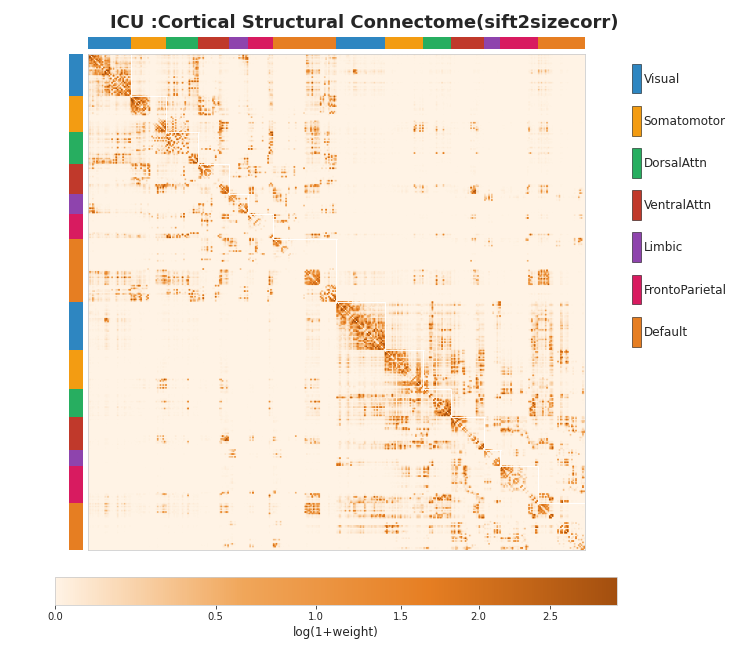

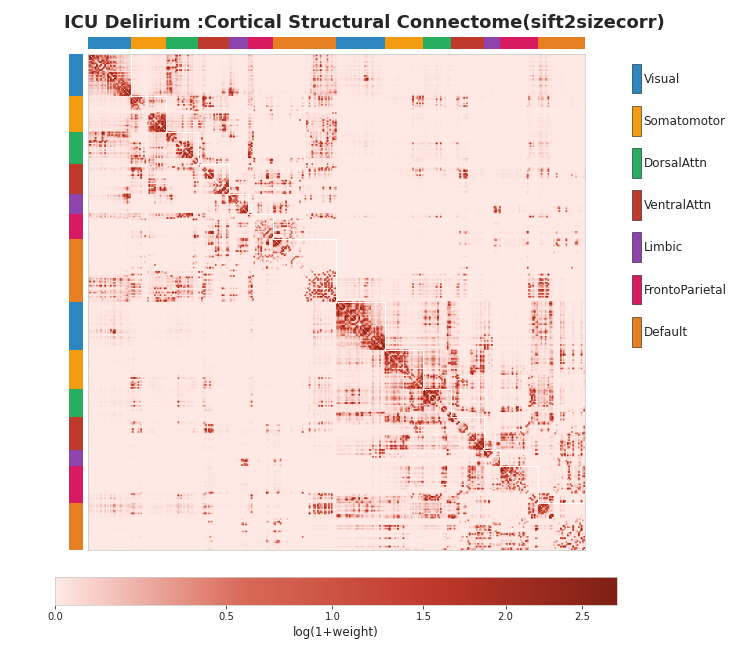

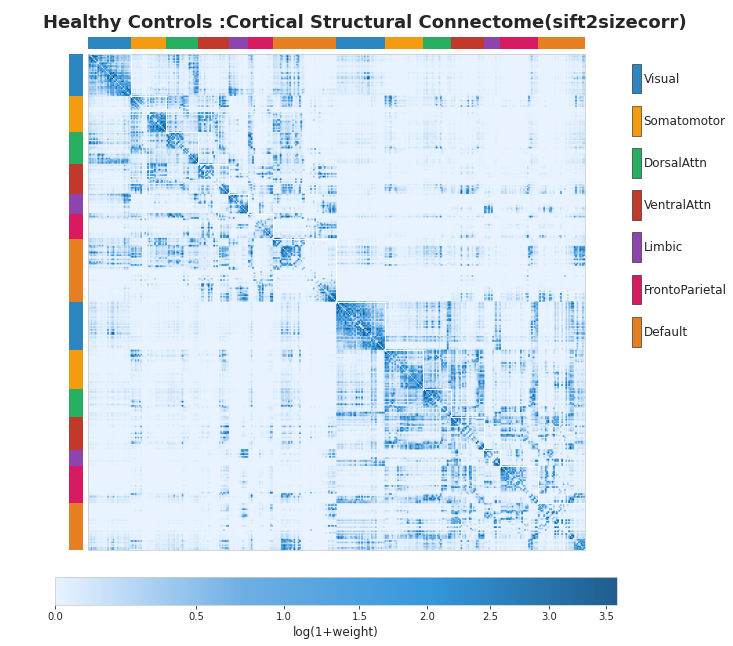

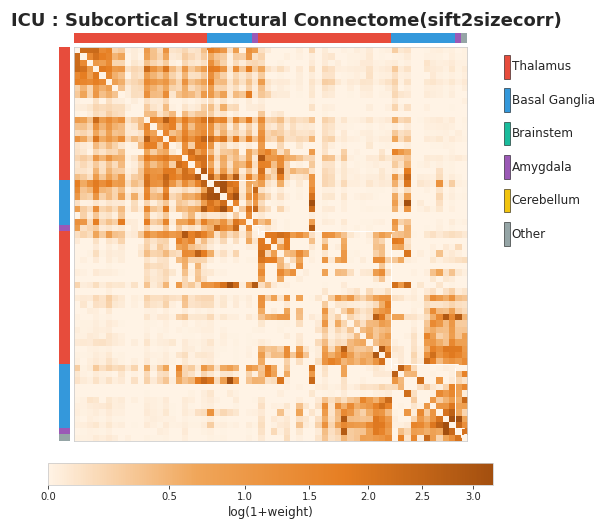

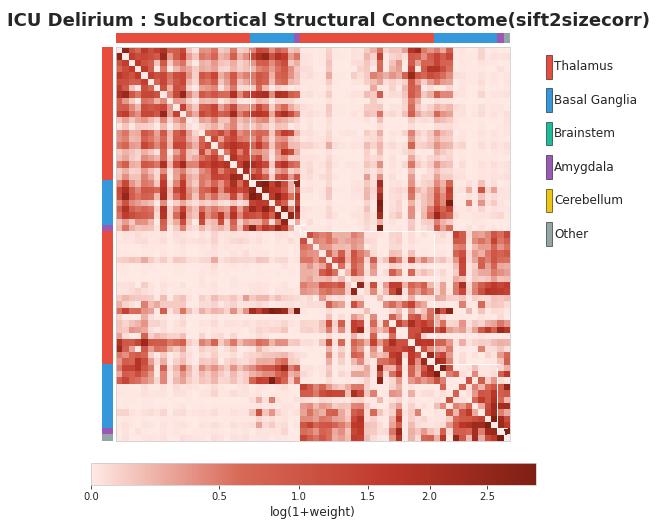

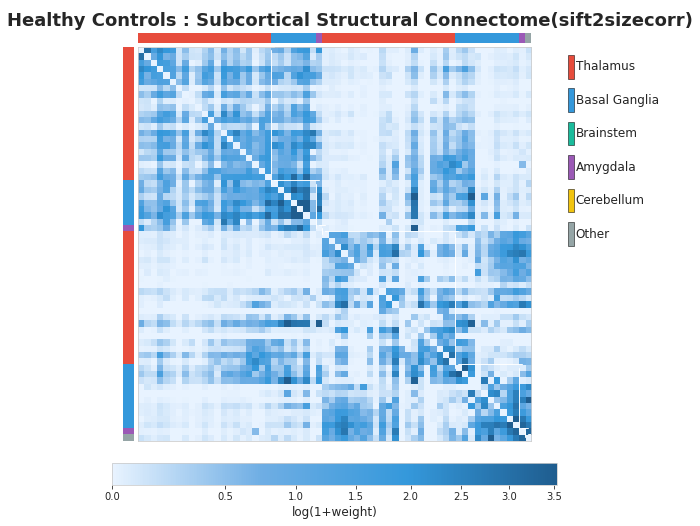

In [14]:
# Create visualizations for all three groups
# Option 1: Combined plots (cortical + subcortical, 430×430)
print("=" * 80)
print("CREATING COMBINED CONNECTOME PLOTS (Cortical + Subcortical)")
print("=" * 80)

results_dir = PREPROC_DIR / 'results'
results_dir.mkdir(exist_ok=True, parents=True)  

# Option 2: Separate cortical plots (360×360)
print("\n" + "=" * 80)
print("CREATING CORTICAL CONNECTOME PLOTS")
print("=" * 80)

for group_name, M_avg in group_averages.items():
    print(f"\nPlotting cortical connectome for {group_name}...")
    fig = plot_group_connectome_LH_RH(
        M_avg,
        A7=parcel_to_yeo7,
        yeo7_names=yeo7_names,
        title=f"{group_name} :Cortical Structural Connectome(sift2sizecorr)",
        cmap=get_group_cmap(group_name),
        save_path=results_dir / f'{CONNECTOME_TYPE_VIZ}_{group_name.replace(" ", "_")}_cortical.png'
    )
    print(f"  ✓ Saved: {CONNECTOME_TYPE_VIZ}_{group_name.replace(' ', '_')}_cortical.png")

# Option 3: Separate subcortical plots (72×72)
print("\n" + "=" * 80)
print("CREATING SUBCORTICAL CONNECTOME PLOTS")
print("=" * 80)

for group_name, M_avg in group_averages.items():
    print(f"\nPlotting subcortical connectome for {group_name}...")
    fig = plot_subcortical_connectome(
        M_avg,
        parcel_to_category=parcel_to_category,
        title=f"{group_name} : Subcortical Structural Connectome(sift2sizecorr)",
        cmap=get_group_cmap(group_name),
        save_path=results_dir / f'{CONNECTOME_TYPE_VIZ}_{group_name.replace(" ", "_")}_subcortical.png'
    )
    print(f"  ✓ Saved: {CONNECTOME_TYPE_VIZ}_{group_name.replace(' ', '_')}_subcortical.png")

print(f"\nFigures saved to: {results_dir}")
print(f"Connectome type: {CONNECTOME_TYPE_VIZ}")
print(f"Groups visualized: {list(group_averages.keys())}")


Loading SC_sift2_sizecorr connectomes...
✓ Loaded sub-AD: shape (430, 430)
✓ Loaded sub-AF: shape (430, 430)
✓ Loaded sub-AM: shape (430, 430)
✓ Loaded sub-AR: shape (430, 430)
✓ Loaded sub-BA: shape (430, 430)
✓ Loaded sub-CG: shape (430, 430)
✓ Loaded sub-DA: shape (430, 430)
✓ Loaded sub-DA2: shape (430, 430)
✓ Loaded sub-FD: shape (430, 430)
✓ Loaded sub-FEF: shape (430, 430)
✓ Loaded sub-FS: shape (430, 430)
✓ Loaded sub-FSE: shape (430, 430)
✓ Loaded sub-GB: shape (430, 430)
✓ Loaded sub-GL: shape (430, 430)
✓ Loaded sub-KJ: shape (430, 430)
✓ Loaded sub-LL: shape (430, 430)
✓ Loaded sub-MF: shape (430, 430)
✓ Loaded sub-PB: shape (430, 430)
✓ Loaded sub-PC: shape (430, 430)
✓ Loaded sub-PL: shape (430, 430)
✓ Loaded sub-PM: shape (430, 430)
✓ Loaded sub-PMA: shape (430, 430)
✓ Loaded sub-PO: shape (430, 430)
✓ Loaded sub-SA: shape (430, 430)
✓ Loaded sub-SG: shape (430, 430)
✓ Loaded sub-TL: shape (430, 430)
✓ Loaded sub-TOG: shape (430, 430)
✓ Loaded sub-VC: shape (430, 430)
✓ 

✓ Saved figure to /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/results/SC_sift2_sizecorr_all_subjects_similarity_by_region.png

Computing full-matrix similarity (all subjects)...

✓ Saved region-wise similarity plot and full-matrix similarity heatmap


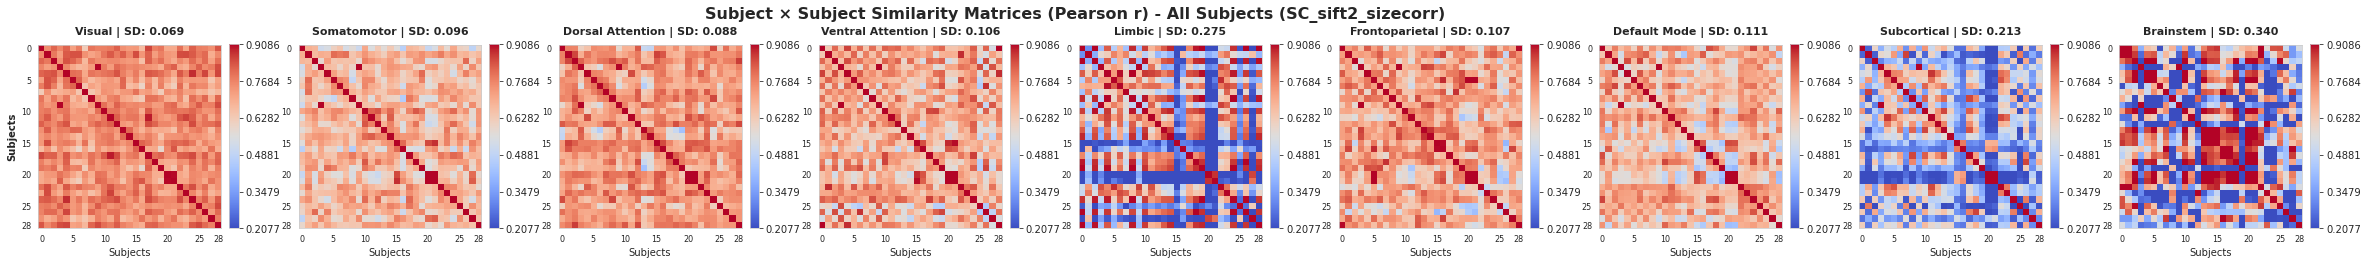

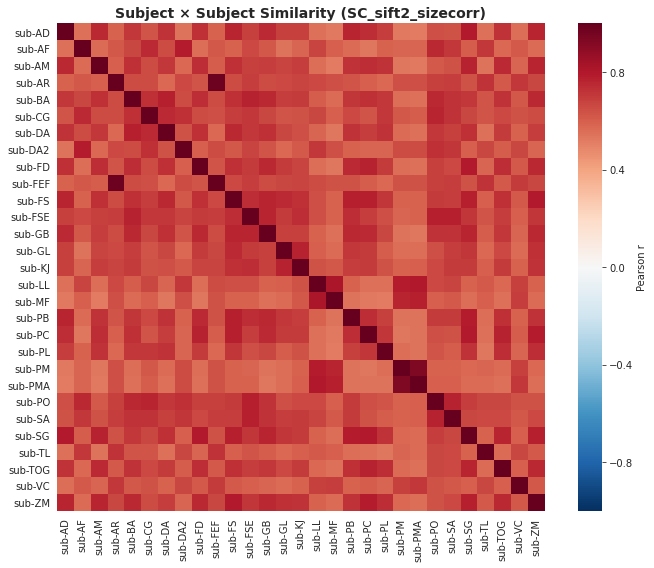

In [15]:
# All-subject similarity by region category + subject×subject similarity (SC_sift2_sizecorr)

import pandas as pd

CONNECTOME_TYPE = 'SC_sift2_sizecorr'
results_dir = PREPROC_DIR / 'results'
results_dir.mkdir(exist_ok=True)

# Load mappings for plotting
parcel_to_yeo7, parcel_to_category = load_parcellation_mappings()
atlas_to_yeo7_df = pd.read_csv(ATLAS_TO_YEO7_CSV)

# Define region categories (same as used in group-wise analysis)
# Note: Cerebellum (2 parcels) is excluded - insufficient data for meaningful correlation (only 1 edge)
REGION_CATEGORIES = [f'Yeo7_Network_{i}' for i in range(1, 8)] + ['Subcortical', 'Brainstem']

# Load all connectomes
print(f"Loading {CONNECTOME_TYPE} connectomes...")
connectomes_dict = load_all_connectomes(
    preproc_dir=PREPROC_DIR,
    connectome_type=CONNECTOME_TYPE,
)

# 1) Subject × subject similarity by region category (all subjects combined, 1 row)
print("\nComputing similarity matrices by region category (all subjects)...")
similarity_matrices_by_region = compute_sc_similarity_all_subjects_by_region(
    connectomes_dict=connectomes_dict,
    region_categories=REGION_CATEGORIES,
    atlas_to_yeo7_df=atlas_to_yeo7_df,
)

region_sim_fig = plot_sc_similarity_all_subjects_by_region(
    similarity_matrices=similarity_matrices_by_region,
    region_categories=REGION_CATEGORIES,
    connectome_type=CONNECTOME_TYPE,
    scale='same',
    add_sd=True,
    save_path=results_dir / f"{CONNECTOME_TYPE}_all_subjects_similarity_by_region.png",
)

# 2) Subject × subject similarity using full matrices (upper triangle vector, Pearson r)
print("\nComputing full-matrix similarity (all subjects)...")
sim_matrix, subjects = compute_full_subject_similarity_matrix(connectomes_dict)
sim_fig = plot_subject_similarity_heatmap(
    sim_matrix,
    subjects,
    title=f"Subject × Subject Similarity ({CONNECTOME_TYPE})",
    cmap='RdBu_r',
    save_path=results_dir / f"{CONNECTOME_TYPE}_subject_similarity.png",
)

# Save similarity matrix for reuse
sim_df = pd.DataFrame(sim_matrix, index=subjects, columns=subjects)
sim_df.to_csv(results_dir / f"{CONNECTOME_TYPE}_subject_similarity_matrix.csv")
print("\n✓ Saved region-wise similarity plot and full-matrix similarity heatmap")


# Boostrap analysis 

In [5]:
# Load required mappings for bootstrap analysis
# (This ensures parcel_to_yeo7 and parcel_to_category are available)
from utils import load_parcellation_mappings

if 'parcel_to_yeo7' not in locals() and 'parcel_to_yeo7' not in globals():
    parcel_to_yeo7, parcel_to_category = load_parcellation_mappings()
    print(f"Loaded Yeo7 mapping for {len(parcel_to_yeo7)} parcels")
else:
    print("parcel_to_yeo7 already loaded")


Loaded Yeo7 mapping for 360 parcels


In [ ]:
# ============================================================================
# BOOTSTRAP ANALYSIS: Connectivity Strength Metrics
# ============================================================================
# Stratified bootstrap resampling for connectivity strength metrics
# Excludes resilience metrics as specified

# Configuration
N_BOOTSTRAP = 5000  # Number of bootstrap iterations
CONFIDENCE_LEVEL = 0.95  # 95% confidence intervals
RANDOM_SEED = 42  # For reproducibility

# Connectome types to analyze (same as main analysis)
CONNECTOME_TYPES_TO_ANALYZE = ['SC_sift2_sizecorr', 'MEAN_FA', 'MEAN_MD']

# Store bootstrap results
bootstrap_results_connectivity = {}

print("="*80)
print("BOOTSTRAP ANALYSIS: Connectivity Strength (Whole Brain)")
print("="*80)
print(f"Bootstrap iterations: {N_BOOTSTRAP}")
print(f"Confidence level: {CONFIDENCE_LEVEL*100}%")
print(f"Random seed: {RANDOM_SEED}")
print()

for connectome_type in CONNECTOME_TYPES_TO_ANALYZE:
    print(f"\n{'='*80}")
    print(f"Analyzing: {connectome_type}")
    print(f"{'='*80}")
    
    try:
        # Load connectomes
        connectomes_dict = load_all_connectomes(PREPROC_DIR, connectome_type)
        
        if len(connectomes_dict) == 0:
            print(f"  ⚠ No connectomes found for {connectome_type}, skipping...")
            continue
        
        # Run bootstrap analysis
        bootstrap_result = bootstrap_global_network_metrics(
            connectomes_dict=connectomes_dict,
            groups=GROUPS,
            metric_type='connectivity_strength',
            n_bootstrap=N_BOOTSTRAP,
            confidence_level=CONFIDENCE_LEVEL,
            random_seed=RANDOM_SEED,
            region_type='whole_brain',
            parcel_to_yeo7=parcel_to_yeo7,
            verbose=True
        )
        
        # Save results
        bootstrap_results_connectivity[connectome_type] = bootstrap_result
        
        # Save summary files
        save_path = PREPROC_DIR / 'results' / f'bootstrap_connectivity_strength_whole_brain_{connectome_type}'
        save_bootstrap_summary(bootstrap_result, save_path, verbose=True)
        
        # Create and save plots
        metric_names = ['total_strength', 'avg_node_strength']
        fig = plot_bootstrap_results(
            bootstrap_result,
            groups=GROUPS,
            connectome_type=connectome_type,
            metric_names=metric_names,
            save_path=PREPROC_DIR / 'results' / f'bootstrap_connectivity_strength_whole_brain_{connectome_type}.png'
        )
        plt.show()
        
        print(f"\n✓ Completed bootstrap analysis for {connectome_type}")
        
    except Exception as e:
        print(f"\n✗ Error in bootstrap analysis for {connectome_type}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*80}")
print(f"Bootstrap analysis completed for {len(bootstrap_results_connectivity)} connectome types")
print(f"{'='*80}")


BOOTSTRAP ANALYSIS: Connectivity Strength (Whole Brain)
Bootstrap iterations: 5000
Confidence level: 95.0%
Random seed: 42


Analyzing: SC_sift2_sizecorr
✓ Loaded sub-AD: shape (430, 430)
✓ Loaded sub-AF: shape (430, 430)
✓ Loaded sub-AM: shape (430, 430)
✓ Loaded sub-AR: shape (430, 430)
✓ Loaded sub-BA: shape (430, 430)
✓ Loaded sub-CG: shape (430, 430)
✓ Loaded sub-DA: shape (430, 430)
✓ Loaded sub-DA2: shape (430, 430)
✓ Loaded sub-FD: shape (430, 430)
✓ Loaded sub-FEF: shape (430, 430)
✓ Loaded sub-FS: shape (430, 430)
✓ Loaded sub-FSE: shape (430, 430)
✓ Loaded sub-GB: shape (430, 430)
✓ Loaded sub-GL: shape (430, 430)
✓ Loaded sub-KJ: shape (430, 430)
✓ Loaded sub-LL: shape (430, 430)
✓ Loaded sub-MF: shape (430, 430)
✓ Loaded sub-PB: shape (430, 430)
✓ Loaded sub-PC: shape (430, 430)
✓ Loaded sub-PL: shape (430, 430)
✓ Loaded sub-PM: shape (430, 430)
✓ Loaded sub-PMA: shape (430, 430)
✓ Loaded sub-PO: shape (430, 430)
✓ Loaded sub-SA: shape (430, 430)
✓ Loaded sub-SG: shape (43

In [ ]:

# ============================================================================
# BOOTSTRAP ANALYSIS: Efficiency and Path Length Metrics
# ============================================================================
# Stratified bootstrap resampling for global efficiency and characteristic path length


# Make sure mappings are available
if 'parcel_to_yeo7' not in locals() and 'parcel_to_yeo7' not in globals():
    from utils import load_parcellation_mappings
    parcel_to_yeo7, parcel_to_category = load_parcellation_mappings()
    print(f"✓ Loaded Yeo7 mapping for {len(parcel_to_yeo7)} parcels")

# Configuration (reuse from above if already defined)
N_BOOTSTRAP = 5000       # Number of bootstrap iterations
CONFIDENCE_LEVEL = 0.95  # 95% confidence intervals
RANDOM_SEED = 42         # For reproducibility
CONNECTOME_TYPES_TO_ANALYZE = ['SC_sift2_sizecorr', 'MEAN_FA', 'MEAN_MD']

bootstrap_results_efficiency = {}

print("="*80)
print("BOOTSTRAP ANALYSIS: Efficiency and Path Length (Whole Brain)")
print("="*80)
print(f"Bootstrap iterations: {N_BOOTSTRAP}")
print(f"Confidence level: {CONFIDENCE_LEVEL*100}%")
print(f"Random seed: {RANDOM_SEED}")
print()

for connectome_type in CONNECTOME_TYPES_TO_ANALYZE:
    print(f"\n{'='*80}")
    print(f"Analyzing: {connectome_type}")
    print(f"{'='*80}")
    try:
        connectomes_dict = load_all_connectomes(PREPROC_DIR, connectome_type)
        if len(connectomes_dict) == 0:
            print(f"  ⚠ No connectomes found for {connectome_type}, skipping...")
            continue

        bootstrap_result = bootstrap_global_network_metrics(
            connectomes_dict=connectomes_dict,
            groups=GROUPS,
            metric_type='efficiency_pathlength',
            n_bootstrap=N_BOOTSTRAP,
            confidence_level=CONFIDENCE_LEVEL,
            random_seed=RANDOM_SEED,
            region_type='whole_brain',
            target_density=None,   # set a density (e.g., 0.15) if you want fixed-density thresholding
            use_bct=False,         # set True to use BCT shortest paths if desired
            verbose=True
        )

        bootstrap_results_efficiency[connectome_type] = bootstrap_result

        save_path = PREPROC_DIR / 'results' / f'bootstrap_efficiency_pathlength_whole_brain_{connectome_type}'
        save_bootstrap_summary(bootstrap_result, save_path, verbose=True)

        metric_names = ['global_efficiency', 'char_path_length']
        fig = plot_bootstrap_results(
            bootstrap_result,
            groups=GROUPS,
            connectome_type=connectome_type,
            metric_names=metric_names,
            save_path=PREPROC_DIR / 'results' / f'bootstrap_efficiency_pathlength_whole_brain_{connectome_type}.png'
        )
        plt.show()

        print(f"\n✓ Completed bootstrap analysis for {connectome_type}")

    except Exception as e:
        print(f"\n✗ Error in bootstrap analysis for {connectome_type}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*80}")
print(f"Bootstrap analysis completed for {len(bootstrap_results_efficiency)} connectome types")
print(f"{'='*80}")

BOOTSTRAP ANALYSIS: Efficiency and Path Length (Whole Brain)
Bootstrap iterations: 5000
Confidence level: 95.0%
Random seed: 42


Analyzing: SC_sift2_sizecorr
✓ Loaded sub-AD: shape (430, 430)
✓ Loaded sub-AF: shape (430, 430)
✓ Loaded sub-AM: shape (430, 430)
✓ Loaded sub-AR: shape (430, 430)
✓ Loaded sub-BA: shape (430, 430)
✓ Loaded sub-CG: shape (430, 430)
✓ Loaded sub-DA: shape (430, 430)
✓ Loaded sub-DA2: shape (430, 430)
✓ Loaded sub-FD: shape (430, 430)
✓ Loaded sub-FEF: shape (430, 430)
✓ Loaded sub-FS: shape (430, 430)
✓ Loaded sub-FSE: shape (430, 430)
✓ Loaded sub-GB: shape (430, 430)
✓ Loaded sub-GL: shape (430, 430)
✓ Loaded sub-KJ: shape (430, 430)
✓ Loaded sub-LL: shape (430, 430)
✓ Loaded sub-MF: shape (430, 430)
✓ Loaded sub-PB: shape (430, 430)
✓ Loaded sub-PC: shape (430, 430)
✓ Loaded sub-PL: shape (430, 430)
✓ Loaded sub-PM: shape (430, 430)
✓ Loaded sub-PMA: shape (430, 430)
✓ Loaded sub-PO: shape (430, 430)
✓ Loaded sub-SA: shape (430, 430)
✓ Loaded sub-SG: shap